# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')
campvectrain = np.transpose(campvectrain, (0,2,3,1))

In [6]:
np.shape(campvectrain)

(7000, 100, 100, 2)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')
campvectest = np.transpose(campvectest, (0,2,3,1))

In [10]:
np.shape(campvectest)

(2000, 100, 100, 2)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')
campvecval = np.transpose(campvecval, (0,2,3,1))

In [14]:
np.shape(campvecval)

(1000, 100, 100, 2)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 100, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [22]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [33]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [39]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

def objective(trial):
    model = Sequential()
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 5)
    
    input_shape = (100, 100, 2)  # Tus dimensiones de entrada
    current_shape = (20,20,2)
    
    for i in range(n_conv_layers):
        num_filters = trial.suggest_int(f"num_filters_{i+1}", 8, 50)
        filter_size1 = trial.suggest_int(f"filter_size1_{i+1}", 2, 5)
        filter_size2 = trial.suggest_int(f"filter_size2_{i+1}", 2, 5)
        activation = trial.suggest_categorical(f"activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"kernel_regularizer_{i+1}", ['l1', 'l2'])
        
        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)
            
            
        if (current_shape[0] - filter_size1 + 1 > 0) and (current_shape[1] - filter_size2 + 1 > 0):
            if i == 0:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            else:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            
            current_shape = (current_shape[0] - filter_size1 + 1, current_shape[1] - filter_size2 + 1, num_filters)
            
        # Decide si agregar una capa de MaxPooling después de esta capa convolucional
        add_maxpooling = trial.suggest_categorical(f"add_maxpooling_after_conv_{i+1}", [True, False])
        if add_maxpooling:
            if current_shape[0] >= 2 and current_shape[1] >= 2:  # Asegurarse de que ambas dimensiones son suficientes para MaxPooling
                model.add(MaxPooling2D(pool_size=(2, 2)))
                current_shape = (current_shape[0] // 2, current_shape[1] // 2, current_shape[2])
        
    n_dense_layers = trial.suggest_int("n_dense_layers", 1, 4)
    
    for i in range(n_dense_layers):
        num_units = trial.suggest_int(f"num_units_{i+1}", 16, 128)
        activation = trial.suggest_categorical(f"dense_activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"dense_kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"dense_kernel_regularizer_{i+1}", ['l1', 'l2'])

        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)

        model.add(Dense(num_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
    
        # Decide si agregar una capa de BatchNormalization después de esta capa densa
#        add_batchnorm = trial.suggest_categorical(f"add_batchnorm_after_dense_{i+1}", [True, False])
#        if add_batchnorm:
#            model.add(BatchNormalization())    
        # Decide si agregar una capa de Dropout después de esta capa densa
        add_dropout = trial.suggest_categorical(f"add_dropout_after_dense_{i+1}", [True, False])
        if add_dropout:
            dropout_rate = trial.suggest_float(f"dropout_rate_after_dense_{i+1}", 0.1, 0.5)
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(7, activation=custom_activation))
    model.add(GlobalAveragePooling2D())

        
    optimizer = Adam(learning_rate=0.001, clipvalue=100.0)
        
    model.compile(optimizer=optimizer, loss= 'mean_squared_error', metrics=metrics)
    
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=30,  
        callbacks=[reduce_lr, early_stop]
    )
    
    val_mean_metric = history.history['val_mean_metric'][-1]
    
    return val_mean_metric

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f'Número de trials finalizados: {len(study.trials)}')
print(f'Mejor trial:')
trial = study.best_trial

print(f'  Valor: {trial.value}')
print('  Parámetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-01 09:21:53,782] A new study created in memory with name: no-name-2474928c-b5af-4590-8f38-7afc6015d73b


Epoch 1/30
70/70 [==============================] - 7s 93ms/step - loss: 8.4831 - a_1: 2.7659 - a_2: 2.7613 - b_1: 2.6364 - b_2: 2.7484 - d_1: 1.4210 - d_2: 1.4051 - n: 1.5976 - mean_metric: 0.5055 - val_loss: 7.7726 - val_a_1: 2.7140 - val_a_2: 2.7494 - val_b_1: 2.5757 - val_b_2: 2.7857 - val_d_1: 0.8468 - val_d_2: 0.8796 - val_n: 1.5831 - val_mean_metric: 0.4676 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 6s 89ms/step - loss: 7.5604 - a_1: 2.7688 - a_2: 2.7520 - b_1: 2.5681 - b_2: 2.7408 - d_1: 0.8243 - d_2: 0.8185 - n: 1.4857 - mean_metric: 0.4601 - val_loss: 7.4467 - val_a_1: 2.7085 - val_a_2: 2.7405 - val_b_1: 2.4142 - val_b_2: 2.7830 - val_d_1: 0.8076 - val_d_2: 0.8049 - val_n: 1.5869 - val_mean_metric: 0.4580 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 6s 89ms/step - loss: 7.2717 - a_1: 2.7634 - a_2: 2.7510 - b_1: 2.3711 - b_2: 2.7423 - d_1: 0.7891 - d_2: 0.8001 - n: 1.4818 - mean_metric: 0.4516 - val_loss: 7.3475 - val_a_1: 2.7229 - val

Epoch 23/30
70/70 [==============================] - 6s 90ms/step - loss: 6.0253 - a_1: 2.7158 - a_2: 2.7193 - b_1: 1.6509 - b_2: 2.7368 - d_1: 0.4552 - d_2: 0.5016 - n: 1.4516 - mean_metric: 0.4032 - val_loss: 5.9240 - val_a_1: 2.6375 - val_a_2: 2.6861 - val_b_1: 1.5740 - val_b_2: 2.7828 - val_d_1: 0.4162 - val_d_2: 0.5603 - val_n: 1.4471 - val_mean_metric: 0.4005 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 6s 90ms/step - loss: 6.1023 - a_1: 2.7156 - a_2: 2.7183 - b_1: 1.7247 - b_2: 2.7360 - d_1: 0.4968 - d_2: 0.5703 - n: 1.4549 - mean_metric: 0.4093 - val_loss: 5.9062 - val_a_1: 2.6387 - val_a_2: 2.6842 - val_b_1: 1.5700 - val_b_2: 2.7822 - val_d_1: 0.4464 - val_d_2: 0.4851 - val_n: 1.4474 - val_mean_metric: 0.3988 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 6s 90ms/step - loss: 6.0146 - a_1: 2.7138 - a_2: 2.7160 - b_1: 1.6697 - b_2: 2.7357 - d_1: 0.4278 - d_2: 0.5206 - n: 1.4535 - mean_metric: 0.4035 - val_loss: 6.0349 - val_a_1: 2.6454 - 

[I 2023-11-01 09:25:03,899] Trial 0 finished with value: 0.39969876408576965 and parameters: {'n_conv_layers': 5, 'num_filters_1': 43, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 16, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 41, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 9, 'filter_size1_4': 2, 'filter_size2_4': 2, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 41, 'filter_size1_5': 5, 'filter_size2_5': 3, 'activation_5': 'relu', 'kernel_initializ

Epoch 1/30
70/70 [==============================] - 7s 83ms/step - loss: 11.2635 - a_1: 2.7764 - a_2: 2.7516 - b_1: 2.7642 - b_2: 2.7526 - d_1: 2.7277 - d_2: 2.7929 - n: 1.7320 - mean_metric: 0.6031 - val_loss: 10.2314 - val_a_1: 2.6785 - val_a_2: 2.7295 - val_b_1: 2.6492 - val_b_2: 2.7782 - val_d_1: 2.3380 - val_d_2: 2.7200 - val_n: 1.4679 - val_mean_metric: 0.5745 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 6s 79ms/step - loss: 9.6467 - a_1: 2.7648 - a_2: 2.7514 - b_1: 2.7286 - b_2: 2.7408 - d_1: 1.6568 - d_2: 2.5741 - n: 1.4871 - mean_metric: 0.5507 - val_loss: 8.8448 - val_a_1: 2.6852 - val_a_2: 2.7291 - val_b_1: 2.6183 - val_b_2: 2.7771 - val_d_1: 1.4304 - val_d_2: 2.0261 - val_n: 1.4693 - val_mean_metric: 0.5207 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 6s 79ms/step - loss: 8.4781 - a_1: 2.7641 - a_2: 2.7489 - b_1: 2.5963 - b_2: 2.7385 - d_1: 1.3554 - d_2: 1.5308 - n: 1.4889 - mean_metric: 0.5019 - val_loss: 8.1036 - val_a_1: 2.6836 - v

Epoch 23/30
70/70 [==============================] - 6s 79ms/step - loss: 6.4587 - a_1: 2.7572 - a_2: 2.7503 - b_1: 1.9977 - b_2: 2.7353 - d_1: 0.7464 - d_2: 0.6532 - n: 1.4659 - mean_metric: 0.4321 - val_loss: 6.3323 - val_a_1: 2.6741 - val_a_2: 2.7302 - val_b_1: 1.8972 - val_b_2: 2.7787 - val_d_1: 0.6781 - val_d_2: 0.7711 - val_n: 1.4544 - val_mean_metric: 0.4296 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 6s 79ms/step - loss: 6.3779 - a_1: 2.7583 - a_2: 2.7512 - b_1: 1.9349 - b_2: 2.7355 - d_1: 0.7054 - d_2: 0.6326 - n: 1.4624 - mean_metric: 0.4280 - val_loss: 6.2149 - val_a_1: 2.6734 - val_a_2: 2.7295 - val_b_1: 1.8448 - val_b_2: 2.7799 - val_d_1: 0.6458 - val_d_2: 0.5386 - val_n: 1.4513 - val_mean_metric: 0.4190 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 6s 79ms/step - loss: 6.3059 - a_1: 2.7580 - a_2: 2.7513 - b_1: 1.8741 - b_2: 2.7345 - d_1: 0.6673 - d_2: 0.6039 - n: 1.4600 - mean_metric: 0.4236 - val_loss: 6.1853 - val_a_1: 2.6782 - 

[I 2023-11-01 09:27:51,807] Trial 1 finished with value: 0.41658756136894226 and parameters: {'n_conv_layers': 4, 'num_filters_1': 29, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 10, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 31, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 47, 'filter_size1_4': 2, 'filter_size2_4': 2, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 65, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': '

Epoch 1/30
70/70 [==============================] - 4s 41ms/step - loss: 9.9685 - a_1: 2.7667 - a_2: 2.7648 - b_1: 2.7657 - b_2: 2.8117 - d_1: 2.4836 - d_2: 2.6166 - n: 1.5903 - mean_metric: 0.5867 - val_loss: 8.5479 - val_a_1: 2.6885 - val_a_2: 2.7309 - val_b_1: 2.6628 - val_b_2: 2.7793 - val_d_1: 1.8511 - val_d_2: 2.0828 - val_n: 1.4781 - val_mean_metric: 0.5385 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 37ms/step - loss: 8.1935 - a_1: 2.7725 - a_2: 2.7547 - b_1: 2.6847 - b_2: 2.7432 - d_1: 1.7974 - d_2: 1.7268 - n: 1.4890 - mean_metric: 0.5264 - val_loss: 7.2962 - val_a_1: 2.6950 - val_a_2: 2.7460 - val_b_1: 2.5859 - val_b_2: 2.7859 - val_d_1: 1.1738 - val_d_2: 0.9601 - val_n: 1.4639 - val_mean_metric: 0.4768 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 37ms/step - loss: 7.3952 - a_1: 2.7644 - a_2: 2.7547 - b_1: 2.6783 - b_2: 2.7377 - d_1: 1.2787 - d_2: 1.0895 - n: 1.4875 - mean_metric: 0.4876 - val_loss: 6.9760 - val_a_1: 2.6935 - val

Epoch 23/30
70/70 [==============================] - 3s 38ms/step - loss: 5.8543 - a_1: 2.7523 - a_2: 2.7496 - b_1: 1.7082 - b_2: 2.7324 - d_1: 0.5403 - d_2: 0.5318 - n: 1.4482 - mean_metric: 0.4109 - val_loss: 5.8026 - val_a_1: 2.6790 - val_a_2: 2.7302 - val_b_1: 1.5824 - val_b_2: 2.7814 - val_d_1: 0.7296 - val_d_2: 0.6538 - val_n: 1.4491 - val_mean_metric: 0.4170 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 38ms/step - loss: 5.8455 - a_1: 2.7519 - a_2: 2.7495 - b_1: 1.6942 - b_2: 2.7328 - d_1: 0.5447 - d_2: 0.5232 - n: 1.4527 - mean_metric: 0.4104 - val_loss: 5.8122 - val_a_1: 2.6800 - val_a_2: 2.7275 - val_b_1: 1.6199 - val_b_2: 2.7812 - val_d_1: 0.7260 - val_d_2: 0.6988 - val_n: 1.4473 - val_mean_metric: 0.4195 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 37ms/step - loss: 5.8026 - a_1: 2.7513 - a_2: 2.7495 - b_1: 1.6606 - b_2: 2.7326 - d_1: 0.5074 - d_2: 0.4847 - n: 1.4509 - mean_metric: 0.4067 - val_loss: 5.8601 - val_a_1: 2.6786 - 

[I 2023-11-01 09:29:11,839] Trial 2 finished with value: 0.41933906078338623 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 13, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 71, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4183925717300766, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kern

Epoch 1/30
70/70 [==============================] - 28s 369ms/step - loss: 9.6381 - a_1: 2.7684 - a_2: 2.7654 - b_1: 2.7502 - b_2: 2.7693 - d_1: 2.5301 - d_2: 1.8327 - n: 1.5199 - mean_metric: 0.5583 - val_loss: 8.2880 - val_a_1: 2.7018 - val_a_2: 2.7334 - val_b_1: 2.6003 - val_b_2: 2.7916 - val_d_1: 1.8084 - val_d_2: 1.4479 - val_n: 1.4791 - val_mean_metric: 0.5148 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 26s 365ms/step - loss: 7.7754 - a_1: 2.7644 - a_2: 2.7519 - b_1: 2.5976 - b_2: 2.7397 - d_1: 1.3857 - d_2: 1.1604 - n: 1.4887 - mean_metric: 0.4908 - val_loss: 7.3712 - val_a_1: 2.6940 - val_a_2: 2.7286 - val_b_1: 2.5552 - val_b_2: 2.8035 - val_d_1: 1.0411 - val_d_2: 0.9150 - val_n: 1.4688 - val_mean_metric: 0.4700 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 26s 365ms/step - loss: 7.3175 - a_1: 2.7598 - a_2: 2.7549 - b_1: 2.6360 - b_2: 2.7418 - d_1: 0.9676 - d_2: 0.7696 - n: 1.4915 - mean_metric: 0.4656 - val_loss: 7.2084 - val_a_1: 2.7003

[I 2023-11-01 09:42:00,248] Trial 3 finished with value: 0.41119328141212463 and parameters: {'n_conv_layers': 4, 'num_filters_1': 36, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 40, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 42, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 10, 'filter_size1_4': 3, 'filter_size2_4': 2, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 4, 'num_units_1': 30, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1

Epoch 1/30
70/70 [==============================] - 4s 47ms/step - loss: 8.8318 - a_1: 2.8129 - a_2: 2.8000 - b_1: 2.6518 - b_2: 2.7390 - d_1: 2.0843 - d_2: 2.1082 - n: 2.0035 - mean_metric: 0.5669 - val_loss: 7.6070 - val_a_1: 2.6935 - val_a_2: 2.7371 - val_b_1: 2.5083 - val_b_2: 2.7836 - val_d_1: 1.6930 - val_d_2: 1.6750 - val_n: 1.6335 - val_mean_metric: 0.5203 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 45ms/step - loss: 7.5116 - a_1: 2.7606 - a_2: 2.7589 - b_1: 2.5316 - b_2: 2.7374 - d_1: 1.6047 - d_2: 1.6181 - n: 1.5374 - mean_metric: 0.5127 - val_loss: 7.2216 - val_a_1: 2.6780 - val_a_2: 2.7285 - val_b_1: 2.4687 - val_b_2: 2.7749 - val_d_1: 1.4809 - val_d_2: 1.4496 - val_n: 1.5033 - val_mean_metric: 0.4991 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 45ms/step - loss: 7.2743 - a_1: 2.7536 - a_2: 2.7494 - b_1: 2.4893 - b_2: 2.7359 - d_1: 1.4498 - d_2: 1.4602 - n: 1.4961 - mean_metric: 0.4991 - val_loss: 7.0744 - val_a_1: 2.6798 - val

Epoch 23/30
70/70 [==============================] - 3s 45ms/step - loss: 5.5744 - a_1: 2.6217 - a_2: 2.6573 - b_1: 1.8105 - b_2: 2.7339 - d_1: 0.4958 - d_2: 0.4947 - n: 1.4177 - mean_metric: 0.4032 - val_loss: 5.5220 - val_a_1: 2.5575 - val_a_2: 2.6224 - val_b_1: 1.8103 - val_b_2: 2.7800 - val_d_1: 0.4342 - val_d_2: 0.5659 - val_n: 1.4119 - val_mean_metric: 0.4030 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 44ms/step - loss: 5.5259 - a_1: 2.6105 - a_2: 2.6469 - b_1: 1.8002 - b_2: 2.7328 - d_1: 0.4722 - d_2: 0.4772 - n: 1.4133 - mean_metric: 0.4007 - val_loss: 5.4871 - val_a_1: 2.5285 - val_a_2: 2.6362 - val_b_1: 1.7654 - val_b_2: 2.7808 - val_d_1: 0.4731 - val_d_2: 0.5872 - val_n: 1.4095 - val_mean_metric: 0.4030 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 44ms/step - loss: 5.5003 - a_1: 2.6064 - a_2: 2.6429 - b_1: 1.7845 - b_2: 2.7342 - d_1: 0.4546 - d_2: 0.4661 - n: 1.4101 - mean_metric: 0.3989 - val_loss: 5.4711 - val_a_1: 2.5441 - 

[I 2023-11-01 09:43:34,898] Trial 4 finished with value: 0.3918657600879669 and parameters: {'n_conv_layers': 1, 'num_filters_1': 43, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 1, 'num_units_1': 44, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 4 with value: 0.3918657600879669.


Epoch 1/30
70/70 [==============================] - 7s 82ms/step - loss: 7.9750 - a_1: 2.7675 - a_2: 2.7529 - b_1: 2.5743 - b_2: 2.7472 - d_1: 1.6921 - d_2: 1.5373 - n: 1.5126 - mean_metric: 0.5136 - val_loss: 7.2700 - val_a_1: 2.6765 - val_a_2: 2.7179 - val_b_1: 2.5153 - val_b_2: 2.7862 - val_d_1: 1.1829 - val_d_2: 1.1184 - val_n: 1.4635 - val_mean_metric: 0.4784 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 5s 79ms/step - loss: 7.2161 - a_1: 2.7578 - a_2: 2.7501 - b_1: 2.5866 - b_2: 2.7401 - d_1: 1.0518 - d_2: 1.0224 - n: 1.4853 - mean_metric: 0.4746 - val_loss: 6.9657 - val_a_1: 2.6749 - val_a_2: 2.7231 - val_b_1: 2.5218 - val_b_2: 2.7770 - val_d_1: 0.9593 - val_d_2: 0.8591 - val_n: 1.4653 - val_mean_metric: 0.4626 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 6s 79ms/step - loss: 6.9899 - a_1: 2.7548 - a_2: 2.7530 - b_1: 2.5535 - b_2: 2.7400 - d_1: 0.9042 - d_2: 0.8605 - n: 1.4898 - mean_metric: 0.4634 - val_loss: 6.8142 - val_a_1: 2.6814 - val

Epoch 23/30
70/70 [==============================] - 6s 79ms/step - loss: 5.6263 - a_1: 2.6415 - a_2: 2.7175 - b_1: 1.6397 - b_2: 2.7345 - d_1: 0.5232 - d_2: 0.4970 - n: 1.4332 - mean_metric: 0.4017 - val_loss: 5.5986 - val_a_1: 2.5574 - val_a_2: 2.7123 - val_b_1: 1.6036 - val_b_2: 2.7831 - val_d_1: 0.4712 - val_d_2: 0.6068 - val_n: 1.4266 - val_mean_metric: 0.4023 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 6s 80ms/step - loss: 5.6106 - a_1: 2.5922 - a_2: 2.7132 - b_1: 1.6842 - b_2: 2.7375 - d_1: 0.5315 - d_2: 0.5039 - n: 1.4334 - mean_metric: 0.4021 - val_loss: 5.5718 - val_a_1: 2.5268 - val_a_2: 2.7070 - val_b_1: 1.6335 - val_b_2: 2.7818 - val_d_1: 0.6834 - val_d_2: 0.4823 - val_n: 1.4290 - val_mean_metric: 0.4051 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 6s 80ms/step - loss: 5.5824 - a_1: 2.5984 - a_2: 2.7065 - b_1: 1.6520 - b_2: 2.7352 - d_1: 0.5204 - d_2: 0.4636 - n: 1.4347 - mean_metric: 0.3993 - val_loss: 5.4491 - val_a_1: 2.4695 - 

[I 2023-11-01 09:46:23,012] Trial 5 finished with value: 0.40053999423980713 and parameters: {'n_conv_layers': 4, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 19, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 9, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 26, 'filter_size1_4': 5, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 69, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glo

Epoch 1/30
70/70 [==============================] - 8s 98ms/step - loss: 9.5443 - a_1: 2.7678 - a_2: 2.7912 - b_1: 2.8149 - b_2: 2.7342 - d_1: 2.6940 - d_2: 2.7918 - n: 1.5845 - mean_metric: 0.5992 - val_loss: 8.4995 - val_a_1: 2.6859 - val_a_2: 2.7230 - val_b_1: 2.6436 - val_b_2: 2.7788 - val_d_1: 2.1454 - val_d_2: 2.7096 - val_n: 1.4842 - val_mean_metric: 0.5683 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 7s 94ms/step - loss: 8.1181 - a_1: 2.7621 - a_2: 2.7506 - b_1: 2.6683 - b_2: 2.7338 - d_1: 1.7221 - d_2: 2.4723 - n: 1.5039 - mean_metric: 0.5478 - val_loss: 7.3580 - val_a_1: 2.6982 - val_a_2: 2.7248 - val_b_1: 2.5352 - val_b_2: 2.7787 - val_d_1: 1.4759 - val_d_2: 1.8613 - val_n: 1.4734 - val_mean_metric: 0.5145 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 7s 94ms/step - loss: 7.2003 - a_1: 2.7642 - a_2: 2.7493 - b_1: 2.6185 - b_2: 2.7338 - d_1: 1.2919 - d_2: 1.5091 - n: 1.4964 - mean_metric: 0.4999 - val_loss: 6.8242 - val_a_1: 2.6965 - val

Epoch 23/30
70/70 [==============================] - 7s 94ms/step - loss: 5.9961 - a_1: 2.7485 - a_2: 2.7486 - b_1: 2.0854 - b_2: 2.7333 - d_1: 0.6057 - d_2: 0.6179 - n: 1.4699 - mean_metric: 0.4289 - val_loss: 5.8979 - val_a_1: 2.6848 - val_a_2: 2.7245 - val_b_1: 2.0673 - val_b_2: 2.7826 - val_d_1: 0.4891 - val_d_2: 0.5462 - val_n: 1.4646 - val_mean_metric: 0.4221 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 7s 94ms/step - loss: 6.0133 - a_1: 2.7493 - a_2: 2.7492 - b_1: 2.0453 - b_2: 2.7331 - d_1: 0.6930 - d_2: 0.6455 - n: 1.4676 - mean_metric: 0.4314 - val_loss: 5.9721 - val_a_1: 2.6850 - val_a_2: 2.7200 - val_b_1: 2.0887 - val_b_2: 2.7797 - val_d_1: 0.6498 - val_d_2: 0.5911 - val_n: 1.4628 - val_mean_metric: 0.4293 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 7s 94ms/step - loss: 5.9526 - a_1: 2.7473 - a_2: 2.7486 - b_1: 2.0095 - b_2: 2.7333 - d_1: 0.6181 - d_2: 0.6251 - n: 1.4653 - mean_metric: 0.4268 - val_loss: 5.8775 - val_a_1: 2.6815 - 

[I 2023-11-01 09:49:41,336] Trial 6 finished with value: 0.4105069041252136 and parameters: {'n_conv_layers': 1, 'num_filters_1': 43, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 4, 'num_units_1': 33, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 86, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.15070764110193535, 'num_units_4': 60, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_r

Epoch 1/30
70/70 [==============================] - 6s 73ms/step - loss: 10.4884 - a_1: 2.7606 - a_2: 2.7583 - b_1: 2.7614 - b_2: 2.7377 - d_1: 2.1387 - d_2: 2.5212 - n: 1.5398 - mean_metric: 0.5675 - val_loss: 8.8908 - val_a_1: 2.6914 - val_a_2: 2.7246 - val_b_1: 2.5713 - val_b_2: 2.7764 - val_d_1: 1.4880 - val_d_2: 1.9090 - val_n: 1.4781 - val_mean_metric: 0.5175 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 5s 69ms/step - loss: 8.2936 - a_1: 2.7604 - a_2: 2.7492 - b_1: 2.6084 - b_2: 2.7392 - d_1: 1.1994 - d_2: 1.3758 - n: 1.4953 - mean_metric: 0.4922 - val_loss: 7.6629 - val_a_1: 2.6828 - val_a_2: 2.7258 - val_b_1: 2.5550 - val_b_2: 2.7775 - val_d_1: 0.9382 - val_d_2: 0.9542 - val_n: 1.4674 - val_mean_metric: 0.4666 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 5s 68ms/step - loss: 7.6274 - a_1: 2.7584 - a_2: 2.7495 - b_1: 2.6569 - b_2: 2.7371 - d_1: 0.8992 - d_2: 0.9434 - n: 1.4925 - mean_metric: 0.4693 - val_loss: 7.3145 - val_a_1: 2.6817 - va

Epoch 23/30
70/70 [==============================] - 5s 69ms/step - loss: 6.6267 - a_1: 2.7600 - a_2: 2.7534 - b_1: 2.7360 - b_2: 2.7348 - d_1: 0.5765 - d_2: 0.6184 - n: 1.4949 - mean_metric: 0.4509 - val_loss: 6.6242 - val_a_1: 2.6880 - val_a_2: 2.7308 - val_b_1: 2.6321 - val_b_2: 2.7843 - val_d_1: 0.7905 - val_d_2: 0.8233 - val_n: 1.4718 - val_mean_metric: 0.4606 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 5s 69ms/step - loss: 6.6120 - a_1: 2.7618 - a_2: 2.7512 - b_1: 2.7344 - b_2: 2.7359 - d_1: 0.5624 - d_2: 0.5829 - n: 1.4947 - mean_metric: 0.4492 - val_loss: 6.5403 - val_a_1: 2.6879 - val_a_2: 2.7297 - val_b_1: 2.6514 - val_b_2: 2.7819 - val_d_1: 0.6829 - val_d_2: 0.6845 - val_n: 1.4718 - val_mean_metric: 0.4530 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 5s 69ms/step - loss: 6.6191 - a_1: 2.7607 - a_2: 2.7513 - b_1: 2.7343 - b_2: 2.7352 - d_1: 0.5533 - d_2: 0.6300 - n: 1.4949 - mean_metric: 0.4504 - val_loss: 6.5690 - val_a_1: 2.6791 - 

[I 2023-11-01 09:52:06,717] Trial 7 finished with value: 0.45629701018333435 and parameters: {'n_conv_layers': 3, 'num_filters_1': 49, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 50, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 92, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.14798972532635288, 'num_units_2': 113, 'dense_activation_2': 'sigmoid', 'dense_kernel_

Epoch 1/30
70/70 [==============================] - 12s 169ms/step - loss: 8.3198 - a_1: 2.7590 - a_2: 2.7525 - b_1: 2.6180 - b_2: 2.7397 - d_1: 1.7923 - d_2: 1.9247 - n: 1.5241 - mean_metric: 0.5309 - val_loss: 7.3866 - val_a_1: 2.6718 - val_a_2: 2.7274 - val_b_1: 2.5136 - val_b_2: 2.7785 - val_d_1: 1.2519 - val_d_2: 1.2633 - val_n: 1.4653 - val_mean_metric: 0.4854 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 12s 166ms/step - loss: 7.3161 - a_1: 2.7508 - a_2: 2.7471 - b_1: 2.5583 - b_2: 2.7365 - d_1: 1.0947 - d_2: 1.1456 - n: 1.4919 - mean_metric: 0.4788 - val_loss: 7.0338 - val_a_1: 2.6876 - val_a_2: 2.7215 - val_b_1: 2.5123 - val_b_2: 2.7790 - val_d_1: 0.9338 - val_d_2: 0.9582 - val_n: 1.4646 - val_mean_metric: 0.4651 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 12s 166ms/step - loss: 7.0717 - a_1: 2.7536 - a_2: 2.7459 - b_1: 2.5463 - b_2: 2.7372 - d_1: 0.9130 - d_2: 0.9581 - n: 1.4925 - mean_metric: 0.4664 - val_loss: 6.8687 - val_a_1: 2.6812

[I 2023-11-01 09:57:55,852] Trial 8 finished with value: 0.4134296476840973 and parameters: {'n_conv_layers': 1, 'num_filters_1': 18, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 2, 'num_units_1': 70, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2877466980929367}. Best is trial 4 with value: 0.3918657600879669.


Epoch 1/30
70/70 [==============================] - 4s 44ms/step - loss: 9.1334 - a_1: 2.7682 - a_2: 2.7564 - b_1: 2.7291 - b_2: 2.7359 - d_1: 2.4567 - d_2: 2.6514 - n: 1.5705 - mean_metric: 0.5824 - val_loss: 7.4983 - val_a_1: 2.6875 - val_a_2: 2.7341 - val_b_1: 2.5563 - val_b_2: 2.7803 - val_d_1: 1.5317 - val_d_2: 1.8877 - val_n: 1.4803 - val_mean_metric: 0.5181 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 41ms/step - loss: 7.0652 - a_1: 2.7700 - a_2: 2.7530 - b_1: 2.6301 - b_2: 2.7388 - d_1: 1.0798 - d_2: 1.1976 - n: 1.4938 - mean_metric: 0.4833 - val_loss: 6.6899 - val_a_1: 2.6869 - val_a_2: 2.7282 - val_b_1: 2.5770 - val_b_2: 2.7778 - val_d_1: 0.8258 - val_d_2: 0.8578 - val_n: 1.4697 - val_mean_metric: 0.4607 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 41ms/step - loss: 6.7913 - a_1: 2.7675 - a_2: 2.7516 - b_1: 2.6542 - b_2: 2.7408 - d_1: 0.8243 - d_2: 0.8835 - n: 1.4929 - mean_metric: 0.4653 - val_loss: 6.6103 - val_a_1: 2.6925 - val

Epoch 23/30
70/70 [==============================] - 3s 41ms/step - loss: 5.7996 - a_1: 2.7430 - a_2: 2.7336 - b_1: 1.8320 - b_2: 2.7347 - d_1: 0.5696 - d_2: 0.6530 - n: 1.4655 - mean_metric: 0.4197 - val_loss: 5.9681 - val_a_1: 2.6920 - val_a_2: 2.6988 - val_b_1: 1.8959 - val_b_2: 2.7796 - val_d_1: 0.8301 - val_d_2: 0.7768 - val_n: 1.4621 - val_mean_metric: 0.4345 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 41ms/step - loss: 5.7944 - a_1: 2.7425 - a_2: 2.7324 - b_1: 1.8069 - b_2: 2.7359 - d_1: 0.5856 - d_2: 0.6636 - n: 1.4666 - mean_metric: 0.4198 - val_loss: 5.6940 - val_a_1: 2.6691 - val_a_2: 2.6994 - val_b_1: 1.7276 - val_b_2: 2.7816 - val_d_1: 0.5960 - val_d_2: 0.6949 - val_n: 1.4576 - val_mean_metric: 0.4177 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 45ms/step - loss: 5.7566 - a_1: 2.7393 - a_2: 2.7345 - b_1: 1.7847 - b_2: 2.7353 - d_1: 0.5505 - d_2: 0.6406 - n: 1.4634 - mean_metric: 0.4170 - val_loss: 5.6635 - val_a_1: 2.6690 - 

[I 2023-11-01 09:59:24,846] Trial 9 finished with value: 0.4106874465942383 and parameters: {'n_conv_layers': 5, 'num_filters_1': 9, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 26, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 14, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 38, 'filter_size1_4': 2, 'filter_size2_4': 3, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 39, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'sigmoid', 'kernel_i

Epoch 1/30
70/70 [==============================] - 3s 34ms/step - loss: 9.3674 - a_1: 2.8637 - a_2: 2.7746 - b_1: 2.6504 - b_2: 2.7744 - d_1: 2.8376 - d_2: 2.1563 - n: 1.7861 - mean_metric: 0.5882 - val_loss: 8.0778 - val_a_1: 2.6987 - val_a_2: 2.7199 - val_b_1: 2.5351 - val_b_2: 2.8027 - val_d_1: 2.3647 - val_d_2: 1.7764 - val_n: 1.7132 - val_mean_metric: 0.5498 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 32ms/step - loss: 8.0110 - a_1: 2.7616 - a_2: 2.7622 - b_1: 2.5584 - b_2: 2.7387 - d_1: 2.3123 - d_2: 1.7247 - n: 1.6601 - mean_metric: 0.5446 - val_loss: 7.6212 - val_a_1: 2.6820 - val_a_2: 2.7238 - val_b_1: 2.4930 - val_b_2: 2.7876 - val_d_1: 2.2085 - val_d_2: 1.5541 - val_n: 1.5911 - val_mean_metric: 0.5309 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 32ms/step - loss: 7.6405 - a_1: 2.7528 - a_2: 2.7488 - b_1: 2.5397 - b_2: 2.7389 - d_1: 2.1248 - d_2: 1.5605 - n: 1.5887 - mean_metric: 0.5293 - val_loss: 7.3389 - val_a_1: 2.6731 - val

Epoch 23/30
70/70 [==============================] - 2s 32ms/step - loss: 5.2866 - a_1: 2.5848 - a_2: 2.5958 - b_1: 1.7076 - b_2: 2.7346 - d_1: 0.5503 - d_2: 0.5791 - n: 1.3971 - mean_metric: 0.4006 - val_loss: 5.2217 - val_a_1: 2.5030 - val_a_2: 2.5632 - val_b_1: 1.7339 - val_b_2: 2.7851 - val_d_1: 0.5063 - val_d_2: 0.5079 - val_n: 1.3820 - val_mean_metric: 0.3964 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 2s 33ms/step - loss: 5.2658 - a_1: 2.5853 - a_2: 2.5863 - b_1: 1.6892 - b_2: 2.7351 - d_1: 0.5598 - d_2: 0.5590 - n: 1.3913 - mean_metric: 0.3992 - val_loss: 5.1595 - val_a_1: 2.5013 - val_a_2: 2.5463 - val_b_1: 1.6525 - val_b_2: 2.7869 - val_d_1: 0.5039 - val_d_2: 0.5175 - val_n: 1.3947 - val_mean_metric: 0.3938 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 36ms/step - loss: 5.2750 - a_1: 2.5805 - a_2: 2.5751 - b_1: 1.7026 - b_2: 2.7347 - d_1: 0.5969 - d_2: 0.5720 - n: 1.3927 - mean_metric: 0.4007 - val_loss: 5.2528 - val_a_1: 2.4885 - 

[I 2023-11-01 10:00:34,510] Trial 10 finished with value: 0.3896566331386566 and parameters: {'n_conv_layers': 2, 'num_filters_1': 36, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 1, 'num_units_1': 16, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 10 with value: 0.3896566331386566.


Epoch 1/30
70/70 [==============================] - 3s 36ms/step - loss: 10.5373 - a_1: 2.8453 - a_2: 2.8137 - b_1: 2.8446 - b_2: 2.7690 - d_1: 2.6768 - d_2: 2.6107 - n: 2.5291 - mean_metric: 0.6289 - val_loss: 8.5612 - val_a_1: 2.6811 - val_a_2: 2.7362 - val_b_1: 2.6002 - val_b_2: 2.7901 - val_d_1: 2.1169 - val_d_2: 2.5346 - val_n: 1.7353 - val_mean_metric: 0.5689 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 33ms/step - loss: 8.3182 - a_1: 2.7612 - a_2: 2.7621 - b_1: 2.6575 - b_2: 2.7591 - d_1: 2.0960 - d_2: 2.2810 - n: 1.6129 - mean_metric: 0.5581 - val_loss: 7.8084 - val_a_1: 2.6736 - val_a_2: 2.7322 - val_b_1: 2.5638 - val_b_2: 2.7822 - val_d_1: 1.9184 - val_d_2: 2.0228 - val_n: 1.5560 - val_mean_metric: 0.5376 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 33ms/step - loss: 7.7623 - a_1: 2.7614 - a_2: 2.7619 - b_1: 2.6034 - b_2: 2.7455 - d_1: 1.8796 - d_2: 1.9669 - n: 1.5554 - mean_metric: 0.5365 - val_loss: 7.4367 - val_a_1: 2.6878 - va

Epoch 23/30
70/70 [==============================] - 2s 33ms/step - loss: 5.2719 - a_1: 2.6949 - a_2: 2.5113 - b_1: 1.6695 - b_2: 2.7377 - d_1: 0.5272 - d_2: 0.4841 - n: 1.4153 - mean_metric: 0.3969 - val_loss: 5.1643 - val_a_1: 2.6115 - val_a_2: 2.4649 - val_b_1: 1.6243 - val_b_2: 2.7907 - val_d_1: 0.4824 - val_d_2: 0.4876 - val_n: 1.4053 - val_mean_metric: 0.3926 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 2s 33ms/step - loss: 5.2407 - a_1: 2.6815 - a_2: 2.5019 - b_1: 1.6498 - b_2: 2.7375 - d_1: 0.5334 - d_2: 0.4871 - n: 1.4123 - mean_metric: 0.3957 - val_loss: 5.2560 - val_a_1: 2.6166 - val_a_2: 2.5033 - val_b_1: 1.6631 - val_b_2: 2.7929 - val_d_1: 0.5539 - val_d_2: 0.4527 - val_n: 1.4059 - val_mean_metric: 0.3967 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 2s 33ms/step - loss: 5.2137 - a_1: 2.6755 - a_2: 2.4733 - b_1: 1.6393 - b_2: 2.7356 - d_1: 0.5413 - d_2: 0.5081 - n: 1.4068 - mean_metric: 0.3949 - val_loss: 5.1813 - val_a_1: 2.6055 - 

[I 2023-11-01 10:01:46,142] Trial 11 finished with value: 0.3848017752170563 and parameters: {'n_conv_layers': 2, 'num_filters_1': 38, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 1, 'num_units_1': 16, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 11 with value: 0.3848017752170563.


Epoch 1/30
70/70 [==============================] - 3s 41ms/step - loss: 8.5179 - a_1: 2.7969 - a_2: 2.7719 - b_1: 2.6598 - b_2: 2.7806 - d_1: 2.0508 - d_2: 2.1209 - n: 1.7069 - mean_metric: 0.5566 - val_loss: 7.3290 - val_a_1: 2.6742 - val_a_2: 2.7222 - val_b_1: 2.4962 - val_b_2: 2.8158 - val_d_1: 1.7198 - val_d_2: 1.6539 - val_n: 1.4684 - val_mean_metric: 0.5145 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 31ms/step - loss: 7.3320 - a_1: 2.7609 - a_2: 2.7462 - b_1: 2.5211 - b_2: 2.7430 - d_1: 1.6226 - d_2: 1.6681 - n: 1.4901 - mean_metric: 0.5128 - val_loss: 7.0953 - val_a_1: 2.6723 - val_a_2: 2.7269 - val_b_1: 2.4844 - val_b_2: 2.7906 - val_d_1: 1.5473 - val_d_2: 1.5182 - val_n: 1.4643 - val_mean_metric: 0.5031 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 31ms/step - loss: 7.1733 - a_1: 2.7533 - a_2: 2.7471 - b_1: 2.5030 - b_2: 2.7354 - d_1: 1.5119 - d_2: 1.5561 - n: 1.4902 - mean_metric: 0.5044 - val_loss: 6.9690 - val_a_1: 2.6677 - val

Epoch 23/30
70/70 [==============================] - 3s 36ms/step - loss: 5.0144 - a_1: 2.4756 - a_2: 2.4795 - b_1: 1.6301 - b_2: 2.7381 - d_1: 0.4734 - d_2: 0.5127 - n: 1.3524 - mean_metric: 0.3845 - val_loss: 5.0477 - val_a_1: 2.4216 - val_a_2: 2.4747 - val_b_1: 1.5968 - val_b_2: 2.7863 - val_d_1: 0.4930 - val_d_2: 0.6186 - val_n: 1.3492 - val_mean_metric: 0.3885 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 2s 32ms/step - loss: 4.9745 - a_1: 2.4568 - a_2: 2.4546 - b_1: 1.6401 - b_2: 2.7339 - d_1: 0.4673 - d_2: 0.5211 - n: 1.3457 - mean_metric: 0.3831 - val_loss: 4.8805 - val_a_1: 2.3882 - val_a_2: 2.4284 - val_b_1: 1.5694 - val_b_2: 2.7852 - val_d_1: 0.4089 - val_d_2: 0.4369 - val_n: 1.3393 - val_mean_metric: 0.3758 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 2s 31ms/step - loss: 4.9272 - a_1: 2.4380 - a_2: 2.4408 - b_1: 1.6033 - b_2: 2.7349 - d_1: 0.4822 - d_2: 0.5122 - n: 1.3361 - mean_metric: 0.3807 - val_loss: 4.8520 - val_a_1: 2.3621 - 

[I 2023-11-01 10:02:55,665] Trial 12 finished with value: 0.3653406500816345 and parameters: {'n_conv_layers': 2, 'num_filters_1': 35, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 1, 'num_units_1': 20, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 12 with value: 0.3653406500816345.


Epoch 1/30
70/70 [==============================] - 3s 41ms/step - loss: 8.1711 - a_1: 2.7654 - a_2: 2.7558 - b_1: 2.6702 - b_2: 2.7419 - d_1: 2.1214 - d_2: 2.0438 - n: 1.5722 - mean_metric: 0.5495 - val_loss: 7.0446 - val_a_1: 2.6738 - val_a_2: 2.7261 - val_b_1: 2.5059 - val_b_2: 2.7782 - val_d_1: 1.5109 - val_d_2: 1.4205 - val_n: 1.4662 - val_mean_metric: 0.4990 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 38ms/step - loss: 6.9948 - a_1: 2.7565 - a_2: 2.7475 - b_1: 2.4857 - b_2: 2.7350 - d_1: 1.3835 - d_2: 1.3311 - n: 1.4828 - mean_metric: 0.4920 - val_loss: 6.7212 - val_a_1: 2.6818 - val_a_2: 2.7289 - val_b_1: 2.4415 - val_b_2: 2.7812 - val_d_1: 1.2246 - val_d_2: 1.1210 - val_n: 1.4636 - val_mean_metric: 0.4778 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 43ms/step - loss: 6.7091 - a_1: 2.7522 - a_2: 2.7459 - b_1: 2.4100 - b_2: 2.7345 - d_1: 1.2176 - d_2: 1.1057 - n: 1.4807 - mean_metric: 0.4764 - val_loss: 6.4153 - val_a_1: 2.6906 - val

Epoch 23/30
70/70 [==============================] - 3s 38ms/step - loss: 4.7676 - a_1: 2.4566 - a_2: 2.3390 - b_1: 1.4785 - b_2: 2.7316 - d_1: 0.3894 - d_2: 0.3987 - n: 1.3549 - mean_metric: 0.3675 - val_loss: 4.7348 - val_a_1: 2.3866 - val_a_2: 2.3245 - val_b_1: 1.4426 - val_b_2: 2.7854 - val_d_1: 0.3814 - val_d_2: 0.4702 - val_n: 1.3341 - val_mean_metric: 0.3681 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 38ms/step - loss: 4.8410 - a_1: 2.4877 - a_2: 2.3579 - b_1: 1.4947 - b_2: 2.7348 - d_1: 0.4084 - d_2: 0.4127 - n: 1.3544 - mean_metric: 0.3709 - val_loss: 4.8764 - val_a_1: 2.3977 - val_a_2: 2.3618 - val_b_1: 1.5648 - val_b_2: 2.7853 - val_d_1: 0.5071 - val_d_2: 0.4380 - val_n: 1.3392 - val_mean_metric: 0.3771 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 39ms/step - loss: 4.8260 - a_1: 2.4786 - a_2: 2.3409 - b_1: 1.5116 - b_2: 2.7336 - d_1: 0.4411 - d_2: 0.4403 - n: 1.3393 - mean_metric: 0.3720 - val_loss: 4.7544 - val_a_1: 2.3992 - 

[I 2023-11-01 10:04:19,129] Trial 13 finished with value: 0.3722600042819977 and parameters: {'n_conv_layers': 2, 'num_filters_1': 35, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 18, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 127, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.48119982161892616}. Best is trial 12 with value: 0.3653406500816345.


Epoch 1/30
70/70 [==============================] - 3s 36ms/step - loss: 7.5339 - a_1: 2.7746 - a_2: 2.7552 - b_1: 2.5886 - b_2: 2.7520 - d_1: 1.7176 - d_2: 1.5909 - n: 1.5541 - mean_metric: 0.5185 - val_loss: 6.5847 - val_a_1: 2.6713 - val_a_2: 2.7237 - val_b_1: 2.4626 - val_b_2: 2.7882 - val_d_1: 1.1067 - val_d_2: 1.0507 - val_n: 1.4684 - val_mean_metric: 0.4722 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 33ms/step - loss: 6.4929 - a_1: 2.7522 - a_2: 2.7520 - b_1: 2.4078 - b_2: 2.7416 - d_1: 0.9947 - d_2: 0.9721 - n: 1.4856 - mean_metric: 0.4651 - val_loss: 6.2554 - val_a_1: 2.6700 - val_a_2: 2.7152 - val_b_1: 2.3490 - val_b_2: 2.7848 - val_d_1: 0.8624 - val_d_2: 0.8495 - val_n: 1.4689 - val_mean_metric: 0.4532 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 33ms/step - loss: 6.2407 - a_1: 2.7515 - a_2: 2.7480 - b_1: 2.2838 - b_2: 2.7382 - d_1: 0.8253 - d_2: 0.8379 - n: 1.4824 - mean_metric: 0.4506 - val_loss: 6.0364 - val_a_1: 2.6637 - val

Epoch 23/30
70/70 [==============================] - 2s 33ms/step - loss: 5.1456 - a_1: 2.5883 - a_2: 2.5410 - b_1: 1.5642 - b_2: 2.7412 - d_1: 0.3790 - d_2: 0.4158 - n: 1.4408 - mean_metric: 0.3848 - val_loss: 5.1367 - val_a_1: 2.5314 - val_a_2: 2.5340 - val_b_1: 1.5399 - val_b_2: 2.7870 - val_d_1: 0.4390 - val_d_2: 0.4197 - val_n: 1.4355 - val_mean_metric: 0.3867 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 2s 33ms/step - loss: 5.1279 - a_1: 2.5920 - a_2: 2.5308 - b_1: 1.5559 - b_2: 2.7365 - d_1: 0.3925 - d_2: 0.4085 - n: 1.4383 - mean_metric: 0.3843 - val_loss: 5.1114 - val_a_1: 2.5248 - val_a_2: 2.5164 - val_b_1: 1.5318 - val_b_2: 2.7861 - val_d_1: 0.4018 - val_d_2: 0.4413 - val_n: 1.4346 - val_mean_metric: 0.3851 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 2s 33ms/step - loss: 5.1200 - a_1: 2.5901 - a_2: 2.5055 - b_1: 1.5660 - b_2: 2.7379 - d_1: 0.3980 - d_2: 0.3983 - n: 1.4431 - mean_metric: 0.3837 - val_loss: 5.0199 - val_a_1: 2.5012 - 

[I 2023-11-01 10:05:30,735] Trial 14 finished with value: 0.3865894079208374 and parameters: {'n_conv_layers': 2, 'num_filters_1': 20, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4945786419449824}. Best is trial 12 with value: 0.3653406500816345.


Epoch 1/30
70/70 [==============================] - 4s 42ms/step - loss: 7.7180 - a_1: 2.7612 - a_2: 2.7522 - b_1: 2.5480 - b_2: 2.7456 - d_1: 1.6853 - d_2: 1.7472 - n: 1.5310 - mean_metric: 0.5198 - val_loss: 6.9523 - val_a_1: 2.6806 - val_a_2: 2.7246 - val_b_1: 2.4864 - val_b_2: 2.7799 - val_d_1: 1.2024 - val_d_2: 1.1582 - val_n: 1.4669 - val_mean_metric: 0.4797 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 38ms/step - loss: 6.9328 - a_1: 2.7559 - a_2: 2.7505 - b_1: 2.4870 - b_2: 2.7380 - d_1: 1.1582 - d_2: 1.1580 - n: 1.4875 - mean_metric: 0.4793 - val_loss: 6.5978 - val_a_1: 2.6766 - val_a_2: 2.7246 - val_b_1: 2.4359 - val_b_2: 2.7773 - val_d_1: 0.9701 - val_d_2: 0.9309 - val_n: 1.4643 - val_mean_metric: 0.4625 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 37ms/step - loss: 6.5426 - a_1: 2.7451 - a_2: 2.7487 - b_1: 2.3811 - b_2: 2.7367 - d_1: 0.9265 - d_2: 0.9434 - n: 1.4851 - mean_metric: 0.4604 - val_loss: 6.2281 - val_a_1: 2.6688 - val

Epoch 23/30
70/70 [==============================] - 3s 43ms/step - loss: 4.7961 - a_1: 2.4224 - a_2: 2.3136 - b_1: 1.5312 - b_2: 2.7352 - d_1: 0.4006 - d_2: 0.4540 - n: 1.2766 - mean_metric: 0.3671 - val_loss: 4.8318 - val_a_1: 2.3372 - val_a_2: 2.2735 - val_b_1: 1.5532 - val_b_2: 2.7818 - val_d_1: 0.5570 - val_d_2: 0.6830 - val_n: 1.2194 - val_mean_metric: 0.3775 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 37ms/step - loss: 4.7828 - a_1: 2.4280 - a_2: 2.3132 - b_1: 1.5236 - b_2: 2.7336 - d_1: 0.3948 - d_2: 0.4490 - n: 1.2669 - mean_metric: 0.3662 - val_loss: 4.7106 - val_a_1: 2.3466 - val_a_2: 2.2547 - val_b_1: 1.4768 - val_b_2: 2.7813 - val_d_1: 0.5358 - val_d_2: 0.5126 - val_n: 1.2153 - val_mean_metric: 0.3681 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 38ms/step - loss: 4.7304 - a_1: 2.4053 - a_2: 2.2991 - b_1: 1.4892 - b_2: 2.7344 - d_1: 0.4285 - d_2: 0.4304 - n: 1.2594 - mean_metric: 0.3642 - val_loss: 4.6725 - val_a_1: 2.3125 - 

[I 2023-11-01 10:06:53,321] Trial 15 finished with value: 0.36517152190208435 and parameters: {'n_conv_layers': 2, 'num_filters_1': 33, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 44, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 35, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 57, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4973334471621644, 'num_units_3': 74, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal',

Epoch 1/30
70/70 [==============================] - 4s 41ms/step - loss: 7.7598 - a_1: 2.7635 - a_2: 2.7535 - b_1: 2.5777 - b_2: 2.7454 - d_1: 1.5871 - d_2: 1.7128 - n: 1.5107 - mean_metric: 0.5158 - val_loss: 7.0094 - val_a_1: 2.7027 - val_a_2: 2.7202 - val_b_1: 2.4749 - val_b_2: 2.7798 - val_d_1: 1.1541 - val_d_2: 1.1507 - val_n: 1.4687 - val_mean_metric: 0.4781 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 42ms/step - loss: 7.0106 - a_1: 2.7587 - a_2: 2.7495 - b_1: 2.4599 - b_2: 2.7418 - d_1: 1.1327 - d_2: 1.1980 - n: 1.4828 - mean_metric: 0.4788 - val_loss: 6.7167 - val_a_1: 2.6880 - val_a_2: 2.7252 - val_b_1: 2.4035 - val_b_2: 2.7829 - val_d_1: 0.9992 - val_d_2: 1.0007 - val_n: 1.4675 - val_mean_metric: 0.4654 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 37ms/step - loss: 6.6312 - a_1: 2.7537 - a_2: 2.7504 - b_1: 2.3362 - b_2: 2.7437 - d_1: 0.9183 - d_2: 0.9918 - n: 1.4773 - mean_metric: 0.4606 - val_loss: 6.3621 - val_a_1: 2.6728 - val

Epoch 23/30
70/70 [==============================] - 3s 38ms/step - loss: 5.0277 - a_1: 2.6026 - a_2: 2.3275 - b_1: 1.5561 - b_2: 2.7351 - d_1: 0.4219 - d_2: 0.4371 - n: 1.3362 - mean_metric: 0.3764 - val_loss: 4.9759 - val_a_1: 2.5222 - val_a_2: 2.2824 - val_b_1: 1.5857 - val_b_2: 2.7819 - val_d_1: 0.4155 - val_d_2: 0.4332 - val_n: 1.3015 - val_mean_metric: 0.3747 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 38ms/step - loss: 4.9901 - a_1: 2.5880 - a_2: 2.3139 - b_1: 1.5499 - b_2: 2.7377 - d_1: 0.3955 - d_2: 0.4061 - n: 1.3346 - mean_metric: 0.3734 - val_loss: 5.0771 - val_a_1: 2.5167 - val_a_2: 2.3030 - val_b_1: 1.6551 - val_b_2: 2.7830 - val_d_1: 0.5845 - val_d_2: 0.5293 - val_n: 1.2867 - val_mean_metric: 0.3858 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 42ms/step - loss: 4.9683 - a_1: 2.5760 - a_2: 2.3240 - b_1: 1.5363 - b_2: 2.7362 - d_1: 0.3939 - d_2: 0.3943 - n: 1.3284 - mean_metric: 0.3722 - val_loss: 4.9212 - val_a_1: 2.4744 - 

[I 2023-11-01 10:08:15,747] Trial 16 finished with value: 0.36975550651550293 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 25, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 52, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 56, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regul

Epoch 1/30
70/70 [==============================] - 3s 36ms/step - loss: 8.1958 - a_1: 2.7590 - a_2: 2.7486 - b_1: 2.6279 - b_2: 2.7367 - d_1: 1.9929 - d_2: 2.2009 - n: 1.5451 - mean_metric: 0.5473 - val_loss: 6.8937 - val_a_1: 2.6766 - val_a_2: 2.7255 - val_b_1: 2.4853 - val_b_2: 2.7784 - val_d_1: 1.2587 - val_d_2: 1.2356 - val_n: 1.4640 - val_mean_metric: 0.4838 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 33ms/step - loss: 6.9592 - a_1: 2.7571 - a_2: 2.7491 - b_1: 2.5061 - b_2: 2.7353 - d_1: 1.2184 - d_2: 1.2601 - n: 1.4868 - mean_metric: 0.4851 - val_loss: 6.7865 - val_a_1: 2.6733 - val_a_2: 2.7228 - val_b_1: 2.4822 - val_b_2: 2.7830 - val_d_1: 1.1521 - val_d_2: 1.1656 - val_n: 1.4646 - val_mean_metric: 0.4779 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 33ms/step - loss: 6.8155 - a_1: 2.7564 - a_2: 2.7470 - b_1: 2.4990 - b_2: 2.7360 - d_1: 1.1115 - d_2: 1.1761 - n: 1.4867 - mean_metric: 0.4784 - val_loss: 6.5955 - val_a_1: 2.6737 - val

Epoch 23/30
70/70 [==============================] - 2s 33ms/step - loss: 5.4803 - a_1: 2.7276 - a_2: 2.7096 - b_1: 1.5925 - b_2: 2.7336 - d_1: 0.4296 - d_2: 0.5341 - n: 1.4493 - mean_metric: 0.4014 - val_loss: 5.4626 - val_a_1: 2.6572 - val_a_2: 2.6708 - val_b_1: 1.6657 - val_b_2: 2.7807 - val_d_1: 0.4444 - val_d_2: 0.5371 - val_n: 1.4413 - val_mean_metric: 0.4035 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 2s 33ms/step - loss: 5.4882 - a_1: 2.7276 - a_2: 2.6910 - b_1: 1.6259 - b_2: 2.7332 - d_1: 0.4740 - d_2: 0.5227 - n: 1.4463 - mean_metric: 0.4029 - val_loss: 5.5806 - val_a_1: 2.6542 - val_a_2: 2.6511 - val_b_1: 1.6458 - val_b_2: 2.7823 - val_d_1: 0.4314 - val_d_2: 1.0606 - val_n: 1.4409 - val_mean_metric: 0.4190 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 38ms/step - loss: 5.4771 - a_1: 2.7222 - a_2: 2.6631 - b_1: 1.6251 - b_2: 2.7331 - d_1: 0.5360 - d_2: 0.5631 - n: 1.4448 - mean_metric: 0.4051 - val_loss: 5.4820 - val_a_1: 2.6608 - 

[I 2023-11-01 10:09:27,684] Trial 17 finished with value: 0.397242933511734 and parameters: {'n_conv_layers': 2, 'num_filters_1': 22, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 44, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 32, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 21, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3940281778609389, 'num_units_3': 88, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'd

Epoch 1/30
70/70 [==============================] - 3s 31ms/step - loss: 8.8349 - a_1: 2.7679 - a_2: 2.7574 - b_1: 2.6997 - b_2: 2.7400 - d_1: 2.5247 - d_2: 2.0239 - n: 1.5016 - mean_metric: 0.5609 - val_loss: 7.5796 - val_a_1: 2.6895 - val_a_2: 2.7308 - val_b_1: 2.5580 - val_b_2: 2.7781 - val_d_1: 1.9592 - val_d_2: 1.3853 - val_n: 1.4752 - val_mean_metric: 0.5154 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 27ms/step - loss: 7.1511 - a_1: 2.7645 - a_2: 2.7506 - b_1: 2.5219 - b_2: 2.7386 - d_1: 1.3835 - d_2: 1.1991 - n: 1.4896 - mean_metric: 0.4894 - val_loss: 6.7338 - val_a_1: 2.6723 - val_a_2: 2.7231 - val_b_1: 2.4356 - val_b_2: 2.7798 - val_d_1: 1.1278 - val_d_2: 0.9491 - val_n: 1.4640 - val_mean_metric: 0.4682 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 28ms/step - loss: 6.7320 - a_1: 2.7636 - a_2: 2.7526 - b_1: 2.4462 - b_2: 2.7376 - d_1: 1.0498 - d_2: 0.8928 - n: 1.4868 - mean_metric: 0.4658 - val_loss: 6.5324 - val_a_1: 2.6725 - val

Epoch 23/30
70/70 [==============================] - 2s 28ms/step - loss: 5.6537 - a_1: 2.7027 - a_2: 2.7097 - b_1: 1.5842 - b_2: 2.7356 - d_1: 0.5690 - d_2: 0.5268 - n: 1.4482 - mean_metric: 0.4048 - val_loss: 5.6218 - val_a_1: 2.6225 - val_a_2: 2.6829 - val_b_1: 1.5845 - val_b_2: 2.7831 - val_d_1: 0.6248 - val_d_2: 0.6294 - val_n: 1.4475 - val_mean_metric: 0.4094 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 2s 28ms/step - loss: 5.6246 - a_1: 2.6990 - a_2: 2.7071 - b_1: 1.5803 - b_2: 2.7373 - d_1: 0.5127 - d_2: 0.5168 - n: 1.4491 - mean_metric: 0.4023 - val_loss: 5.5217 - val_a_1: 2.6197 - val_a_2: 2.6790 - val_b_1: 1.5603 - val_b_2: 2.7831 - val_d_1: 0.5227 - val_d_2: 0.4666 - val_n: 1.4455 - val_mean_metric: 0.3995 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 2s 33ms/step - loss: 5.5942 - a_1: 2.6926 - a_2: 2.7030 - b_1: 1.5588 - b_2: 2.7350 - d_1: 0.5277 - d_2: 0.4834 - n: 1.4473 - mean_metric: 0.4005 - val_loss: 5.5296 - val_a_1: 2.6103 - 

[I 2023-11-01 10:10:28,126] Trial 18 finished with value: 0.3952447474002838 and parameters: {'n_conv_layers': 3, 'num_filters_1': 13, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 24, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 84, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 59, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regu

Epoch 1/30
70/70 [==============================] - 4s 53ms/step - loss: 7.9635 - a_1: 2.7753 - a_2: 2.7613 - b_1: 2.6189 - b_2: 2.7621 - d_1: 1.9551 - d_2: 1.8877 - n: 1.6296 - mean_metric: 0.5403 - val_loss: 6.8476 - val_a_1: 2.6768 - val_a_2: 2.7338 - val_b_1: 2.4751 - val_b_2: 2.8047 - val_d_1: 1.2855 - val_d_2: 1.3011 - val_n: 1.4943 - val_mean_metric: 0.4887 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 46ms/step - loss: 6.8326 - a_1: 2.7538 - a_2: 2.7458 - b_1: 2.4874 - b_2: 2.7406 - d_1: 1.1952 - d_2: 1.2850 - n: 1.4835 - mean_metric: 0.4843 - val_loss: 6.5791 - val_a_1: 2.6723 - val_a_2: 2.7227 - val_b_1: 2.4505 - val_b_2: 2.7844 - val_d_1: 1.0949 - val_d_2: 1.0584 - val_n: 1.4783 - val_mean_metric: 0.4718 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 47ms/step - loss: 6.5973 - a_1: 2.7516 - a_2: 2.7437 - b_1: 2.4513 - b_2: 2.7418 - d_1: 1.0201 - d_2: 1.0770 - n: 1.4831 - mean_metric: 0.4704 - val_loss: 6.3805 - val_a_1: 2.6725 - val

Epoch 23/30
70/70 [==============================] - 4s 51ms/step - loss: 5.5052 - a_1: 2.7249 - a_2: 2.7179 - b_1: 1.7080 - b_2: 2.7346 - d_1: 0.4210 - d_2: 0.4461 - n: 1.4516 - mean_metric: 0.4024 - val_loss: 5.4759 - val_a_1: 2.6466 - val_a_2: 2.6872 - val_b_1: 1.6510 - val_b_2: 2.7825 - val_d_1: 0.4897 - val_d_2: 0.6262 - val_n: 1.4604 - val_mean_metric: 0.4083 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 45ms/step - loss: 5.4930 - a_1: 2.7228 - a_2: 2.7156 - b_1: 1.7034 - b_2: 2.7362 - d_1: 0.4242 - d_2: 0.4403 - n: 1.4515 - mean_metric: 0.4020 - val_loss: 5.4524 - val_a_1: 2.6505 - val_a_2: 2.6854 - val_b_1: 1.6288 - val_b_2: 2.7831 - val_d_1: 0.4826 - val_d_2: 0.5562 - val_n: 1.4596 - val_mean_metric: 0.4051 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 46ms/step - loss: 5.4884 - a_1: 2.7233 - a_2: 2.7149 - b_1: 1.7014 - b_2: 2.7348 - d_1: 0.4176 - d_2: 0.4390 - n: 1.4501 - mean_metric: 0.4016 - val_loss: 5.4515 - val_a_1: 2.6486 - 

[I 2023-11-01 10:12:08,654] Trial 19 finished with value: 0.4046825170516968 and parameters: {'n_conv_layers': 1, 'num_filters_1': 33, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 46, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.49647941949251434}. Best is trial 15 with value: 0.36517152190208435.


Epoch 1/30
70/70 [==============================] - 3s 39ms/step - loss: 8.7693 - a_1: 2.7550 - a_2: 2.7581 - b_1: 2.7171 - b_2: 2.7433 - d_1: 2.2514 - d_2: 2.3075 - n: 1.5938 - mean_metric: 0.5644 - val_loss: 7.4458 - val_a_1: 2.6726 - val_a_2: 2.7316 - val_b_1: 2.5312 - val_b_2: 2.7991 - val_d_1: 1.6241 - val_d_2: 1.6063 - val_n: 1.4647 - val_mean_metric: 0.5106 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 37ms/step - loss: 7.3020 - a_1: 2.7549 - a_2: 2.7472 - b_1: 2.5217 - b_2: 2.7398 - d_1: 1.4154 - d_2: 1.4506 - n: 1.4810 - mean_metric: 0.4982 - val_loss: 7.0372 - val_a_1: 2.6768 - val_a_2: 2.7253 - val_b_1: 2.4862 - val_b_2: 2.7791 - val_d_1: 1.2917 - val_d_2: 1.2471 - val_n: 1.4649 - val_mean_metric: 0.4854 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 37ms/step - loss: 7.1005 - a_1: 2.7543 - a_2: 2.7449 - b_1: 2.4910 - b_2: 2.7326 - d_1: 1.2775 - d_2: 1.2879 - n: 1.4838 - mean_metric: 0.4871 - val_loss: 6.9176 - val_a_1: 2.6760 - val

Epoch 23/30
70/70 [==============================] - 3s 40ms/step - loss: 5.5302 - a_1: 2.7479 - a_2: 2.7340 - b_1: 1.5242 - b_2: 2.7324 - d_1: 0.4050 - d_2: 0.4779 - n: 1.4386 - mean_metric: 0.3976 - val_loss: 5.4948 - val_a_1: 2.6678 - val_a_2: 2.7166 - val_b_1: 1.5739 - val_b_2: 2.7822 - val_d_1: 0.4233 - val_d_2: 0.5066 - val_n: 1.4332 - val_mean_metric: 0.4004 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 44ms/step - loss: 5.5451 - a_1: 2.7451 - a_2: 2.7326 - b_1: 1.5580 - b_2: 2.7326 - d_1: 0.4068 - d_2: 0.4967 - n: 1.4381 - mean_metric: 0.3993 - val_loss: 5.5461 - val_a_1: 2.6665 - val_a_2: 2.7164 - val_b_1: 1.5816 - val_b_2: 2.7794 - val_d_1: 0.5695 - val_d_2: 0.4814 - val_n: 1.4390 - val_mean_metric: 0.4048 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 38ms/step - loss: 5.4856 - a_1: 2.7461 - a_2: 2.7273 - b_1: 1.4992 - b_2: 2.7323 - d_1: 0.3901 - d_2: 0.4595 - n: 1.4341 - mean_metric: 0.3953 - val_loss: 5.4876 - val_a_1: 2.6660 - 

[I 2023-11-01 10:13:28,418] Trial 20 finished with value: 0.39886021614074707 and parameters: {'n_conv_layers': 2, 'num_filters_1': 39, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 55, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 18, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.33354525227391796, 'num_units_3': 20, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'den

Epoch 1/30
70/70 [==============================] - 3s 40ms/step - loss: 7.9079 - a_1: 2.7658 - a_2: 2.7546 - b_1: 2.5829 - b_2: 2.7532 - d_1: 1.6623 - d_2: 1.7035 - n: 1.5818 - mean_metric: 0.5208 - val_loss: 7.0614 - val_a_1: 2.6849 - val_a_2: 2.7191 - val_b_1: 2.4947 - val_b_2: 2.7818 - val_d_1: 1.1720 - val_d_2: 1.1444 - val_n: 1.4663 - val_mean_metric: 0.4785 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 37ms/step - loss: 7.0275 - a_1: 2.7595 - a_2: 2.7466 - b_1: 2.5021 - b_2: 2.7407 - d_1: 1.1004 - d_2: 1.1511 - n: 1.4846 - mean_metric: 0.4776 - val_loss: 6.6977 - val_a_1: 2.6808 - val_a_2: 2.7167 - val_b_1: 2.4452 - val_b_2: 2.7936 - val_d_1: 0.9105 - val_d_2: 0.9552 - val_n: 1.4678 - val_mean_metric: 0.4622 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 36ms/step - loss: 6.6511 - a_1: 2.7595 - a_2: 2.7479 - b_1: 2.4204 - b_2: 2.7397 - d_1: 0.8495 - d_2: 0.9251 - n: 1.4793 - mean_metric: 0.4590 - val_loss: 6.4183 - val_a_1: 2.6713 - val

Epoch 23/30
70/70 [==============================] - 3s 36ms/step - loss: 4.9948 - a_1: 2.5341 - a_2: 2.3847 - b_1: 1.5301 - b_2: 2.7359 - d_1: 0.3625 - d_2: 0.3907 - n: 1.3759 - mean_metric: 0.3730 - val_loss: 5.1218 - val_a_1: 2.5040 - val_a_2: 2.4190 - val_b_1: 1.5734 - val_b_2: 2.7849 - val_d_1: 0.4371 - val_d_2: 0.4228 - val_n: 1.3621 - val_mean_metric: 0.3807 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 36ms/step - loss: 5.1232 - a_1: 2.5600 - a_2: 2.4151 - b_1: 1.6196 - b_2: 2.7347 - d_1: 0.3932 - d_2: 0.4718 - n: 1.3711 - mean_metric: 0.3813 - val_loss: 5.0226 - val_a_1: 2.4462 - val_a_2: 2.3869 - val_b_1: 1.5340 - val_b_2: 2.7828 - val_d_1: 0.4004 - val_d_2: 0.4638 - val_n: 1.3714 - val_mean_metric: 0.3768 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 36ms/step - loss: 5.0142 - a_1: 2.5445 - a_2: 2.3735 - b_1: 1.5539 - b_2: 2.7352 - d_1: 0.3835 - d_2: 0.3929 - n: 1.3693 - mean_metric: 0.3743 - val_loss: 5.0715 - val_a_1: 2.5049 - 

[I 2023-11-01 10:14:45,659] Trial 21 finished with value: 0.3744421601295471 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 24, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 53, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 59, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regula

Epoch 1/30
70/70 [==============================] - 3s 39ms/step - loss: 7.6394 - a_1: 2.7638 - a_2: 2.7504 - b_1: 2.5818 - b_2: 2.7401 - d_1: 1.7154 - d_2: 1.6841 - n: 1.5176 - mean_metric: 0.5192 - val_loss: 6.8468 - val_a_1: 2.6848 - val_a_2: 2.7299 - val_b_1: 2.5159 - val_b_2: 2.7783 - val_d_1: 1.1296 - val_d_2: 1.1306 - val_n: 1.4660 - val_mean_metric: 0.4776 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 36ms/step - loss: 6.7944 - a_1: 2.7580 - a_2: 2.7480 - b_1: 2.5157 - b_2: 2.7380 - d_1: 1.0582 - d_2: 1.0908 - n: 1.4848 - mean_metric: 0.4745 - val_loss: 6.5614 - val_a_1: 2.6881 - val_a_2: 2.7215 - val_b_1: 2.4821 - val_b_2: 2.7821 - val_d_1: 0.9813 - val_d_2: 0.8903 - val_n: 1.4641 - val_mean_metric: 0.4635 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 36ms/step - loss: 6.5325 - a_1: 2.7556 - a_2: 2.7443 - b_1: 2.4620 - b_2: 2.7360 - d_1: 0.8746 - d_2: 0.8957 - n: 1.4867 - mean_metric: 0.4601 - val_loss: 6.2995 - val_a_1: 2.6716 - val

Epoch 23/30
70/70 [==============================] - 2s 36ms/step - loss: 4.7809 - a_1: 2.4570 - a_2: 2.3146 - b_1: 1.4972 - b_2: 2.7344 - d_1: 0.3783 - d_2: 0.4358 - n: 1.3192 - mean_metric: 0.3672 - val_loss: 4.7532 - val_a_1: 2.3587 - val_a_2: 2.2821 - val_b_1: 1.5115 - val_b_2: 2.7839 - val_d_1: 0.5617 - val_d_2: 0.4634 - val_n: 1.2893 - val_mean_metric: 0.3723 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 36ms/step - loss: 4.7834 - a_1: 2.4441 - a_2: 2.3210 - b_1: 1.4997 - b_2: 2.7343 - d_1: 0.4220 - d_2: 0.4377 - n: 1.3101 - mean_metric: 0.3682 - val_loss: 4.7829 - val_a_1: 2.4032 - val_a_2: 2.2965 - val_b_1: 1.4951 - val_b_2: 2.7816 - val_d_1: 0.4833 - val_d_2: 0.5268 - val_n: 1.2707 - val_mean_metric: 0.3725 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 2s 36ms/step - loss: 4.7638 - a_1: 2.4558 - a_2: 2.3125 - b_1: 1.5126 - b_2: 2.7337 - d_1: 0.3898 - d_2: 0.4126 - n: 1.2989 - mean_metric: 0.3665 - val_loss: 4.6439 - val_a_1: 2.3512 - 

[I 2023-11-01 10:16:01,712] Trial 22 finished with value: 0.36067450046539307 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 30, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 26, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 49, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regul

Epoch 1/30
70/70 [==============================] - 3s 40ms/step - loss: 7.7425 - a_1: 2.7601 - a_2: 2.7569 - b_1: 2.5704 - b_2: 2.7402 - d_1: 1.6704 - d_2: 1.7514 - n: 1.5797 - mean_metric: 0.5217 - val_loss: 6.9742 - val_a_1: 2.6766 - val_a_2: 2.7235 - val_b_1: 2.5030 - val_b_2: 2.7786 - val_d_1: 1.2516 - val_d_2: 1.2000 - val_n: 1.4657 - val_mean_metric: 0.4830 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 37ms/step - loss: 6.9626 - a_1: 2.7529 - a_2: 2.7489 - b_1: 2.4621 - b_2: 2.7361 - d_1: 1.2288 - d_2: 1.2262 - n: 1.4822 - mean_metric: 0.4826 - val_loss: 6.7714 - val_a_1: 2.6719 - val_a_2: 2.7258 - val_b_1: 2.4039 - val_b_2: 2.7800 - val_d_1: 1.1954 - val_d_2: 1.1398 - val_n: 1.4625 - val_mean_metric: 0.4757 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 37ms/step - loss: 6.7177 - a_1: 2.7447 - a_2: 2.7455 - b_1: 2.3358 - b_2: 2.7386 - d_1: 1.1779 - d_2: 1.1140 - n: 1.4805 - mean_metric: 0.4728 - val_loss: 6.4858 - val_a_1: 2.6613 - val

Epoch 23/30
70/70 [==============================] - 3s 36ms/step - loss: 4.8277 - a_1: 2.4659 - a_2: 2.3277 - b_1: 1.5521 - b_2: 2.7349 - d_1: 0.4039 - d_2: 0.4919 - n: 1.2530 - mean_metric: 0.3703 - val_loss: 4.6949 - val_a_1: 2.3869 - val_a_2: 2.2783 - val_b_1: 1.4404 - val_b_2: 2.7846 - val_d_1: 0.3542 - val_d_2: 0.3934 - val_n: 1.2252 - val_mean_metric: 0.3595 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 36ms/step - loss: 4.9031 - a_1: 2.5380 - a_2: 2.3203 - b_1: 1.5326 - b_2: 2.7356 - d_1: 0.4272 - d_2: 0.4558 - n: 1.2923 - mean_metric: 0.3726 - val_loss: 4.8065 - val_a_1: 2.4742 - val_a_2: 2.2944 - val_b_1: 1.4697 - val_b_2: 2.7857 - val_d_1: 0.3562 - val_d_2: 0.4542 - val_n: 1.2506 - val_mean_metric: 0.3669 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 36ms/step - loss: 4.8675 - a_1: 2.5388 - a_2: 2.3201 - b_1: 1.5231 - b_2: 2.7354 - d_1: 0.3600 - d_2: 0.4332 - n: 1.2764 - mean_metric: 0.3688 - val_loss: 4.7538 - val_a_1: 2.4375 - 

[I 2023-11-01 10:17:19,494] Trial 23 finished with value: 0.3589276373386383 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 33, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 30, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regula

Epoch 1/30
70/70 [==============================] - 4s 43ms/step - loss: 8.0592 - a_1: 2.7631 - a_2: 2.7503 - b_1: 2.5372 - b_2: 2.7509 - d_1: 1.4152 - d_2: 1.4685 - n: 1.4987 - mean_metric: 0.5004 - val_loss: 7.3443 - val_a_1: 2.6705 - val_a_2: 2.7218 - val_b_1: 2.4187 - val_b_2: 2.7845 - val_d_1: 1.0373 - val_d_2: 1.0724 - val_n: 1.4639 - val_mean_metric: 0.4688 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 40ms/step - loss: 7.1452 - a_1: 2.7508 - a_2: 2.7438 - b_1: 2.3182 - b_2: 2.7447 - d_1: 0.9276 - d_2: 1.0110 - n: 1.4716 - mean_metric: 0.4605 - val_loss: 6.7163 - val_a_1: 2.6634 - val_a_2: 2.7060 - val_b_1: 2.1498 - val_b_2: 2.7790 - val_d_1: 0.7471 - val_d_2: 0.8148 - val_n: 1.4679 - val_mean_metric: 0.4409 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 39ms/step - loss: 6.6491 - a_1: 2.7379 - a_2: 2.7324 - b_1: 2.0687 - b_2: 2.7409 - d_1: 0.7343 - d_2: 0.8259 - n: 1.4643 - mean_metric: 0.4386 - val_loss: 6.3357 - val_a_1: 2.6523 - val

Epoch 23/30
70/70 [==============================] - 3s 40ms/step - loss: 4.9141 - a_1: 2.4109 - a_2: 2.3236 - b_1: 1.4584 - b_2: 2.7349 - d_1: 0.3499 - d_2: 0.4115 - n: 1.2059 - mean_metric: 0.3593 - val_loss: 4.8928 - val_a_1: 2.3825 - val_a_2: 2.2725 - val_b_1: 1.4574 - val_b_2: 2.7835 - val_d_1: 0.3566 - val_d_2: 0.3861 - val_n: 1.1692 - val_mean_metric: 0.3576 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 40ms/step - loss: 4.9000 - a_1: 2.4223 - a_2: 2.3084 - b_1: 1.4350 - b_2: 2.7353 - d_1: 0.3405 - d_2: 0.3890 - n: 1.2217 - mean_metric: 0.3578 - val_loss: 4.9361 - val_a_1: 2.3774 - val_a_2: 2.2947 - val_b_1: 1.5050 - val_b_2: 2.7828 - val_d_1: 0.3338 - val_d_2: 0.4307 - val_n: 1.1775 - val_mean_metric: 0.3607 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 40ms/step - loss: 4.9141 - a_1: 2.4155 - a_2: 2.3036 - b_1: 1.4724 - b_2: 2.7357 - d_1: 0.3574 - d_2: 0.3775 - n: 1.2226 - mean_metric: 0.3589 - val_loss: 4.9706 - val_a_1: 2.3805 - 

[I 2023-11-01 10:18:44,436] Trial 24 finished with value: 0.3501310348510742 and parameters: {'n_conv_layers': 4, 'num_filters_1': 24, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 34, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 26, 'filter_size1_4': 5, 'filter_size2_4': 5, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 128, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal

Epoch 1/30
70/70 [==============================] - 4s 43ms/step - loss: 8.1689 - a_1: 2.7634 - a_2: 2.7569 - b_1: 2.5227 - b_2: 2.7473 - d_1: 1.4748 - d_2: 1.5463 - n: 1.5116 - mean_metric: 0.5050 - val_loss: 7.4311 - val_a_1: 2.6900 - val_a_2: 2.7176 - val_b_1: 2.4345 - val_b_2: 2.7905 - val_d_1: 1.1258 - val_d_2: 1.1132 - val_n: 1.4701 - val_mean_metric: 0.4744 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 40ms/step - loss: 7.1858 - a_1: 2.7516 - a_2: 2.7485 - b_1: 2.3339 - b_2: 2.7444 - d_1: 0.9767 - d_2: 1.0382 - n: 1.4777 - mean_metric: 0.4638 - val_loss: 6.7517 - val_a_1: 2.6798 - val_a_2: 2.7135 - val_b_1: 2.1864 - val_b_2: 2.7868 - val_d_1: 0.7682 - val_d_2: 0.8244 - val_n: 1.4674 - val_mean_metric: 0.4441 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 40ms/step - loss: 6.6812 - a_1: 2.7431 - a_2: 2.7405 - b_1: 2.0971 - b_2: 2.7398 - d_1: 0.7994 - d_2: 0.8372 - n: 1.4749 - mean_metric: 0.4428 - val_loss: 6.3376 - val_a_1: 2.6609 - val

Epoch 23/30
70/70 [==============================] - 3s 40ms/step - loss: 5.1614 - a_1: 2.5022 - a_2: 2.4271 - b_1: 1.4966 - b_2: 2.7355 - d_1: 0.3989 - d_2: 0.4260 - n: 1.3513 - mean_metric: 0.3738 - val_loss: 5.0732 - val_a_1: 2.4057 - val_a_2: 2.4260 - val_b_1: 1.4509 - val_b_2: 2.7862 - val_d_1: 0.3439 - val_d_2: 0.4205 - val_n: 1.3166 - val_mean_metric: 0.3690 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 40ms/step - loss: 5.1321 - a_1: 2.4926 - a_2: 2.4020 - b_1: 1.5083 - b_2: 2.7382 - d_1: 0.4030 - d_2: 0.4215 - n: 1.3406 - mean_metric: 0.3728 - val_loss: 5.1514 - val_a_1: 2.4241 - val_a_2: 2.4340 - val_b_1: 1.4530 - val_b_2: 2.7825 - val_d_1: 0.6362 - val_d_2: 0.4043 - val_n: 1.3075 - val_mean_metric: 0.3786 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 40ms/step - loss: 5.0649 - a_1: 2.4650 - a_2: 2.3946 - b_1: 1.4592 - b_2: 2.7353 - d_1: 0.4189 - d_2: 0.4185 - n: 1.3141 - mean_metric: 0.3694 - val_loss: 4.9919 - val_a_1: 2.4151 - 

[I 2023-11-01 10:20:08,904] Trial 25 finished with value: 0.36983245611190796 and parameters: {'n_conv_layers': 4, 'num_filters_1': 24, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 34, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 25, 'filter_size1_4': 5, 'filter_size2_4': 5, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 125, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNorma

Epoch 1/30
70/70 [==============================] - 4s 44ms/step - loss: 8.5080 - a_1: 2.7686 - a_2: 2.7582 - b_1: 2.6312 - b_2: 2.7378 - d_1: 1.9369 - d_2: 2.0247 - n: 1.5432 - mean_metric: 0.5405 - val_loss: 7.2954 - val_a_1: 2.6849 - val_a_2: 2.7268 - val_b_1: 2.5084 - val_b_2: 2.7812 - val_d_1: 1.2369 - val_d_2: 1.1839 - val_n: 1.4659 - val_mean_metric: 0.4826 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 41ms/step - loss: 7.3331 - a_1: 2.7620 - a_2: 2.7503 - b_1: 2.5013 - b_2: 2.7376 - d_1: 1.2638 - d_2: 1.2667 - n: 1.4882 - mean_metric: 0.4870 - val_loss: 7.1016 - val_a_1: 2.6795 - val_a_2: 2.7241 - val_b_1: 2.4707 - val_b_2: 2.7822 - val_d_1: 1.1825 - val_d_2: 1.1456 - val_n: 1.4650 - val_mean_metric: 0.4780 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 41ms/step - loss: 7.1584 - a_1: 2.7593 - a_2: 2.7497 - b_1: 2.4678 - b_2: 2.7397 - d_1: 1.2290 - d_2: 1.1797 - n: 1.4883 - mean_metric: 0.4819 - val_loss: 6.9455 - val_a_1: 2.6898 - val

Epoch 23/30
70/70 [==============================] - 3s 41ms/step - loss: 5.4304 - a_1: 2.5576 - a_2: 2.6262 - b_1: 1.5041 - b_2: 2.7359 - d_1: 0.4757 - d_2: 0.4868 - n: 1.4271 - mean_metric: 0.3895 - val_loss: 5.4849 - val_a_1: 2.4754 - val_a_2: 2.6174 - val_b_1: 1.5849 - val_b_2: 2.7829 - val_d_1: 0.6134 - val_d_2: 0.6593 - val_n: 1.4254 - val_mean_metric: 0.4023 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 41ms/step - loss: 5.3758 - a_1: 2.5332 - a_2: 2.6130 - b_1: 1.5028 - b_2: 2.7360 - d_1: 0.4348 - d_2: 0.4600 - n: 1.4234 - mean_metric: 0.3858 - val_loss: 5.6234 - val_a_1: 2.4882 - val_a_2: 2.6416 - val_b_1: 1.6498 - val_b_2: 2.7815 - val_d_1: 0.6094 - val_d_2: 0.6707 - val_n: 1.4265 - val_mean_metric: 0.4060 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 41ms/step - loss: 5.4227 - a_1: 2.5494 - a_2: 2.6051 - b_1: 1.5398 - b_2: 2.7357 - d_1: 0.4866 - d_2: 0.4851 - n: 1.4281 - mean_metric: 0.3900 - val_loss: 5.4049 - val_a_1: 2.4484 - 

[I 2023-11-01 10:21:36,476] Trial 26 finished with value: 0.3907543122768402 and parameters: {'n_conv_layers': 4, 'num_filters_1': 16, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 36, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 19, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 96, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNorm

Epoch 1/30
70/70 [==============================] - 3s 36ms/step - loss: 8.3610 - a_1: 2.7668 - a_2: 2.7501 - b_1: 2.6291 - b_2: 2.7438 - d_1: 1.8878 - d_2: 1.8893 - n: 1.6085 - mean_metric: 0.5364 - val_loss: 7.3847 - val_a_1: 2.7027 - val_a_2: 2.7189 - val_b_1: 2.4947 - val_b_2: 2.7854 - val_d_1: 1.3485 - val_d_2: 1.2877 - val_n: 1.4703 - val_mean_metric: 0.4899 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 2s 33ms/step - loss: 7.4523 - a_1: 2.7563 - a_2: 2.7457 - b_1: 2.4977 - b_2: 2.7433 - d_1: 1.3061 - d_2: 1.3187 - n: 1.4890 - mean_metric: 0.4899 - val_loss: 7.2167 - val_a_1: 2.6788 - val_a_2: 2.7153 - val_b_1: 2.4478 - val_b_2: 2.7759 - val_d_1: 1.2322 - val_d_2: 1.1745 - val_n: 1.4660 - val_mean_metric: 0.4794 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 2s 33ms/step - loss: 7.3342 - a_1: 2.7519 - a_2: 2.7464 - b_1: 2.4549 - b_2: 2.7394 - d_1: 1.2461 - d_2: 1.2603 - n: 1.4819 - mean_metric: 0.4840 - val_loss: 7.1287 - val_a_1: 2.6789 - val

Epoch 23/30
70/70 [==============================] - 2s 33ms/step - loss: 5.3294 - a_1: 2.6413 - a_2: 2.3961 - b_1: 1.5831 - b_2: 2.7383 - d_1: 0.4930 - d_2: 0.5021 - n: 1.3462 - mean_metric: 0.3858 - val_loss: 5.2514 - val_a_1: 2.5743 - val_a_2: 2.3723 - val_b_1: 1.5635 - val_b_2: 2.7863 - val_d_1: 0.4469 - val_d_2: 0.4392 - val_n: 1.3169 - val_mean_metric: 0.3805 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 2s 33ms/step - loss: 5.3188 - a_1: 2.6191 - a_2: 2.3908 - b_1: 1.5795 - b_2: 2.7368 - d_1: 0.5322 - d_2: 0.5041 - n: 1.3401 - mean_metric: 0.3858 - val_loss: 5.2541 - val_a_1: 2.5478 - val_a_2: 2.3795 - val_b_1: 1.5588 - val_b_2: 2.7855 - val_d_1: 0.5527 - val_d_2: 0.4853 - val_n: 1.3072 - val_mean_metric: 0.3844 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 2s 33ms/step - loss: 5.2857 - a_1: 2.6244 - a_2: 2.4024 - b_1: 1.5726 - b_2: 2.7358 - d_1: 0.4934 - d_2: 0.4943 - n: 1.3270 - mean_metric: 0.3841 - val_loss: 5.3016 - val_a_1: 2.5793 - 

[I 2023-11-01 10:22:46,176] Trial 27 finished with value: 0.3823823928833008 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 2, 'num_units_1': 83, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer

Epoch 1/30
70/70 [==============================] - 4s 48ms/step - loss: 8.0469 - a_1: 2.7639 - a_2: 2.7588 - b_1: 2.6420 - b_2: 2.7432 - d_1: 1.9146 - d_2: 1.9881 - n: 1.5062 - mean_metric: 0.5378 - val_loss: 6.9214 - val_a_1: 2.6737 - val_a_2: 2.7271 - val_b_1: 2.5175 - val_b_2: 2.7825 - val_d_1: 1.2190 - val_d_2: 1.1770 - val_n: 1.4652 - val_mean_metric: 0.4818 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 45ms/step - loss: 6.9194 - a_1: 2.7621 - a_2: 2.7541 - b_1: 2.5728 - b_2: 2.7472 - d_1: 1.1338 - d_2: 1.0979 - n: 1.4881 - mean_metric: 0.4800 - val_loss: 6.6381 - val_a_1: 2.6732 - val_a_2: 2.7291 - val_b_1: 2.5245 - val_b_2: 2.7793 - val_d_1: 0.9918 - val_d_2: 0.8928 - val_n: 1.4641 - val_mean_metric: 0.4650 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 45ms/step - loss: 6.7430 - a_1: 2.7610 - a_2: 2.7571 - b_1: 2.6271 - b_2: 2.7403 - d_1: 0.9525 - d_2: 0.9067 - n: 1.4873 - mean_metric: 0.4692 - val_loss: 6.6106 - val_a_1: 2.6763 - val

Epoch 23/30
70/70 [==============================] - 3s 44ms/step - loss: 5.4211 - a_1: 2.7384 - a_2: 2.7461 - b_1: 1.5026 - b_2: 2.7357 - d_1: 0.3228 - d_2: 0.3925 - n: 1.4484 - mean_metric: 0.3919 - val_loss: 5.3876 - val_a_1: 2.6656 - val_a_2: 2.7261 - val_b_1: 1.4921 - val_b_2: 2.7787 - val_d_1: 0.3978 - val_d_2: 0.4113 - val_n: 1.4467 - val_mean_metric: 0.3943 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 44ms/step - loss: 5.4418 - a_1: 2.7371 - a_2: 2.7444 - b_1: 1.5138 - b_2: 2.7378 - d_1: 0.3774 - d_2: 0.4353 - n: 1.4498 - mean_metric: 0.3955 - val_loss: 5.4581 - val_a_1: 2.6684 - val_a_2: 2.7250 - val_b_1: 1.5977 - val_b_2: 2.7782 - val_d_1: 0.5310 - val_d_2: 0.4350 - val_n: 1.4446 - val_mean_metric: 0.4029 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 44ms/step - loss: 5.4891 - a_1: 2.7349 - a_2: 2.7449 - b_1: 1.5566 - b_2: 2.7362 - d_1: 0.4372 - d_2: 0.4874 - n: 1.4499 - mean_metric: 0.4005 - val_loss: 5.4745 - val_a_1: 2.6670 - 

[I 2023-11-01 10:24:21,025] Trial 28 finished with value: 0.39707401394844055 and parameters: {'n_conv_layers': 5, 'num_filters_1': 22, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 40, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 37, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 12, 'filter_size1_5': 2, 'filter_size2_5': 2, 'activation_5': 'tanh', 'kernel_initializer

Epoch 1/30
70/70 [==============================] - 4s 52ms/step - loss: 8.7915 - a_1: 2.7701 - a_2: 2.7730 - b_1: 2.6655 - b_2: 2.7552 - d_1: 2.5064 - d_2: 2.1558 - n: 1.5840 - mean_metric: 0.5673 - val_loss: 7.5725 - val_a_1: 2.7061 - val_a_2: 2.8170 - val_b_1: 2.5200 - val_b_2: 2.8164 - val_d_1: 1.6365 - val_d_2: 1.1999 - val_n: 1.6301 - val_mean_metric: 0.5070 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 4s 53ms/step - loss: 7.1732 - a_1: 2.7686 - a_2: 2.7568 - b_1: 2.5986 - b_2: 2.7472 - d_1: 1.3780 - d_2: 1.0923 - n: 1.5462 - mean_metric: 0.4908 - val_loss: 6.7065 - val_a_1: 2.6791 - val_a_2: 2.7413 - val_b_1: 2.5364 - val_b_2: 2.7775 - val_d_1: 0.9265 - val_d_2: 0.6641 - val_n: 1.5404 - val_mean_metric: 0.4587 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 48ms/step - loss: 6.8197 - a_1: 2.7584 - a_2: 2.7538 - b_1: 2.5853 - b_2: 2.7408 - d_1: 1.0588 - d_2: 0.8760 - n: 1.4927 - mean_metric: 0.4703 - val_loss: 6.6446 - val_a_1: 2.6879 - val

Epoch 23/30
70/70 [==============================] - 3s 49ms/step - loss: 5.6011 - a_1: 2.7615 - a_2: 2.7431 - b_1: 1.4955 - b_2: 2.7389 - d_1: 0.4475 - d_2: 0.4770 - n: 1.4478 - mean_metric: 0.3993 - val_loss: 5.7453 - val_a_1: 2.6856 - val_a_2: 2.7229 - val_b_1: 1.4257 - val_b_2: 2.7856 - val_d_1: 0.7459 - val_d_2: 0.7843 - val_n: 1.5379 - val_mean_metric: 0.4197 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 48ms/step - loss: 5.5609 - a_1: 2.7596 - a_2: 2.7392 - b_1: 1.4659 - b_2: 2.7378 - d_1: 0.4070 - d_2: 0.4539 - n: 1.4445 - mean_metric: 0.3959 - val_loss: 5.7224 - val_a_1: 2.6902 - val_a_2: 2.7204 - val_b_1: 1.4201 - val_b_2: 2.7880 - val_d_1: 0.6658 - val_d_2: 0.7821 - val_n: 1.5294 - val_mean_metric: 0.4167 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 48ms/step - loss: 5.5925 - a_1: 2.7613 - a_2: 2.7416 - b_1: 1.4820 - b_2: 2.7413 - d_1: 0.4543 - d_2: 0.4670 - n: 1.4469 - mean_metric: 0.3987 - val_loss: 5.7423 - val_a_1: 2.6930 - 

[I 2023-11-01 10:26:05,599] Trial 29 finished with value: 0.41404274106025696 and parameters: {'n_conv_layers': 5, 'num_filters_1': 15, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 23, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 29, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 35, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 9, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'sigmoid', 'kernel_initializ

Epoch 1/30
70/70 [==============================] - 6s 82ms/step - loss: 7.4611 - a_1: 2.7698 - a_2: 2.7614 - b_1: 2.6101 - b_2: 2.7528 - d_1: 1.2047 - d_2: 1.2886 - n: 1.5032 - mean_metric: 0.4908 - val_loss: 6.8370 - val_a_1: 2.6880 - val_a_2: 2.7380 - val_b_1: 2.4969 - val_b_2: 2.7924 - val_d_1: 0.8299 - val_d_2: 0.7863 - val_n: 1.4707 - val_mean_metric: 0.4566 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 6s 79ms/step - loss: 6.7126 - a_1: 2.7591 - a_2: 2.7526 - b_1: 2.3654 - b_2: 2.7444 - d_1: 0.7960 - d_2: 0.8166 - n: 1.4818 - mean_metric: 0.4523 - val_loss: 6.4789 - val_a_1: 2.6842 - val_a_2: 2.7362 - val_b_1: 2.1005 - val_b_2: 2.7828 - val_d_1: 0.8256 - val_d_2: 0.8665 - val_n: 1.4689 - val_mean_metric: 0.4455 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 6s 80ms/step - loss: 6.3393 - a_1: 2.7456 - a_2: 2.7499 - b_1: 1.9851 - b_2: 2.7437 - d_1: 0.7503 - d_2: 0.7482 - n: 1.4728 - mean_metric: 0.4350 - val_loss: 6.1722 - val_a_1: 2.6715 - val

Epoch 23/30
70/70 [==============================] - 6s 79ms/step - loss: 4.8495 - a_1: 2.3759 - a_2: 2.3599 - b_1: 1.4384 - b_2: 2.7376 - d_1: 0.4115 - d_2: 0.3715 - n: 1.2019 - mean_metric: 0.3593 - val_loss: 4.9556 - val_a_1: 2.3962 - val_a_2: 2.3815 - val_b_1: 1.4610 - val_b_2: 2.7833 - val_d_1: 0.3797 - val_d_2: 0.4350 - val_n: 1.1688 - val_mean_metric: 0.3643 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 6s 79ms/step - loss: 4.8065 - a_1: 2.3628 - a_2: 2.3335 - b_1: 1.4608 - b_2: 2.7362 - d_1: 0.4218 - d_2: 0.4080 - n: 1.1691 - mean_metric: 0.3591 - val_loss: 4.7932 - val_a_1: 2.2696 - val_a_2: 2.2738 - val_b_1: 1.5839 - val_b_2: 2.7851 - val_d_1: 0.4702 - val_d_2: 0.5610 - val_n: 1.1118 - val_mean_metric: 0.3659 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 6s 79ms/step - loss: 4.7332 - a_1: 2.3260 - a_2: 2.2986 - b_1: 1.4575 - b_2: 2.7366 - d_1: 0.4128 - d_2: 0.3922 - n: 1.1514 - mean_metric: 0.3553 - val_loss: 4.7158 - val_a_1: 2.2729 - 

[I 2023-11-01 10:28:53,025] Trial 30 finished with value: 0.34743252396583557 and parameters: {'n_conv_layers': 4, 'num_filters_1': 28, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 36, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 61, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1

Epoch 1/30
70/70 [==============================] - 7s 84ms/step - loss: 7.4333 - a_1: 2.7720 - a_2: 2.7668 - b_1: 2.6256 - b_2: 2.7503 - d_1: 1.1686 - d_2: 1.1630 - n: 1.5306 - mean_metric: 0.4870 - val_loss: 6.8527 - val_a_1: 2.6884 - val_a_2: 2.7425 - val_b_1: 2.5334 - val_b_2: 2.7769 - val_d_1: 0.7743 - val_d_2: 0.8059 - val_n: 1.4678 - val_mean_metric: 0.4562 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 6s 80ms/step - loss: 6.8131 - a_1: 2.7644 - a_2: 2.7584 - b_1: 2.4582 - b_2: 2.7438 - d_1: 0.7814 - d_2: 0.8166 - n: 1.4793 - mean_metric: 0.4550 - val_loss: 6.5579 - val_a_1: 2.6834 - val_a_2: 2.7274 - val_b_1: 2.2950 - val_b_2: 2.7793 - val_d_1: 0.7978 - val_d_2: 0.7132 - val_n: 1.4680 - val_mean_metric: 0.4454 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 6s 81ms/step - loss: 6.5012 - a_1: 2.7561 - a_2: 2.7579 - b_1: 2.1405 - b_2: 2.7411 - d_1: 0.7902 - d_2: 0.7413 - n: 1.4736 - mean_metric: 0.4418 - val_loss: 6.5070 - val_a_1: 2.6967 - val

Epoch 23/30
70/70 [==============================] - 6s 80ms/step - loss: 5.1317 - a_1: 2.4090 - a_2: 2.5143 - b_1: 1.4953 - b_2: 2.7349 - d_1: 0.3898 - d_2: 0.3735 - n: 1.3944 - mean_metric: 0.3729 - val_loss: 5.1522 - val_a_1: 2.3218 - val_a_2: 2.4810 - val_b_1: 1.5559 - val_b_2: 2.7874 - val_d_1: 0.4930 - val_d_2: 0.5625 - val_n: 1.3765 - val_mean_metric: 0.3832 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 6s 80ms/step - loss: 5.0478 - a_1: 2.3876 - a_2: 2.4775 - b_1: 1.4642 - b_2: 2.7372 - d_1: 0.3980 - d_2: 0.3641 - n: 1.3697 - mean_metric: 0.3692 - val_loss: 4.9633 - val_a_1: 2.2720 - val_a_2: 2.4514 - val_b_1: 1.4344 - val_b_2: 2.7847 - val_d_1: 0.4301 - val_d_2: 0.4445 - val_n: 1.3572 - val_mean_metric: 0.3698 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 6s 80ms/step - loss: 5.0160 - a_1: 2.3546 - a_2: 2.4625 - b_1: 1.4845 - b_2: 2.7356 - d_1: 0.4346 - d_2: 0.3691 - n: 1.3526 - mean_metric: 0.3691 - val_loss: 5.2573 - val_a_1: 2.3503 - 

[I 2023-11-01 10:31:42,668] Trial 31 finished with value: 0.3639746904373169 and parameters: {'n_conv_layers': 4, 'num_filters_1': 29, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 36, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 47, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 62, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1'

Epoch 1/30
70/70 [==============================] - 6s 76ms/step - loss: 7.3549 - a_1: 2.7738 - a_2: 2.7610 - b_1: 2.5969 - b_2: 2.7430 - d_1: 1.2466 - d_2: 1.2961 - n: 1.5153 - mean_metric: 0.4922 - val_loss: 6.7148 - val_a_1: 2.6916 - val_a_2: 2.7306 - val_b_1: 2.4974 - val_b_2: 2.7763 - val_d_1: 0.8377 - val_d_2: 0.8698 - val_n: 1.4678 - val_mean_metric: 0.4589 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 5s 72ms/step - loss: 6.7003 - a_1: 2.7625 - a_2: 2.7556 - b_1: 2.4589 - b_2: 2.7424 - d_1: 0.8153 - d_2: 0.8892 - n: 1.4797 - mean_metric: 0.4584 - val_loss: 6.5052 - val_a_1: 2.6756 - val_a_2: 2.7292 - val_b_1: 2.3683 - val_b_2: 2.7834 - val_d_1: 0.7569 - val_d_2: 0.8447 - val_n: 1.4718 - val_mean_metric: 0.4509 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 5s 73ms/step - loss: 6.4125 - a_1: 2.7557 - a_2: 2.7512 - b_1: 2.1918 - b_2: 2.7402 - d_1: 0.7652 - d_2: 0.8388 - n: 1.4724 - mean_metric: 0.4455 - val_loss: 6.1682 - val_a_1: 2.6688 - val

Epoch 23/30
70/70 [==============================] - 5s 72ms/step - loss: 4.9899 - a_1: 2.4084 - a_2: 2.4758 - b_1: 1.4970 - b_2: 2.7387 - d_1: 0.4336 - d_2: 0.4111 - n: 1.2865 - mean_metric: 0.3709 - val_loss: 4.9999 - val_a_1: 2.3689 - val_a_2: 2.4501 - val_b_1: 1.5802 - val_b_2: 2.7830 - val_d_1: 0.4371 - val_d_2: 0.3153 - val_n: 1.2371 - val_mean_metric: 0.3697 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 5s 73ms/step - loss: 4.9005 - a_1: 2.4004 - a_2: 2.4421 - b_1: 1.4608 - b_2: 2.7377 - d_1: 0.4056 - d_2: 0.3602 - n: 1.2599 - mean_metric: 0.3649 - val_loss: 4.8265 - val_a_1: 2.2980 - val_a_2: 2.3971 - val_b_1: 1.4367 - val_b_2: 2.7831 - val_d_1: 0.4197 - val_d_2: 0.3916 - val_n: 1.1992 - val_mean_metric: 0.3615 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 5s 73ms/step - loss: 4.8801 - a_1: 2.4047 - a_2: 2.4352 - b_1: 1.4404 - b_2: 2.7344 - d_1: 0.3830 - d_2: 0.3829 - n: 1.2582 - mean_metric: 0.3639 - val_loss: 4.9160 - val_a_1: 2.3775 - 

[I 2023-11-01 10:34:16,140] Trial 32 finished with value: 0.36041322350502014 and parameters: {'n_conv_layers': 4, 'num_filters_1': 23, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 33, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 31, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 45, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1

Epoch 1/30
70/70 [==============================] - 5s 53ms/step - loss: 7.6272 - a_1: 2.7792 - a_2: 2.7604 - b_1: 2.6675 - b_2: 2.7414 - d_1: 1.3314 - d_2: 1.3673 - n: 1.5056 - mean_metric: 0.4994 - val_loss: 6.9766 - val_a_1: 2.6887 - val_a_2: 2.7478 - val_b_1: 2.5263 - val_b_2: 2.7934 - val_d_1: 0.8903 - val_d_2: 0.8501 - val_n: 1.4772 - val_mean_metric: 0.4623 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 49ms/step - loss: 6.9458 - a_1: 2.7620 - a_2: 2.7527 - b_1: 2.5156 - b_2: 2.7399 - d_1: 0.8786 - d_2: 0.8913 - n: 1.4935 - mean_metric: 0.4627 - val_loss: 6.7591 - val_a_1: 2.6831 - val_a_2: 2.7426 - val_b_1: 2.4068 - val_b_2: 2.7915 - val_d_1: 0.7942 - val_d_2: 0.8437 - val_n: 1.4609 - val_mean_metric: 0.4540 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 49ms/step - loss: 6.6787 - a_1: 2.7584 - a_2: 2.7511 - b_1: 2.2922 - b_2: 2.7376 - d_1: 0.8241 - d_2: 0.8302 - n: 1.4862 - mean_metric: 0.4509 - val_loss: 6.5823 - val_a_1: 2.6723 - val

Epoch 23/30
70/70 [==============================] - 3s 49ms/step - loss: 5.4785 - a_1: 2.6617 - a_2: 2.6355 - b_1: 1.5084 - b_2: 2.7355 - d_1: 0.3880 - d_2: 0.3969 - n: 1.4484 - mean_metric: 0.3882 - val_loss: 5.3600 - val_a_1: 2.5586 - val_a_2: 2.5975 - val_b_1: 1.4523 - val_b_2: 2.7835 - val_d_1: 0.3689 - val_d_2: 0.3930 - val_n: 1.4369 - val_mean_metric: 0.3835 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 50ms/step - loss: 5.4774 - a_1: 2.6509 - a_2: 2.6243 - b_1: 1.5287 - b_2: 2.7357 - d_1: 0.4213 - d_2: 0.4301 - n: 1.4445 - mean_metric: 0.3902 - val_loss: 5.3549 - val_a_1: 2.5431 - val_a_2: 2.5823 - val_b_1: 1.4730 - val_b_2: 2.7864 - val_d_1: 0.5164 - val_d_2: 0.4337 - val_n: 1.4372 - val_mean_metric: 0.3895 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 49ms/step - loss: 5.3950 - a_1: 2.6109 - a_2: 2.5985 - b_1: 1.5222 - b_2: 2.7352 - d_1: 0.4171 - d_2: 0.3858 - n: 1.4479 - mean_metric: 0.3863 - val_loss: 5.3178 - val_a_1: 2.5136 - 

[I 2023-11-01 10:36:02,419] Trial 33 finished with value: 0.3846423625946045 and parameters: {'n_conv_layers': 4, 'num_filters_1': 28, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 36, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 18, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 45, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1'

Epoch 1/30
70/70 [==============================] - 13s 180ms/step - loss: 8.3154 - a_1: 2.7776 - a_2: 2.7646 - b_1: 2.6321 - b_2: 2.7495 - d_1: 1.2808 - d_2: 1.2827 - n: 1.5286 - mean_metric: 0.4949 - val_loss: 7.6223 - val_a_1: 2.6829 - val_a_2: 2.7360 - val_b_1: 2.5362 - val_b_2: 2.7907 - val_d_1: 0.8472 - val_d_2: 0.8093 - val_n: 1.4665 - val_mean_metric: 0.4588 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 12s 176ms/step - loss: 7.6101 - a_1: 2.7665 - a_2: 2.7582 - b_1: 2.5232 - b_2: 2.7443 - d_1: 0.8653 - d_2: 0.8384 - n: 1.4855 - mean_metric: 0.4609 - val_loss: 7.4719 - val_a_1: 2.6859 - val_a_2: 2.7294 - val_b_1: 2.4870 - val_b_2: 2.7878 - val_d_1: 0.7971 - val_d_2: 0.8294 - val_n: 1.4656 - val_mean_metric: 0.4559 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 12s 176ms/step - loss: 7.3839 - a_1: 2.7634 - a_2: 2.7594 - b_1: 2.3987 - b_2: 2.7419 - d_1: 0.8117 - d_2: 0.8140 - n: 1.4795 - mean_metric: 0.4540 - val_loss: 7.2216 - val_a_1: 2.6799

[I 2023-11-01 10:42:09,941] Trial 34 finished with value: 0.36384499073028564 and parameters: {'n_conv_layers': 4, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 42, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 45, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 31, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 60, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': '

Epoch 1/30
70/70 [==============================] - 4s 53ms/step - loss: 7.4852 - a_1: 2.7814 - a_2: 2.8013 - b_1: 2.6227 - b_2: 2.7483 - d_1: 1.2838 - d_2: 1.3428 - n: 1.5210 - mean_metric: 0.4977 - val_loss: 6.7776 - val_a_1: 2.6845 - val_a_2: 2.7445 - val_b_1: 2.5330 - val_b_2: 2.7861 - val_d_1: 0.8719 - val_d_2: 0.8399 - val_n: 1.4692 - val_mean_metric: 0.4609 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 3s 49ms/step - loss: 6.7407 - a_1: 2.7635 - a_2: 2.7581 - b_1: 2.5077 - b_2: 2.7412 - d_1: 0.8535 - d_2: 0.8495 - n: 1.4828 - mean_metric: 0.4601 - val_loss: 6.5418 - val_a_1: 2.6833 - val_a_2: 2.7299 - val_b_1: 2.4045 - val_b_2: 2.7876 - val_d_1: 0.7930 - val_d_2: 0.7651 - val_n: 1.4629 - val_mean_metric: 0.4508 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 3s 49ms/step - loss: 6.4857 - a_1: 2.7554 - a_2: 2.7531 - b_1: 2.2851 - b_2: 2.7456 - d_1: 0.7999 - d_2: 0.7802 - n: 1.4730 - mean_metric: 0.4481 - val_loss: 6.1985 - val_a_1: 2.6632 - val

Epoch 23/30
70/70 [==============================] - 3s 49ms/step - loss: 4.9143 - a_1: 2.3201 - a_2: 2.4803 - b_1: 1.5132 - b_2: 2.7354 - d_1: 0.4463 - d_2: 0.4058 - n: 1.2372 - mean_metric: 0.3672 - val_loss: 4.7976 - val_a_1: 2.2621 - val_a_2: 2.4409 - val_b_1: 1.4113 - val_b_2: 2.7877 - val_d_1: 0.3895 - val_d_2: 0.3453 - val_n: 1.1736 - val_mean_metric: 0.3577 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 3s 49ms/step - loss: 4.8057 - a_1: 2.3054 - a_2: 2.4457 - b_1: 1.4454 - b_2: 2.7368 - d_1: 0.4133 - d_2: 0.3732 - n: 1.2180 - mean_metric: 0.3606 - val_loss: 4.7253 - val_a_1: 2.2354 - val_a_2: 2.3974 - val_b_1: 1.3989 - val_b_2: 2.7868 - val_d_1: 0.4024 - val_d_2: 0.3678 - val_n: 1.1752 - val_mean_metric: 0.3562 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 3s 49ms/step - loss: 4.8532 - a_1: 2.3132 - a_2: 2.4593 - b_1: 1.4603 - b_2: 2.7358 - d_1: 0.4373 - d_2: 0.3977 - n: 1.2144 - mean_metric: 0.3632 - val_loss: 4.7455 - val_a_1: 2.2178 - 

[I 2023-11-01 10:43:53,859] Trial 35 finished with value: 0.3505255877971649 and parameters: {'n_conv_layers': 5, 'num_filters_1': 21, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 33, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 22, 'filter_size1_5': 2, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_ini

Epoch 1/30
70/70 [==============================] - 5s 59ms/step - loss: 7.2580 - a_1: 2.7863 - a_2: 2.7733 - b_1: 2.6143 - b_2: 2.7554 - d_1: 1.1831 - d_2: 1.1515 - n: 1.5183 - mean_metric: 0.4872 - val_loss: 6.6728 - val_a_1: 2.6873 - val_a_2: 2.7386 - val_b_1: 2.4999 - val_b_2: 2.7790 - val_d_1: 0.8829 - val_d_2: 0.7952 - val_n: 1.4730 - val_mean_metric: 0.4584 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 4s 56ms/step - loss: 6.6776 - a_1: 2.7651 - a_2: 2.7613 - b_1: 2.4843 - b_2: 2.7480 - d_1: 0.8286 - d_2: 0.8178 - n: 1.4839 - mean_metric: 0.4579 - val_loss: 6.5322 - val_a_1: 2.6823 - val_a_2: 2.7452 - val_b_1: 2.3645 - val_b_2: 2.7981 - val_d_1: 0.8084 - val_d_2: 0.7673 - val_n: 1.4962 - val_mean_metric: 0.4519 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 4s 56ms/step - loss: 6.4471 - a_1: 2.7575 - a_2: 2.7550 - b_1: 2.2807 - b_2: 2.7405 - d_1: 0.7824 - d_2: 0.7808 - n: 1.4747 - mean_metric: 0.4474 - val_loss: 6.2434 - val_a_1: 2.6808 - val

Epoch 23/30
70/70 [==============================] - 4s 56ms/step - loss: 4.5554 - a_1: 2.2305 - a_2: 2.2920 - b_1: 1.4547 - b_2: 2.7390 - d_1: 0.3871 - d_2: 0.3978 - n: 1.1052 - mean_metric: 0.3497 - val_loss: 4.5486 - val_a_1: 2.1573 - val_a_2: 2.2459 - val_b_1: 1.3925 - val_b_2: 2.7858 - val_d_1: 0.6708 - val_d_2: 0.4641 - val_n: 1.0545 - val_mean_metric: 0.3564 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 4s 57ms/step - loss: 4.5520 - a_1: 2.2345 - a_2: 2.2782 - b_1: 1.4604 - b_2: 2.7386 - d_1: 0.4048 - d_2: 0.3674 - n: 1.0943 - mean_metric: 0.3488 - val_loss: 4.4900 - val_a_1: 2.1434 - val_a_2: 2.2275 - val_b_1: 1.4619 - val_b_2: 2.7858 - val_d_1: 0.3854 - val_d_2: 0.4236 - val_n: 1.0461 - val_mean_metric: 0.3466 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 4s 56ms/step - loss: 4.4902 - a_1: 2.2099 - a_2: 2.2634 - b_1: 1.4362 - b_2: 2.7366 - d_1: 0.3802 - d_2: 0.3604 - n: 1.0838 - mean_metric: 0.3453 - val_loss: 4.5014 - val_a_1: 2.1222 - 

[I 2023-11-01 10:45:53,200] Trial 36 finished with value: 0.33804407715797424 and parameters: {'n_conv_layers': 5, 'num_filters_1': 18, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 38, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 22, 'filter_size1_5': 2, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_i

Epoch 1/30
70/70 [==============================] - 9s 123ms/step - loss: 7.7447 - a_1: 2.7769 - a_2: 2.7671 - b_1: 2.5213 - b_2: 2.7449 - d_1: 1.1382 - d_2: 1.0233 - n: 1.5093 - mean_metric: 0.4772 - val_loss: 7.2322 - val_a_1: 2.6949 - val_a_2: 2.7398 - val_b_1: 2.3986 - val_b_2: 2.8163 - val_d_1: 0.7773 - val_d_2: 0.7421 - val_n: 1.4667 - val_mean_metric: 0.4511 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 8s 119ms/step - loss: 7.1392 - a_1: 2.7622 - a_2: 2.7552 - b_1: 2.2989 - b_2: 2.7463 - d_1: 0.8006 - d_2: 0.7271 - n: 1.4718 - mean_metric: 0.4471 - val_loss: 6.9015 - val_a_1: 2.6783 - val_a_2: 2.7282 - val_b_1: 2.1727 - val_b_2: 2.7879 - val_d_1: 0.7113 - val_d_2: 0.6230 - val_n: 1.4747 - val_mean_metric: 0.4359 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 8s 119ms/step - loss: 6.9365 - a_1: 2.7536 - a_2: 2.7515 - b_1: 2.1019 - b_2: 2.7437 - d_1: 0.8018 - d_2: 0.6874 - n: 1.4656 - mean_metric: 0.4387 - val_loss: 6.7204 - val_a_1: 2.6756 - 

[I 2023-11-01 10:50:05,343] Trial 37 finished with value: 0.3536561131477356 and parameters: {'n_conv_layers': 5, 'num_filters_1': 19, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 12, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 39, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 24, 'filter_size1_5': 2, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_i

Epoch 1/30
70/70 [==============================] - 7s 92ms/step - loss: 7.7924 - a_1: 2.7728 - a_2: 2.7666 - b_1: 2.5864 - b_2: 2.7594 - d_1: 1.3042 - d_2: 1.2552 - n: 1.5006 - mean_metric: 0.4926 - val_loss: 7.1844 - val_a_1: 2.6934 - val_a_2: 2.7418 - val_b_1: 2.5249 - val_b_2: 2.8007 - val_d_1: 0.8686 - val_d_2: 0.8602 - val_n: 1.4844 - val_mean_metric: 0.4623 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 6s 87ms/step - loss: 7.1474 - a_1: 2.7583 - a_2: 2.7631 - b_1: 2.5092 - b_2: 2.7444 - d_1: 0.8861 - d_2: 0.8492 - n: 1.4866 - mean_metric: 0.4615 - val_loss: 7.0668 - val_a_1: 2.6903 - val_a_2: 2.7340 - val_b_1: 2.4481 - val_b_2: 2.7993 - val_d_1: 0.8379 - val_d_2: 0.8362 - val_n: 1.5281 - val_mean_metric: 0.4590 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 6s 90ms/step - loss: 6.8591 - a_1: 2.7565 - a_2: 2.7593 - b_1: 2.2831 - b_2: 2.7401 - d_1: 0.8339 - d_2: 0.7898 - n: 1.4766 - mean_metric: 0.4497 - val_loss: 6.5878 - val_a_1: 2.6662 - val

Epoch 23/30
70/70 [==============================] - 6s 92ms/step - loss: 4.8507 - a_1: 2.2503 - a_2: 2.2896 - b_1: 1.4852 - b_2: 2.7356 - d_1: 0.4194 - d_2: 0.3776 - n: 1.1627 - mean_metric: 0.3534 - val_loss: 4.7277 - val_a_1: 2.1591 - val_a_2: 2.2483 - val_b_1: 1.4069 - val_b_2: 2.7850 - val_d_1: 0.4093 - val_d_2: 0.4047 - val_n: 1.1353 - val_mean_metric: 0.3491 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 6s 87ms/step - loss: 4.7798 - a_1: 2.2349 - a_2: 2.2634 - b_1: 1.4355 - b_2: 2.7340 - d_1: 0.4316 - d_2: 0.3679 - n: 1.1554 - mean_metric: 0.3503 - val_loss: 4.8658 - val_a_1: 2.2105 - val_a_2: 2.2838 - val_b_1: 1.4612 - val_b_2: 2.7856 - val_d_1: 0.3867 - val_d_2: 0.5122 - val_n: 1.1120 - val_mean_metric: 0.3558 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 6s 91ms/step - loss: 4.7869 - a_1: 2.2419 - a_2: 2.2740 - b_1: 1.4486 - b_2: 2.7341 - d_1: 0.4168 - d_2: 0.3629 - n: 1.1487 - mean_metric: 0.3503 - val_loss: 4.7243 - val_a_1: 2.1673 - 

[I 2023-11-01 10:53:13,150] Trial 38 finished with value: 0.34850114583969116 and parameters: {'n_conv_layers': 5, 'num_filters_1': 12, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 45, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 43, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 24, 'filter_size1_5': 3, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_in

Epoch 1/30
70/70 [==============================] - 6s 79ms/step - loss: 8.9255 - a_1: 2.7804 - a_2: 2.7711 - b_1: 2.6306 - b_2: 2.7627 - d_1: 1.3609 - d_2: 1.3090 - n: 1.5351 - mean_metric: 0.4994 - val_loss: 8.1947 - val_a_1: 2.6910 - val_a_2: 2.7476 - val_b_1: 2.5280 - val_b_2: 2.7914 - val_d_1: 0.9542 - val_d_2: 0.8882 - val_n: 1.4803 - val_mean_metric: 0.4659 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 5s 73ms/step - loss: 8.1207 - a_1: 2.7662 - a_2: 2.7614 - b_1: 2.5243 - b_2: 2.7467 - d_1: 0.8839 - d_2: 0.8753 - n: 1.4816 - mean_metric: 0.4629 - val_loss: 7.9759 - val_a_1: 2.7187 - val_a_2: 2.7185 - val_b_1: 2.4492 - val_b_2: 2.7898 - val_d_1: 0.8798 - val_d_2: 0.8361 - val_n: 1.4642 - val_mean_metric: 0.4584 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 5s 78ms/step - loss: 7.7868 - a_1: 2.7654 - a_2: 2.7496 - b_1: 2.2958 - b_2: 2.7429 - d_1: 0.8326 - d_2: 0.7906 - n: 1.4802 - mean_metric: 0.4502 - val_loss: 7.5602 - val_a_1: 2.6857 - val

Epoch 23/30
70/70 [==============================] - 5s 72ms/step - loss: 5.2108 - a_1: 2.2541 - a_2: 2.3303 - b_1: 1.5238 - b_2: 2.7351 - d_1: 0.3933 - d_2: 0.4170 - n: 1.1881 - mean_metric: 0.3575 - val_loss: 5.1587 - val_a_1: 2.1875 - val_a_2: 2.3366 - val_b_1: 1.4702 - val_b_2: 2.7849 - val_d_1: 0.4462 - val_d_2: 0.3902 - val_n: 1.1658 - val_mean_metric: 0.3568 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 5s 73ms/step - loss: 5.1854 - a_1: 2.2599 - a_2: 2.3219 - b_1: 1.4958 - b_2: 2.7358 - d_1: 0.4952 - d_2: 0.4060 - n: 1.1851 - mean_metric: 0.3593 - val_loss: 5.0675 - val_a_1: 2.1726 - val_a_2: 2.2980 - val_b_1: 1.4218 - val_b_2: 2.7803 - val_d_1: 0.5951 - val_d_2: 0.2692 - val_n: 1.1816 - val_mean_metric: 0.3547 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 5s 76ms/step - loss: 5.1130 - a_1: 2.2413 - a_2: 2.3100 - b_1: 1.4788 - b_2: 2.7345 - d_1: 0.4258 - d_2: 0.4077 - n: 1.1786 - mean_metric: 0.3553 - val_loss: 5.0418 - val_a_1: 2.1750 - 

[I 2023-11-01 10:55:49,764] Trial 39 finished with value: 0.3488614857196808 and parameters: {'n_conv_layers': 5, 'num_filters_1': 8, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 47, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 43, 'filter_size1_4': 5, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 30, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_init

Epoch 1/30
70/70 [==============================] - 13s 176ms/step - loss: 8.6382 - a_1: 2.7684 - a_2: 2.7621 - b_1: 2.6650 - b_2: 2.7505 - d_1: 1.1955 - d_2: 1.2714 - n: 1.5565 - mean_metric: 0.4933 - val_loss: 7.8559 - val_a_1: 2.6902 - val_a_2: 2.7342 - val_b_1: 2.5820 - val_b_2: 2.7782 - val_d_1: 0.8031 - val_d_2: 0.6884 - val_n: 1.4682 - val_mean_metric: 0.4547 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 12s 172ms/step - loss: 7.8352 - a_1: 2.7641 - a_2: 2.7583 - b_1: 2.5945 - b_2: 2.7404 - d_1: 0.8069 - d_2: 0.6491 - n: 1.4898 - mean_metric: 0.4551 - val_loss: 7.5258 - val_a_1: 2.6797 - val_a_2: 2.7244 - val_b_1: 2.4113 - val_b_2: 2.7899 - val_d_1: 0.7972 - val_d_2: 0.5524 - val_n: 1.4685 - val_mean_metric: 0.4441 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 12s 169ms/step - loss: 7.3308 - a_1: 2.7504 - a_2: 2.7537 - b_1: 2.1643 - b_2: 2.7385 - d_1: 0.7386 - d_2: 0.6135 - n: 1.4825 - mean_metric: 0.4365 - val_loss: 7.0000 - val_a_1: 2.6742

[I 2023-11-01 11:01:50,050] Trial 40 finished with value: 0.34714505076408386 and parameters: {'n_conv_layers': 5, 'num_filters_1': 8, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 31, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 47, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 42, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 30, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_in

Epoch 1/30
70/70 [==============================] - 13s 172ms/step - loss: 8.6713 - a_1: 2.7696 - a_2: 2.7690 - b_1: 2.6331 - b_2: 2.7536 - d_1: 1.4208 - d_2: 1.2819 - n: 1.5348 - mean_metric: 0.4997 - val_loss: 7.9220 - val_a_1: 2.6932 - val_a_2: 2.7504 - val_b_1: 2.5576 - val_b_2: 2.8024 - val_d_1: 0.9003 - val_d_2: 0.8278 - val_n: 1.4721 - val_mean_metric: 0.4633 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 12s 170ms/step - loss: 7.8993 - a_1: 2.7570 - a_2: 2.7645 - b_1: 2.6122 - b_2: 2.7448 - d_1: 0.8769 - d_2: 0.8343 - n: 1.4856 - mean_metric: 0.4641 - val_loss: 7.6303 - val_a_1: 2.6736 - val_a_2: 2.7335 - val_b_1: 2.4976 - val_b_2: 2.7788 - val_d_1: 0.8325 - val_d_2: 0.7369 - val_n: 1.4632 - val_mean_metric: 0.4538 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 12s 170ms/step - loss: 7.6343 - a_1: 2.7565 - a_2: 2.7586 - b_1: 2.4431 - b_2: 2.7443 - d_1: 0.8183 - d_2: 0.7619 - n: 1.4781 - mean_metric: 0.4536 - val_loss: 7.4907 - val_a_1: 2.6740

[I 2023-11-01 11:07:44,794] Trial 41 finished with value: 0.33888816833496094 and parameters: {'n_conv_layers': 5, 'num_filters_1': 8, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 31, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 48, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 43, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 31, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_in

Epoch 1/30
70/70 [==============================] - 13s 170ms/step - loss: 8.4966 - a_1: 2.7673 - a_2: 2.7657 - b_1: 2.6472 - b_2: 2.7497 - d_1: 1.0459 - d_2: 1.2134 - n: 1.5419 - mean_metric: 0.4854 - val_loss: 7.9242 - val_a_1: 2.6967 - val_a_2: 2.7456 - val_b_1: 2.5462 - val_b_2: 2.7850 - val_d_1: 0.7996 - val_d_2: 0.8471 - val_n: 1.4696 - val_mean_metric: 0.4596 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 12s 167ms/step - loss: 7.8718 - a_1: 2.7629 - a_2: 2.7605 - b_1: 2.5684 - b_2: 2.7399 - d_1: 0.7919 - d_2: 0.8304 - n: 1.4869 - mean_metric: 0.4596 - val_loss: 7.6672 - val_a_1: 2.6858 - val_a_2: 2.7306 - val_b_1: 2.4629 - val_b_2: 2.7877 - val_d_1: 0.8731 - val_d_2: 0.7546 - val_n: 1.4739 - val_mean_metric: 0.4555 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 12s 166ms/step - loss: 7.5245 - a_1: 2.7612 - a_2: 2.7559 - b_1: 2.3196 - b_2: 2.7382 - d_1: 0.7467 - d_2: 0.7696 - n: 1.4854 - mean_metric: 0.4476 - val_loss: 7.2256 - val_a_1: 2.6803

[I 2023-11-01 11:13:32,967] Trial 42 finished with value: 0.3541905879974365 and parameters: {'n_conv_layers': 5, 'num_filters_1': 11, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 26, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 46, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 41, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 30, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_in

Epoch 1/30
70/70 [==============================] - 10s 140ms/step - loss: 8.3503 - a_1: 2.7652 - a_2: 2.7724 - b_1: 2.6030 - b_2: 2.7580 - d_1: 1.1495 - d_2: 1.1267 - n: 1.5216 - mean_metric: 0.4845 - val_loss: 7.6954 - val_a_1: 2.6932 - val_a_2: 2.7250 - val_b_1: 2.4719 - val_b_2: 2.7841 - val_d_1: 0.8094 - val_d_2: 0.7772 - val_n: 1.4722 - val_mean_metric: 0.4544 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 9s 134ms/step - loss: 7.5853 - a_1: 2.7584 - a_2: 2.7576 - b_1: 2.3527 - b_2: 2.7409 - d_1: 0.7808 - d_2: 0.7762 - n: 1.4796 - mean_metric: 0.4499 - val_loss: 7.3998 - val_a_1: 2.6920 - val_a_2: 2.7245 - val_b_1: 2.2699 - val_b_2: 2.7790 - val_d_1: 0.7106 - val_d_2: 0.8095 - val_n: 1.4716 - val_mean_metric: 0.4452 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 10s 138ms/step - loss: 7.2992 - a_1: 2.7551 - a_2: 2.7531 - b_1: 2.1384 - b_2: 2.7385 - d_1: 0.7285 - d_2: 0.7544 - n: 1.4776 - mean_metric: 0.4399 - val_loss: 7.1198 - val_a_1: 2.6856 

[I 2023-11-01 11:18:19,685] Trial 43 finished with value: 0.3620590567588806 and parameters: {'n_conv_layers': 5, 'num_filters_1': 10, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 27, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 50, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 43, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 22, 'filter_size1_5': 4, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_in

Epoch 1/30
70/70 [==============================] - 12s 158ms/step - loss: 7.2813 - a_1: 2.7834 - a_2: 2.7643 - b_1: 2.6409 - b_2: 2.7502 - d_1: 1.1990 - d_2: 1.1465 - n: 1.5238 - mean_metric: 0.4880 - val_loss: 6.7108 - val_a_1: 2.6851 - val_a_2: 2.7524 - val_b_1: 2.5545 - val_b_2: 2.7955 - val_d_1: 0.8593 - val_d_2: 0.8632 - val_n: 1.4672 - val_mean_metric: 0.4624 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 11s 155ms/step - loss: 6.5294 - a_1: 2.7626 - a_2: 2.7560 - b_1: 2.4505 - b_2: 2.7418 - d_1: 0.7484 - d_2: 0.7090 - n: 1.4830 - mean_metric: 0.4500 - val_loss: 6.2797 - val_a_1: 2.6801 - val_a_2: 2.7370 - val_b_1: 2.3032 - val_b_2: 2.7807 - val_d_1: 0.6893 - val_d_2: 0.6178 - val_n: 1.4701 - val_mean_metric: 0.4393 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 11s 151ms/step - loss: 6.1713 - a_1: 2.7505 - a_2: 2.7597 - b_1: 2.0898 - b_2: 2.7419 - d_1: 0.6680 - d_2: 0.6479 - n: 1.4770 - mean_metric: 0.4330 - val_loss: 5.9114 - val_a_1: 2.6643

[I 2023-11-01 11:23:42,329] Trial 44 finished with value: 0.3632815182209015 and parameters: {'n_conv_layers': 5, 'num_filters_1': 13, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 22, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 44, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 46, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 32, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_in

Epoch 1/30
70/70 [==============================] - 7s 93ms/step - loss: 8.4868 - a_1: 2.7742 - a_2: 2.7648 - b_1: 2.6517 - b_2: 2.7480 - d_1: 1.1919 - d_2: 1.1533 - n: 1.5011 - mean_metric: 0.4873 - val_loss: 7.8821 - val_a_1: 2.6849 - val_a_2: 2.7429 - val_b_1: 2.5457 - val_b_2: 2.7796 - val_d_1: 0.7651 - val_d_2: 0.8012 - val_n: 1.4833 - val_mean_metric: 0.4567 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 6s 85ms/step - loss: 7.8044 - a_1: 2.7635 - a_2: 2.7596 - b_1: 2.4873 - b_2: 2.7431 - d_1: 0.7839 - d_2: 0.8165 - n: 1.4809 - mean_metric: 0.4561 - val_loss: 7.6100 - val_a_1: 2.6840 - val_a_2: 2.7298 - val_b_1: 2.3809 - val_b_2: 2.7853 - val_d_1: 0.8123 - val_d_2: 0.8344 - val_n: 1.4721 - val_mean_metric: 0.4531 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 6s 89ms/step - loss: 7.3544 - a_1: 2.7536 - a_2: 2.7492 - b_1: 2.1571 - b_2: 2.7391 - d_1: 0.7141 - d_2: 0.7299 - n: 1.4693 - mean_metric: 0.4388 - val_loss: 7.0976 - val_a_1: 2.6739 - val

Epoch 23/30
70/70 [==============================] - 6s 85ms/step - loss: 4.7896 - a_1: 2.2634 - a_2: 2.2531 - b_1: 1.4513 - b_2: 2.7351 - d_1: 0.4745 - d_2: 0.4313 - n: 1.0815 - mean_metric: 0.3524 - val_loss: 4.8338 - val_a_1: 2.2171 - val_a_2: 2.2257 - val_b_1: 1.4872 - val_b_2: 2.7841 - val_d_1: 0.5672 - val_d_2: 0.6186 - val_n: 1.0616 - val_mean_metric: 0.3627 - lr: 0.0010
Epoch 24/30
70/70 [==============================] - 6s 87ms/step - loss: 4.7043 - a_1: 2.2227 - a_2: 2.2450 - b_1: 1.4458 - b_2: 2.7351 - d_1: 0.4453 - d_2: 0.4013 - n: 1.0673 - mean_metric: 0.3482 - val_loss: 4.6856 - val_a_1: 2.2571 - val_a_2: 2.1732 - val_b_1: 1.4157 - val_b_2: 2.7844 - val_d_1: 0.4211 - val_d_2: 0.3061 - val_n: 1.0446 - val_mean_metric: 0.3443 - lr: 0.0010
Epoch 25/30
70/70 [==============================] - 6s 85ms/step - loss: 4.6327 - a_1: 2.2153 - a_2: 2.2009 - b_1: 1.4130 - b_2: 2.7373 - d_1: 0.4297 - d_2: 0.3886 - n: 1.0625 - mean_metric: 0.3445 - val_loss: 4.6782 - val_a_1: 2.2014 - 

[I 2023-11-01 11:26:45,420] Trial 45 finished with value: 0.3500611186027527 and parameters: {'n_conv_layers': 5, 'num_filters_1': 12, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 30, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 43, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 41, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 24, 'filter_size1_5': 4, 'filter_size2_5': 3, 'activation_5': 'relu', 'kernel_ini

Epoch 1/30
70/70 [==============================] - 10s 135ms/step - loss: 8.7206 - a_1: 2.7716 - a_2: 2.7715 - b_1: 2.6295 - b_2: 2.7517 - d_1: 1.0143 - d_2: 1.1020 - n: 1.5045 - mean_metric: 0.4794 - val_loss: 8.0954 - val_a_1: 2.6847 - val_a_2: 2.7304 - val_b_1: 2.5225 - val_b_2: 2.7845 - val_d_1: 0.8114 - val_d_2: 0.7835 - val_n: 1.4631 - val_mean_metric: 0.4560 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 9s 129ms/step - loss: 7.9803 - a_1: 2.7588 - a_2: 2.7564 - b_1: 2.4716 - b_2: 2.7406 - d_1: 0.7983 - d_2: 0.7861 - n: 1.4814 - mean_metric: 0.4548 - val_loss: 7.7600 - val_a_1: 2.6878 - val_a_2: 2.7256 - val_b_1: 2.4272 - val_b_2: 2.7789 - val_d_1: 0.7318 - val_d_2: 0.7469 - val_n: 1.4705 - val_mean_metric: 0.4489 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 9s 132ms/step - loss: 7.4858 - a_1: 2.7576 - a_2: 2.7503 - b_1: 2.1370 - b_2: 2.7406 - d_1: 0.7645 - d_2: 0.7279 - n: 1.4689 - mean_metric: 0.4401 - val_loss: 7.1239 - val_a_1: 2.6753 -

[I 2023-11-01 11:31:22,721] Trial 46 finished with value: 0.3719432055950165 and parameters: {'n_conv_layers': 5, 'num_filters_1': 17, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 38, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 39, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 45, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 16, 'filter_size1_5': 3, 'filter_size2_5': 5, 'activation_5': 'tanh', 'kernel_ini

Epoch 1/30
70/70 [==============================] - 13s 173ms/step - loss: 7.8639 - a_1: 2.7653 - a_2: 2.7629 - b_1: 2.6374 - b_2: 2.7521 - d_1: 1.1286 - d_2: 1.2124 - n: 1.5597 - mean_metric: 0.4884 - val_loss: 7.1518 - val_a_1: 2.6919 - val_a_2: 2.7387 - val_b_1: 2.5689 - val_b_2: 2.7890 - val_d_1: 0.8889 - val_d_2: 0.7641 - val_n: 1.4713 - val_mean_metric: 0.4603 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 12s 170ms/step - loss: 7.0716 - a_1: 2.7701 - a_2: 2.7567 - b_1: 2.6130 - b_2: 2.7431 - d_1: 0.8022 - d_2: 0.7760 - n: 1.4874 - mean_metric: 0.4598 - val_loss: 6.7953 - val_a_1: 2.6834 - val_a_2: 2.7245 - val_b_1: 2.4841 - val_b_2: 2.7841 - val_d_1: 0.8661 - val_d_2: 0.6655 - val_n: 1.4687 - val_mean_metric: 0.4525 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 12s 170ms/step - loss: 6.7786 - a_1: 2.7674 - a_2: 2.7598 - b_1: 2.4324 - b_2: 2.7392 - d_1: 0.7955 - d_2: 0.7191 - n: 1.4836 - mean_metric: 0.4516 - val_loss: 6.6251 - val_a_1: 2.6727

[I 2023-11-01 11:37:19,192] Trial 47 finished with value: 0.3565963804721832 and parameters: {'n_conv_layers': 5, 'num_filters_1': 8, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 35, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 48, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 36, 'filter_size1_5': 2, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_ini

Epoch 1/30
70/70 [==============================] - 12s 167ms/step - loss: 8.7137 - a_1: 2.7722 - a_2: 2.7568 - b_1: 2.6481 - b_2: 2.7477 - d_1: 1.3060 - d_2: 1.2636 - n: 1.5320 - mean_metric: 0.4953 - val_loss: 7.9785 - val_a_1: 2.6901 - val_a_2: 2.7401 - val_b_1: 2.5724 - val_b_2: 2.7805 - val_d_1: 0.8683 - val_d_2: 0.8335 - val_n: 1.4654 - val_mean_metric: 0.4616 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 12s 165ms/step - loss: 7.8409 - a_1: 2.7619 - a_2: 2.7594 - b_1: 2.5180 - b_2: 2.7410 - d_1: 0.7874 - d_2: 0.8128 - n: 1.4841 - mean_metric: 0.4571 - val_loss: 7.5845 - val_a_1: 2.6850 - val_a_2: 2.7333 - val_b_1: 2.4318 - val_b_2: 2.7820 - val_d_1: 0.7177 - val_d_2: 0.7078 - val_n: 1.4644 - val_mean_metric: 0.4473 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 11s 163ms/step - loss: 7.4897 - a_1: 2.7598 - a_2: 2.7569 - b_1: 2.2819 - b_2: 2.7409 - d_1: 0.7985 - d_2: 0.7611 - n: 1.4729 - mean_metric: 0.4474 - val_loss: 7.5979 - val_a_1: 2.6845

[W 2023-11-01 13:30:57,752] Trial 48 failed with parameters: {'n_conv_layers': 5, 'num_filters_1': 14, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 42, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 40, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 26, 'filter_size1_5': 4, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_initializer_5': 'random_normal',

[W 2023-11-01 13:30:57,753] Trial 48 failed with value None.


ResourceExhaustedError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\rafae\AppData\Local\Temp\ipykernel_8564\4227044816.py", line 96, in <cell line: 96>
      study.optimize(objective, n_trials=100)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\study.py", line 442, in optimize
      _optimize(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\_optimize.py", line 66, in _optimize
      _optimize_sequential(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\_optimize.py", line 163, in _optimize_sequential
      frozen_trial = _run_trial(study, func, catch)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
      value_or_values = func(trial)
    File "C:\Users\rafae\AppData\Local\Temp\ipykernel_8564\4227044816.py", line 84, in objective
      history = model.fit(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\rafae\AppData\Local\Temp\ipykernel_8564\4227044816.py", line 96, in <cell line: 96>
      study.optimize(objective, n_trials=100)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\study.py", line 442, in optimize
      _optimize(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\_optimize.py", line 66, in _optimize
      _optimize_sequential(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\_optimize.py", line 163, in _optimize_sequential
      frozen_trial = _run_trial(study, func, catch)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
      value_or_values = func(trial)
    File "C:\Users\rafae\AppData\Local\Temp\ipykernel_8564\4227044816.py", line 84, in objective
      history = model.fit(
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[sequential_63/Cast/_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1582443]

In [ ]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.initializers import HeNormal


model = Sequential()

# Primera capa convolucional con padding
model.add(Conv2D(50, (5, 5), activation='tanh', padding='same', input_shape=(None, None, 2), kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con padding
model.add(Conv2D(24, (5, 5), activation='tanh', padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional con padding
model.add(Conv2D(11, (5, 5), activation='tanh', padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Cuarta capa convolucional con padding
model.add(Conv2D(50, (5, 5), activation='tanh', padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Pooling global
model.add(GlobalAveragePooling2D())

# Capas completamente conectadas
model.add(Dense(200, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation=custom_activation))

# Mostrar el resumen del modelo
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 18, 16, 15)        465       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 8, 15)         0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 48)          14448     
                                                                 
 conv2d_16 (Conv2D)          (None, 2, 1, 39)          37479     
                                                                 
 flatten_1 (Flatten)         (None, 78)                0         
                                                                 
 dense_2 (Dense)             (None, 31)                2449      
                                                      

In [54]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
# Iniciar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(12, (5, 3), activation='tanh', input_shape = (None,None,2), kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Segunda capa convolucional
model.add(Conv2D(50, (4, 4), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Aplanar para capas densas
model.add(GlobalAveragePooling2D())

# Primera capa densa
model.add(Dense(30, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization
model.add(Dropout(0.16623681640801413))  # Añadir Dropout

# Segunda capa densa
model.add(Dense(61, activation='relu', kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization

# Tercera capa densa
model.add(Dense(63, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization

model.add(Dense(7, activation=custom_activation))

# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, None, None, 12)    372       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, None, None, 12)   0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, None, None, 50)    9650      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, None, None, 50)   0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_5   (None, 50)               0         
 (GlobalAveragePooling2D)                                        
                                                     

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(58, (4, 1), activation='relu', input_shape=(None, None, 2), kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar
model.add(GlobalAveragePooling2D())

# Primera capa densa
model.add(Dense(28, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))

# Segunda capa densa
model.add(Dense(41, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))

# Tercera capa densa
model.add(Dense(120, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))

# Dropout
model.add(Dropout(0.3))

# Capa de salida (Asumiendo que custom_activation es 'relu' o alguna otra función de activación que ya tienes)
model.add(Dense(7, activation=custom_activation))

# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, None, None, 58)    522       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 58)   0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 58)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 28)                1652      
                                                                 
 dense_5 (Dense)             (None, 41)                1189      
                                                                 
 dense_6 (Dense)             (None, 120)              

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l1, l2

# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(56, (4, 5), activation='tanh',input_shape=(None, None, 2), kernel_initializer='random_normal', kernel_regularizer=l1()))
model.add(MaxPooling2D())  # MaxPooling

# Segunda capa convolucional
model.add(Conv2D(21, (4, 3), activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2()))
model.add(MaxPooling2D())  # MaxPooling

# Tercera capa convolucional
model.add(Conv2D(60, (4, 5), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1()))


# Aplanar para capas densas
#model.add(Flatten())

# Capa densa
model.add(Dense(110, activation='sigmoid', kernel_initializer='HeNormal', kernel_regularizer=l2()))

model.add(Dense(110, activation='sigmoid', kernel_initializer='HeNormal', kernel_regularizer=l2()))

model.add(Dense(7, activation=custom_activation))

model.add(GlobalAveragePooling2D())


# Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, None, None, 56)    2296      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 56)   0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 21)    14133     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 21)   0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 60)    25260     
                                                                 
 dense_2 (Dense)             (None, None, None, 110)  

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2

# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(35, (5, 5), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001), input_shape=(None, None, 2)))
model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(Conv2D(27, (3, 4), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(Conv2D(34, (2, 2), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))

# Cuarta capa convolucional
model.add(Conv2D(9, (4, 4), activation='sigmoid', kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))

# Quinta capa convolucional
model.add(Conv2D(49, (2, 2), activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))

# Aplanar para capas densas
model.add(GlobalAveragePooling2D())

# Primera capa densa
model.add(Dense(109, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.12842958290775042))

# Segunda capa densa
model.add(Dense(35, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())

# Tercera capa densa
model.add(Dense(80, activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))

model.add(Dense(7, activation=custom_activation))

# Resumen del modelo
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, None, None, 35)    1785      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 35)   0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 27)    11367     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, None, None, 27)   0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 34)    3706      
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 9)    

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l1, l2

# Iniciar el modelo
model = Sequential()

# Input shape (Asumo que es el mismo que antes: (50, 10, 2))

# Primera capa convolucional
model.add(Conv2D(16, (4, 5), activation='relu', input_shape=(None, None, 2), kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))

# Segunda capa convolucional
model.add(Conv2D(42, (2, 4), activation='tanh', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Tercera capa convolucional
model.add(Conv2D(51, (3, 4), activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Primera capa densa
model.add(Dense(108, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))

# Segunda capa densa
model.add(Dense(105, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))


model.add(Dense(7, activation=custom_activation))

model.add(GlobalAveragePooling2D())


# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, None, None, 16)    656       
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 42)    5418      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 42)   0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 51)    25755     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 51)   0         
 2D)                                                             
                                                                 
 dense_9 (Dense)             (None, None, None, 108)  

In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2

# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(18, (5, 3), activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001), input_shape=(None, None, 2)))
model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(Conv2D(47, (3, 4), activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))

# Tercera capa convolucional
model.add(Conv2D(38, (5, 4), activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))

# Cuarta capa convolucional
model.add(Conv2D(50, (4, 5), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

# Quinta capa convolucional
model.add(Conv2D(22, (2, 5), activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))


# Primera capa densa
model.add(Dense(79, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.21781610691210448))

# Segunda capa densa
model.add(Dense(89, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.28688773827478586))

model.add(Dense(7, activation=custom_activation))

model.add(GlobalAveragePooling2D())

# Resumen del modelo
model.summary()


Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_174 (Conv2D)         (None, None, None, 18)    558       
                                                                 
 max_pooling2d_103 (MaxPooli  (None, None, None, 18)   0         
 ng2D)                                                           
                                                                 
 conv2d_175 (Conv2D)         (None, None, None, 47)    10199     
                                                                 
 conv2d_176 (Conv2D)         (None, None, None, 38)    35758     
                                                                 
 conv2d_177 (Conv2D)         (None, None, None, 50)    38050     
                                                                 
 max_pooling2d_104 (MaxPooli  (None, None, None, 50)   0         
 ng2D)                                               

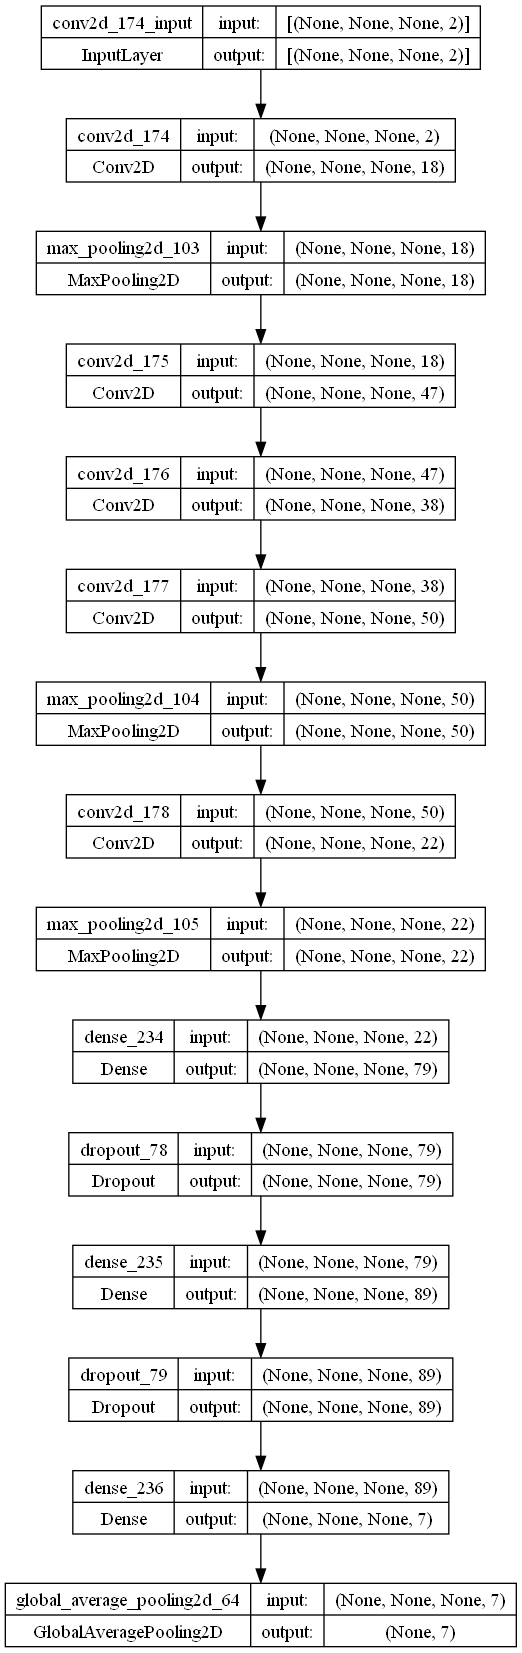

In [42]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [43]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [44]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [45]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [46]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.00001  # Updated final learning rate
    start_decay_epoch = 100
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr

In [47]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 5s 68ms/step - loss: 7.3552 - a_1: 2.7855 - a_2: 2.7735 - b_1: 2.5727 - b_2: 2.7519 - d_1: 1.2227 - d_2: 1.2233 - n: 1.5236 - mean_metric: 0.4895 - val_loss: 6.6551 - val_a_1: 2.7008 - val_a_2: 2.7428 - val_b_1: 2.3685 - val_b_2: 2.8006 - val_d_1: 0.8411 - val_d_2: 0.8731 - val_n: 1.4892 - val_mean_metric: 0.4571 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 4s 64ms/step - loss: 6.3456 - a_1: 2.7646 - a_2: 2.7600 - b_1: 2.0235 - b_2: 2.7467 - d_1: 0.8132 - d_2: 0.7835 - n: 1.4721 - mean_metric: 0.4405 - val_loss: 5.9198 - val_a_1: 2.6802 - val_a_2: 2.7286 - val_b_1: 1.5222 - val_b_2: 2.8054 - val_d_1: 0.8050 - val_d_2: 0.6375 - val_n: 1.4810 - val_mean_metric: 0.4188 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 4s 64ms/step - loss: 5.9015 - a_1: 2.7505 - a_2: 2.7606 - b_1: 1.5575 - b_2: 2.7491 - d_1: 0.6333 - d_2: 0.6106 - n: 1.4640 - mean_metric: 0.4130 - val_loss: 5.8361 - val_a_1: 2.6655

70/70 [==============================] - 5s 65ms/step - loss: 3.2737 - a_1: 1.6788 - a_2: 1.5726 - b_1: 0.9911 - b_2: 2.7334 - d_1: 0.4036 - d_2: 0.3670 - n: 0.4684 - mean_metric: 0.2708 - val_loss: 3.4798 - val_a_1: 1.7251 - val_a_2: 1.5601 - val_b_1: 1.0456 - val_b_2: 2.7937 - val_d_1: 0.6267 - val_d_2: 0.7187 - val_n: 0.5442 - val_mean_metric: 0.2983 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 5s 66ms/step - loss: 3.2036 - a_1: 1.6447 - a_2: 1.5379 - b_1: 0.9681 - b_2: 2.7298 - d_1: 0.3628 - d_2: 0.3561 - n: 0.4543 - mean_metric: 0.2655 - val_loss: 3.2597 - val_a_1: 1.5810 - val_a_2: 1.5419 - val_b_1: 0.9421 - val_b_2: 2.7967 - val_d_1: 0.4310 - val_d_2: 0.3170 - val_n: 0.5012 - val_mean_metric: 0.2685 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 5s 65ms/step - loss: 3.1895 - a_1: 1.6397 - a_2: 1.5398 - b_1: 0.9642 - b_2: 2.7323 - d_1: 0.3416 - d_2: 0.3224 - n: 0.4571 - mean_metric: 0.2636 - val_loss: 3.3345 - val_a_1: 1.6246 - val_a_2:

70/70 [==============================] - 5s 65ms/step - loss: 2.9321 - a_1: 1.4830 - a_2: 1.4125 - b_1: 0.8734 - b_2: 2.7265 - d_1: 0.3297 - d_2: 0.3057 - n: 0.3609 - mean_metric: 0.2470 - val_loss: 3.0167 - val_a_1: 1.4832 - val_a_2: 1.4568 - val_b_1: 0.8719 - val_b_2: 2.7990 - val_d_1: 0.2716 - val_d_2: 0.2534 - val_n: 0.4060 - val_mean_metric: 0.2497 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.9749 - a_1: 1.5025 - a_2: 1.4464 - b_1: 0.8925 - b_2: 2.7273 - d_1: 0.3582 - d_2: 0.3461 - n: 0.3668 - mean_metric: 0.2519 - val_loss: 3.0719 - val_a_1: 1.5764 - val_a_2: 1.4399 - val_b_1: 0.8776 - val_b_2: 2.8038 - val_d_1: 0.2897 - val_d_2: 0.2747 - val_n: 0.3625 - val_mean_metric: 0.2524 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.9594 - a_1: 1.4940 - a_2: 1.4239 - b_1: 0.9218 - b_2: 2.7285 - d_1: 0.3297 - d_2: 0.3358 - n: 0.3747 - mean_metric: 0.2509 - val_loss: 3.0236 - val_a_1: 1.4506 - val_a_2:

70/70 [==============================] - 5s 65ms/step - loss: 2.8267 - a_1: 1.3708 - a_2: 1.3790 - b_1: 0.8684 - b_2: 2.7232 - d_1: 0.3392 - d_2: 0.2880 - n: 0.3289 - mean_metric: 0.2407 - val_loss: 2.9616 - val_a_1: 1.3755 - val_a_2: 1.4915 - val_b_1: 0.8537 - val_b_2: 2.8031 - val_d_1: 0.3572 - val_d_2: 0.2788 - val_n: 0.3156 - val_mean_metric: 0.2476 - lr: 9.7140e-04
Epoch 128/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.8347 - a_1: 1.3870 - a_2: 1.3876 - b_1: 0.8564 - b_2: 2.7238 - d_1: 0.3339 - d_2: 0.3110 - n: 0.3292 - mean_metric: 0.2416 - val_loss: 2.9589 - val_a_1: 1.5086 - val_a_2: 1.3555 - val_b_1: 0.8286 - val_b_2: 2.8035 - val_d_1: 0.3467 - val_d_2: 0.3257 - val_n: 0.3709 - val_mean_metric: 0.2496 - lr: 9.7030e-04
Epoch 129/1000
70/70 [==============================] - 5s 66ms/step - loss: 2.8577 - a_1: 1.3969 - a_2: 1.3972 - b_1: 0.8737 - b_2: 2.7251 - d_1: 0.3334 - d_2: 0.3487 - n: 0.3372 - mean_metric: 0.2444 - val_loss: 2.9329 - val_a_1: 1.3083 

70/70 [==============================] - 5s 65ms/step - loss: 2.7604 - a_1: 1.3116 - a_2: 1.3386 - b_1: 0.8550 - b_2: 2.7219 - d_1: 0.3427 - d_2: 0.2885 - n: 0.3150 - mean_metric: 0.2366 - val_loss: 2.9039 - val_a_1: 1.3291 - val_a_2: 1.5005 - val_b_1: 0.8454 - val_b_2: 2.7978 - val_d_1: 0.3188 - val_d_2: 0.2892 - val_n: 0.3264 - val_mean_metric: 0.2453 - lr: 9.2520e-04
Epoch 170/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.7760 - a_1: 1.3320 - a_2: 1.3428 - b_1: 0.8644 - b_2: 2.7212 - d_1: 0.3057 - d_2: 0.3375 - n: 0.3165 - mean_metric: 0.2381 - val_loss: 2.8836 - val_a_1: 1.2803 - val_a_2: 1.3494 - val_b_1: 0.9839 - val_b_2: 2.7951 - val_d_1: 0.2373 - val_d_2: 0.3166 - val_n: 0.2664 - val_mean_metric: 0.2394 - lr: 9.2410e-04
Epoch 171/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.7959 - a_1: 1.3365 - a_2: 1.3634 - b_1: 0.8494 - b_2: 2.7236 - d_1: 0.3449 - d_2: 0.3200 - n: 0.3376 - mean_metric: 0.2399 - val_loss: 2.8331 - val_a_1: 1.3364 

70/70 [==============================] - 5s 65ms/step - loss: 2.7008 - a_1: 1.2665 - a_2: 1.2994 - b_1: 0.8262 - b_2: 2.7207 - d_1: 0.3050 - d_2: 0.2934 - n: 0.3089 - mean_metric: 0.2314 - val_loss: 2.8481 - val_a_1: 1.2827 - val_a_2: 1.3290 - val_b_1: 0.8401 - val_b_2: 2.7938 - val_d_1: 0.5233 - val_d_2: 0.3973 - val_n: 0.2724 - val_mean_metric: 0.2463 - lr: 8.7900e-04
Epoch 212/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.7150 - a_1: 1.2882 - a_2: 1.3083 - b_1: 0.8346 - b_2: 2.7191 - d_1: 0.3009 - d_2: 0.2822 - n: 0.3082 - mean_metric: 0.2322 - val_loss: 2.7845 - val_a_1: 1.2334 - val_a_2: 1.3487 - val_b_1: 0.8051 - val_b_2: 2.8000 - val_d_1: 0.2303 - val_d_2: 0.2229 - val_n: 0.2773 - val_mean_metric: 0.2291 - lr: 8.7790e-04
Epoch 213/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.6949 - a_1: 1.2579 - a_2: 1.3081 - b_1: 0.8126 - b_2: 2.7208 - d_1: 0.2980 - d_2: 0.2682 - n: 0.3117 - mean_metric: 0.2300 - val_loss: 2.7957 - val_a_1: 1.2685 

70/70 [==============================] - 5s 66ms/step - loss: 2.6669 - a_1: 1.2400 - a_2: 1.2788 - b_1: 0.7942 - b_2: 2.7194 - d_1: 0.3014 - d_2: 0.2972 - n: 0.3049 - mean_metric: 0.2287 - val_loss: 2.7571 - val_a_1: 1.2618 - val_a_2: 1.2955 - val_b_1: 0.7959 - val_b_2: 2.8008 - val_d_1: 0.2465 - val_d_2: 0.2597 - val_n: 0.2603 - val_mean_metric: 0.2292 - lr: 8.3280e-04
Epoch 254/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.6826 - a_1: 1.2405 - a_2: 1.2892 - b_1: 0.8098 - b_2: 2.7183 - d_1: 0.3233 - d_2: 0.3216 - n: 0.3067 - mean_metric: 0.2311 - val_loss: 2.7810 - val_a_1: 1.2156 - val_a_2: 1.2803 - val_b_1: 0.8509 - val_b_2: 2.8004 - val_d_1: 0.3496 - val_d_2: 0.3410 - val_n: 0.2901 - val_mean_metric: 0.2360 - lr: 8.3170e-04
Epoch 255/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.6826 - a_1: 1.2601 - a_2: 1.2860 - b_1: 0.8092 - b_2: 2.7196 - d_1: 0.3079 - d_2: 0.3071 - n: 0.2997 - mean_metric: 0.2304 - val_loss: 2.7328 - val_a_1: 1.1725 

70/70 [==============================] - 5s 66ms/step - loss: 2.6420 - a_1: 1.2007 - a_2: 1.2694 - b_1: 0.8000 - b_2: 2.7176 - d_1: 0.2993 - d_2: 0.3018 - n: 0.3030 - mean_metric: 0.2273 - val_loss: 2.7909 - val_a_1: 1.3327 - val_a_2: 1.2837 - val_b_1: 0.8011 - val_b_2: 2.8047 - val_d_1: 0.2494 - val_d_2: 0.2950 - val_n: 0.2531 - val_mean_metric: 0.2324 - lr: 7.8660e-04
Epoch 296/1000
70/70 [==============================] - 5s 67ms/step - loss: 2.6478 - a_1: 1.2262 - a_2: 1.2669 - b_1: 0.7937 - b_2: 2.7188 - d_1: 0.3147 - d_2: 0.3119 - n: 0.2960 - mean_metric: 0.2284 - val_loss: 2.7423 - val_a_1: 1.1679 - val_a_2: 1.3217 - val_b_1: 0.8511 - val_b_2: 2.8036 - val_d_1: 0.2079 - val_d_2: 0.3034 - val_n: 0.2763 - val_mean_metric: 0.2295 - lr: 7.8550e-04
Epoch 297/1000
70/70 [==============================] - 5s 67ms/step - loss: 2.6157 - a_1: 1.2101 - a_2: 1.2506 - b_1: 0.7732 - b_2: 2.7161 - d_1: 0.2795 - d_2: 0.2604 - n: 0.2897 - mean_metric: 0.2236 - val_loss: 2.7121 - val_a_1: 1.1936 

70/70 [==============================] - 5s 67ms/step - loss: 2.6161 - a_1: 1.2269 - a_2: 1.2460 - b_1: 0.7851 - b_2: 2.7137 - d_1: 0.2653 - d_2: 0.2805 - n: 0.2965 - mean_metric: 0.2246 - val_loss: 2.7266 - val_a_1: 1.1907 - val_a_2: 1.3146 - val_b_1: 0.7575 - val_b_2: 2.8037 - val_d_1: 0.2636 - val_d_2: 0.3769 - val_n: 0.2881 - val_mean_metric: 0.2316 - lr: 7.4040e-04
Epoch 338/1000
70/70 [==============================] - 5s 66ms/step - loss: 2.6071 - a_1: 1.1903 - a_2: 1.2380 - b_1: 0.7900 - b_2: 2.7160 - d_1: 0.2950 - d_2: 0.2754 - n: 0.2907 - mean_metric: 0.2241 - val_loss: 2.7170 - val_a_1: 1.2449 - val_a_2: 1.2568 - val_b_1: 0.7492 - val_b_2: 2.8004 - val_d_1: 0.2357 - val_d_2: 0.3123 - val_n: 0.2659 - val_mean_metric: 0.2273 - lr: 7.3930e-04
Epoch 339/1000
70/70 [==============================] - 5s 67ms/step - loss: 2.5922 - a_1: 1.1916 - a_2: 1.2293 - b_1: 0.7666 - b_2: 2.7168 - d_1: 0.2692 - d_2: 0.2545 - n: 0.2822 - mean_metric: 0.2213 - val_loss: 2.6834 - val_a_1: 1.1623 

70/70 [==============================] - 5s 67ms/step - loss: 2.5757 - a_1: 1.1800 - a_2: 1.2225 - b_1: 0.7621 - b_2: 2.7158 - d_1: 0.2496 - d_2: 0.2743 - n: 0.2929 - mean_metric: 0.2208 - val_loss: 2.7129 - val_a_1: 1.1952 - val_a_2: 1.2479 - val_b_1: 0.7711 - val_b_2: 2.8002 - val_d_1: 0.2123 - val_d_2: 0.4310 - val_n: 0.2766 - val_mean_metric: 0.2296 - lr: 6.9420e-04
Epoch 380/1000
70/70 [==============================] - 5s 67ms/step - loss: 2.5639 - a_1: 1.1785 - a_2: 1.2019 - b_1: 0.7559 - b_2: 2.7137 - d_1: 0.2625 - d_2: 0.2590 - n: 0.2797 - mean_metric: 0.2193 - val_loss: 2.8006 - val_a_1: 1.2347 - val_a_2: 1.2668 - val_b_1: 0.7740 - val_b_2: 2.8009 - val_d_1: 0.4391 - val_d_2: 0.6099 - val_n: 0.2536 - val_mean_metric: 0.2444 - lr: 6.9310e-04
Epoch 381/1000
70/70 [==============================] - 5s 67ms/step - loss: 2.5673 - a_1: 1.1642 - a_2: 1.2104 - b_1: 0.7616 - b_2: 2.7170 - d_1: 0.2657 - d_2: 0.2767 - n: 0.2802 - mean_metric: 0.2202 - val_loss: 2.6897 - val_a_1: 1.2557 

70/70 [==============================] - 5s 67ms/step - loss: 2.5539 - a_1: 1.1552 - a_2: 1.2117 - b_1: 0.7526 - b_2: 2.7122 - d_1: 0.2828 - d_2: 0.2451 - n: 0.2716 - mean_metric: 0.2187 - val_loss: 2.6735 - val_a_1: 1.1686 - val_a_2: 1.2709 - val_b_1: 0.7816 - val_b_2: 2.8028 - val_d_1: 0.2507 - val_d_2: 0.2270 - val_n: 0.2522 - val_mean_metric: 0.2237 - lr: 6.4800e-04
Epoch 422/1000
70/70 [==============================] - 5s 66ms/step - loss: 2.5637 - a_1: 1.1644 - a_2: 1.2164 - b_1: 0.7604 - b_2: 2.7105 - d_1: 0.2662 - d_2: 0.2866 - n: 0.2873 - mean_metric: 0.2206 - val_loss: 2.7207 - val_a_1: 1.1840 - val_a_2: 1.2491 - val_b_1: 0.7674 - val_b_2: 2.8003 - val_d_1: 0.3112 - val_d_2: 0.4727 - val_n: 0.3247 - val_mean_metric: 0.2354 - lr: 6.4690e-04
Epoch 423/1000
70/70 [==============================] - 5s 67ms/step - loss: 2.5462 - a_1: 1.1471 - a_2: 1.2000 - b_1: 0.7689 - b_2: 2.7097 - d_1: 0.2611 - d_2: 0.2384 - n: 0.2812 - mean_metric: 0.2179 - val_loss: 2.6831 - val_a_1: 1.1537 

70/70 [==============================] - 4s 63ms/step - loss: 2.5180 - a_1: 1.1256 - a_2: 1.1806 - b_1: 0.7309 - b_2: 2.7093 - d_1: 0.2670 - d_2: 0.2481 - n: 0.2661 - mean_metric: 0.2153 - val_loss: 2.6920 - val_a_1: 1.1838 - val_a_2: 1.2289 - val_b_1: 0.7971 - val_b_2: 2.8065 - val_d_1: 0.2341 - val_d_2: 0.3064 - val_n: 0.2767 - val_mean_metric: 0.2263 - lr: 6.0180e-04
Epoch 464/1000
70/70 [==============================] - 5s 64ms/step - loss: 2.5411 - a_1: 1.1443 - a_2: 1.1966 - b_1: 0.7534 - b_2: 2.7090 - d_1: 0.2711 - d_2: 0.2663 - n: 0.2781 - mean_metric: 0.2182 - val_loss: 2.6448 - val_a_1: 1.1466 - val_a_2: 1.1842 - val_b_1: 0.7781 - val_b_2: 2.8021 - val_d_1: 0.2745 - val_d_2: 0.1994 - val_n: 0.2791 - val_mean_metric: 0.2207 - lr: 6.0070e-04
Epoch 465/1000
70/70 [==============================] - 4s 64ms/step - loss: 2.5348 - a_1: 1.1389 - a_2: 1.1783 - b_1: 0.7722 - b_2: 2.7080 - d_1: 0.2639 - d_2: 0.2491 - n: 0.2764 - mean_metric: 0.2172 - val_loss: 2.6662 - val_a_1: 1.1560 

70/70 [==============================] - 4s 64ms/step - loss: 2.5374 - a_1: 1.1582 - a_2: 1.1818 - b_1: 0.7594 - b_2: 2.7067 - d_1: 0.2710 - d_2: 0.2519 - n: 0.2751 - mean_metric: 0.2177 - val_loss: 2.6745 - val_a_1: 1.1739 - val_a_2: 1.1991 - val_b_1: 0.7760 - val_b_2: 2.8101 - val_d_1: 0.2272 - val_d_2: 0.3401 - val_n: 0.2605 - val_mean_metric: 0.2248 - lr: 5.5560e-04
Epoch 506/1000
70/70 [==============================] - 5s 70ms/step - loss: 2.5650 - a_1: 1.1859 - a_2: 1.1883 - b_1: 0.7844 - b_2: 2.7087 - d_1: 0.2871 - d_2: 0.2831 - n: 0.2800 - mean_metric: 0.2215 - val_loss: 2.6752 - val_a_1: 1.1648 - val_a_2: 1.2025 - val_b_1: 0.7896 - val_b_2: 2.8109 - val_d_1: 0.2222 - val_d_2: 0.2552 - val_n: 0.2506 - val_mean_metric: 0.2217 - lr: 5.5450e-04
Epoch 507/1000
70/70 [==============================] - 4s 64ms/step - loss: 2.5230 - a_1: 1.1317 - a_2: 1.1716 - b_1: 0.7434 - b_2: 2.7065 - d_1: 0.2800 - d_2: 0.2710 - n: 0.2696 - mean_metric: 0.2167 - val_loss: 2.6950 - val_a_1: 1.1979 

70/70 [==============================] - 5s 66ms/step - loss: 2.5106 - a_1: 1.1347 - a_2: 1.1749 - b_1: 0.7434 - b_2: 2.7020 - d_1: 0.2596 - d_2: 0.2446 - n: 0.2779 - mean_metric: 0.2156 - val_loss: 2.6584 - val_a_1: 1.1235 - val_a_2: 1.2263 - val_b_1: 0.7744 - val_b_2: 2.8052 - val_d_1: 0.2231 - val_d_2: 0.2413 - val_n: 0.2309 - val_mean_metric: 0.2194 - lr: 5.0940e-04
Epoch 548/1000
70/70 [==============================] - 5s 67ms/step - loss: 2.5102 - a_1: 1.1281 - a_2: 1.1584 - b_1: 0.7541 - b_2: 2.7087 - d_1: 0.2485 - d_2: 0.2411 - n: 0.2798 - mean_metric: 0.2149 - val_loss: 2.6376 - val_a_1: 1.1068 - val_a_2: 1.1831 - val_b_1: 0.7578 - val_b_2: 2.8062 - val_d_1: 0.2754 - val_d_2: 0.2709 - val_n: 0.2600 - val_mean_metric: 0.2206 - lr: 5.0830e-04
Epoch 549/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.4941 - a_1: 1.1060 - a_2: 1.1648 - b_1: 0.7263 - b_2: 2.7058 - d_1: 0.2495 - d_2: 0.2437 - n: 0.2705 - mean_metric: 0.2133 - val_loss: 2.6619 - val_a_1: 1.1587 

70/70 [==============================] - 5s 65ms/step - loss: 2.5001 - a_1: 1.1307 - a_2: 1.1653 - b_1: 0.7430 - b_2: 2.7044 - d_1: 0.2593 - d_2: 0.2602 - n: 0.2706 - mean_metric: 0.2154 - val_loss: 2.6587 - val_a_1: 1.1381 - val_a_2: 1.2341 - val_b_1: 0.7661 - val_b_2: 2.8106 - val_d_1: 0.2579 - val_d_2: 0.3255 - val_n: 0.2514 - val_mean_metric: 0.2247 - lr: 4.6320e-04
Epoch 590/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.4854 - a_1: 1.1310 - a_2: 1.1379 - b_1: 0.7356 - b_2: 2.7031 - d_1: 0.2505 - d_2: 0.2479 - n: 0.2610 - mean_metric: 0.2132 - val_loss: 2.6068 - val_a_1: 1.1232 - val_a_2: 1.1205 - val_b_1: 0.7243 - val_b_2: 2.8065 - val_d_1: 0.2395 - val_d_2: 0.3375 - val_n: 0.2464 - val_mean_metric: 0.2185 - lr: 4.6210e-04
Epoch 591/1000
70/70 [==============================] - 5s 66ms/step - loss: 2.4595 - a_1: 1.0869 - a_2: 1.1204 - b_1: 0.7208 - b_2: 2.7011 - d_1: 0.2412 - d_2: 0.2406 - n: 0.2746 - mean_metric: 0.2106 - val_loss: 2.6207 - val_a_1: 1.1227 

70/70 [==============================] - 5s 65ms/step - loss: 2.4643 - a_1: 1.0888 - a_2: 1.1300 - b_1: 0.7391 - b_2: 2.6998 - d_1: 0.2446 - d_2: 0.2395 - n: 0.2634 - mean_metric: 0.2112 - val_loss: 2.5876 - val_a_1: 1.0925 - val_a_2: 1.0980 - val_b_1: 0.6893 - val_b_2: 2.8106 - val_d_1: 0.2408 - val_d_2: 0.2624 - val_n: 0.2187 - val_mean_metric: 0.2124 - lr: 4.1700e-04
Epoch 632/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.4322 - a_1: 1.0769 - a_2: 1.0900 - b_1: 0.7185 - b_2: 2.6976 - d_1: 0.2393 - d_2: 0.2125 - n: 0.2630 - mean_metric: 0.2076 - val_loss: 2.5865 - val_a_1: 1.0930 - val_a_2: 1.1221 - val_b_1: 0.6927 - val_b_2: 2.8145 - val_d_1: 0.1864 - val_d_2: 0.2090 - val_n: 0.2186 - val_mean_metric: 0.2099 - lr: 4.1590e-04
Epoch 633/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.4455 - a_1: 1.0760 - a_2: 1.1058 - b_1: 0.7210 - b_2: 2.7002 - d_1: 0.2442 - d_2: 0.2137 - n: 0.2703 - mean_metric: 0.2088 - val_loss: 2.5785 - val_a_1: 1.0792 

70/70 [==============================] - 4s 64ms/step - loss: 2.4455 - a_1: 1.0969 - a_2: 1.1100 - b_1: 0.7187 - b_2: 2.6974 - d_1: 0.2330 - d_2: 0.2532 - n: 0.2605 - mean_metric: 0.2101 - val_loss: 2.5850 - val_a_1: 1.0890 - val_a_2: 1.0824 - val_b_1: 0.7230 - val_b_2: 2.8146 - val_d_1: 0.1854 - val_d_2: 0.3081 - val_n: 0.2181 - val_mean_metric: 0.2127 - lr: 3.7080e-04
Epoch 674/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.4297 - a_1: 1.0700 - a_2: 1.0864 - b_1: 0.7126 - b_2: 2.6986 - d_1: 0.2480 - d_2: 0.2323 - n: 0.2723 - mean_metric: 0.2084 - val_loss: 2.5850 - val_a_1: 1.1066 - val_a_2: 1.0875 - val_b_1: 0.7120 - val_b_2: 2.8101 - val_d_1: 0.2143 - val_d_2: 0.2927 - val_n: 0.2293 - val_mean_metric: 0.2137 - lr: 3.6970e-04
Epoch 675/1000
70/70 [==============================] - 5s 66ms/step - loss: 2.4174 - a_1: 1.0785 - a_2: 1.0675 - b_1: 0.7066 - b_2: 2.6988 - d_1: 0.2277 - d_2: 0.2269 - n: 0.2611 - mean_metric: 0.2066 - val_loss: 2.6071 - val_a_1: 1.1293 

70/70 [==============================] - 4s 64ms/step - loss: 2.4104 - a_1: 1.0672 - a_2: 1.0593 - b_1: 0.6986 - b_2: 2.6944 - d_1: 0.2449 - d_2: 0.2228 - n: 0.2544 - mean_metric: 0.2058 - val_loss: 2.5937 - val_a_1: 1.1934 - val_a_2: 1.0672 - val_b_1: 0.6634 - val_b_2: 2.8184 - val_d_1: 0.2133 - val_d_2: 0.2526 - val_n: 0.2394 - val_mean_metric: 0.2136 - lr: 3.2460e-04
Epoch 716/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.3892 - a_1: 1.0546 - a_2: 1.0420 - b_1: 0.6828 - b_2: 2.6931 - d_1: 0.2230 - d_2: 0.2048 - n: 0.2547 - mean_metric: 0.2030 - val_loss: 2.5665 - val_a_1: 1.1110 - val_a_2: 1.0653 - val_b_1: 0.6702 - val_b_2: 2.8163 - val_d_1: 0.2098 - val_d_2: 0.2124 - val_n: 0.2367 - val_mean_metric: 0.2094 - lr: 3.2350e-04
Epoch 717/1000
70/70 [==============================] - 4s 64ms/step - loss: 2.4132 - a_1: 1.0854 - a_2: 1.0541 - b_1: 0.7047 - b_2: 2.6968 - d_1: 0.2310 - d_2: 0.2213 - n: 0.2609 - mean_metric: 0.2062 - val_loss: 2.6166 - val_a_1: 1.2077 

70/70 [==============================] - 5s 65ms/step - loss: 2.3941 - a_1: 1.0521 - a_2: 1.0619 - b_1: 0.6953 - b_2: 2.6934 - d_1: 0.2315 - d_2: 0.2125 - n: 0.2590 - mean_metric: 0.2046 - val_loss: 2.5735 - val_a_1: 1.0606 - val_a_2: 1.0799 - val_b_1: 0.6995 - val_b_2: 2.8192 - val_d_1: 0.2389 - val_d_2: 0.2186 - val_n: 0.2432 - val_mean_metric: 0.2107 - lr: 2.7840e-04
Epoch 758/1000
70/70 [==============================] - 4s 64ms/step - loss: 2.3871 - a_1: 1.0500 - a_2: 1.0370 - b_1: 0.6858 - b_2: 2.6920 - d_1: 0.2300 - d_2: 0.2179 - n: 0.2476 - mean_metric: 0.2031 - val_loss: 2.5583 - val_a_1: 1.0680 - val_a_2: 1.0639 - val_b_1: 0.6511 - val_b_2: 2.8218 - val_d_1: 0.2335 - val_d_2: 0.2259 - val_n: 0.2524 - val_mean_metric: 0.2093 - lr: 2.7730e-04
Epoch 759/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.3756 - a_1: 1.0383 - a_2: 1.0324 - b_1: 0.6799 - b_2: 2.6913 - d_1: 0.2335 - d_2: 0.2132 - n: 0.2531 - mean_metric: 0.2025 - val_loss: 2.5561 - val_a_1: 1.0451 

70/70 [==============================] - 4s 64ms/step - loss: 2.3749 - a_1: 1.0452 - a_2: 1.0446 - b_1: 0.6788 - b_2: 2.6897 - d_1: 0.2311 - d_2: 0.2114 - n: 0.2543 - mean_metric: 0.2029 - val_loss: 2.5730 - val_a_1: 1.0572 - val_a_2: 1.0421 - val_b_1: 0.6782 - val_b_2: 2.8213 - val_d_1: 0.2425 - val_d_2: 0.2188 - val_n: 0.2679 - val_mean_metric: 0.2096 - lr: 2.3220e-04
Epoch 800/1000
70/70 [==============================] - 5s 64ms/step - loss: 2.3571 - a_1: 1.0328 - a_2: 1.0157 - b_1: 0.6662 - b_2: 2.6874 - d_1: 0.2335 - d_2: 0.1997 - n: 0.2462 - mean_metric: 0.2006 - val_loss: 2.5750 - val_a_1: 1.0783 - val_a_2: 1.0706 - val_b_1: 0.6710 - val_b_2: 2.8206 - val_d_1: 0.2710 - val_d_2: 0.2276 - val_n: 0.2355 - val_mean_metric: 0.2111 - lr: 2.3110e-04
Epoch 801/1000
70/70 [==============================] - 4s 64ms/step - loss: 2.3790 - a_1: 1.0496 - a_2: 1.0453 - b_1: 0.6946 - b_2: 2.6869 - d_1: 0.2327 - d_2: 0.2047 - n: 0.2476 - mean_metric: 0.2032 - val_loss: 2.5784 - val_a_1: 1.0777 

70/70 [==============================] - 5s 66ms/step - loss: 2.3434 - a_1: 1.0249 - a_2: 1.0080 - b_1: 0.6785 - b_2: 2.6810 - d_1: 0.2159 - d_2: 0.2003 - n: 0.2464 - mean_metric: 0.1997 - val_loss: 2.5653 - val_a_1: 1.0596 - val_a_2: 1.1181 - val_b_1: 0.6664 - val_b_2: 2.8215 - val_d_1: 0.2326 - val_d_2: 0.1842 - val_n: 0.2333 - val_mean_metric: 0.2092 - lr: 1.8600e-04
Epoch 842/1000
70/70 [==============================] - 5s 66ms/step - loss: 2.3433 - a_1: 1.0286 - a_2: 1.0082 - b_1: 0.6723 - b_2: 2.6804 - d_1: 0.2375 - d_2: 0.2056 - n: 0.2451 - mean_metric: 0.2004 - val_loss: 2.5641 - val_a_1: 1.0588 - val_a_2: 1.0896 - val_b_1: 0.6484 - val_b_2: 2.8232 - val_d_1: 0.2760 - val_d_2: 0.1825 - val_n: 0.2283 - val_mean_metric: 0.2089 - lr: 1.8490e-04
Epoch 843/1000
70/70 [==============================] - 5s 66ms/step - loss: 2.3386 - a_1: 1.0192 - a_2: 1.0020 - b_1: 0.6529 - b_2: 2.6831 - d_1: 0.2325 - d_2: 0.1975 - n: 0.2466 - mean_metric: 0.1989 - val_loss: 2.5604 - val_a_1: 1.0558 

70/70 [==============================] - 5s 65ms/step - loss: 2.3150 - a_1: 1.0029 - a_2: 0.9829 - b_1: 0.6469 - b_2: 2.6810 - d_1: 0.2237 - d_2: 0.1774 - n: 0.2446 - mean_metric: 0.1964 - val_loss: 2.5345 - val_a_1: 1.0622 - val_a_2: 1.0269 - val_b_1: 0.6525 - val_b_2: 2.8279 - val_d_1: 0.1944 - val_d_2: 0.1582 - val_n: 0.2227 - val_mean_metric: 0.2036 - lr: 1.3980e-04
Epoch 884/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.3149 - a_1: 1.0037 - a_2: 0.9739 - b_1: 0.6542 - b_2: 2.6785 - d_1: 0.2135 - d_2: 0.1830 - n: 0.2466 - mean_metric: 0.1964 - val_loss: 2.5273 - val_a_1: 1.0638 - val_a_2: 1.0054 - val_b_1: 0.6518 - val_b_2: 2.8237 - val_d_1: 0.1837 - val_d_2: 0.1532 - val_n: 0.2294 - val_mean_metric: 0.2025 - lr: 1.3870e-04
Epoch 885/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.3087 - a_1: 1.0021 - a_2: 0.9686 - b_1: 0.6438 - b_2: 2.6778 - d_1: 0.2110 - d_2: 0.1818 - n: 0.2499 - mean_metric: 0.1958 - val_loss: 2.5437 - val_a_1: 1.0517 

70/70 [==============================] - 5s 65ms/step - loss: 2.2904 - a_1: 0.9771 - a_2: 0.9627 - b_1: 0.6361 - b_2: 2.6745 - d_1: 0.2044 - d_2: 0.1770 - n: 0.2436 - mean_metric: 0.1938 - val_loss: 2.5219 - val_a_1: 1.0171 - val_a_2: 1.0115 - val_b_1: 0.6498 - val_b_2: 2.8256 - val_d_1: 0.1909 - val_d_2: 0.1499 - val_n: 0.2727 - val_mean_metric: 0.2027 - lr: 9.3600e-05
Epoch 926/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.2873 - a_1: 0.9831 - a_2: 0.9573 - b_1: 0.6338 - b_2: 2.6726 - d_1: 0.1994 - d_2: 0.1855 - n: 0.2435 - mean_metric: 0.1938 - val_loss: 2.5174 - val_a_1: 1.0356 - val_a_2: 0.9989 - val_b_1: 0.6469 - val_b_2: 2.8232 - val_d_1: 0.1771 - val_d_2: 0.1410 - val_n: 0.2680 - val_mean_metric: 0.2018 - lr: 9.2500e-05
Epoch 927/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.2877 - a_1: 0.9854 - a_2: 0.9527 - b_1: 0.6365 - b_2: 2.6748 - d_1: 0.2029 - d_2: 0.1758 - n: 0.2469 - mean_metric: 0.1938 - val_loss: 2.5321 - val_a_1: 1.0286 

70/70 [==============================] - 5s 66ms/step - loss: 2.2680 - a_1: 0.9584 - a_2: 0.9465 - b_1: 0.6240 - b_2: 2.6690 - d_1: 0.1943 - d_2: 0.1648 - n: 0.2393 - mean_metric: 0.1911 - val_loss: 2.5085 - val_a_1: 1.0096 - val_a_2: 1.0001 - val_b_1: 0.6311 - val_b_2: 2.8311 - val_d_1: 0.2107 - val_d_2: 0.1499 - val_n: 0.2326 - val_mean_metric: 0.2009 - lr: 4.7400e-05
Epoch 968/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.2674 - a_1: 0.9611 - a_2: 0.9418 - b_1: 0.6237 - b_2: 2.6695 - d_1: 0.1981 - d_2: 0.1667 - n: 0.2407 - mean_metric: 0.1914 - val_loss: 2.5071 - val_a_1: 1.0085 - val_a_2: 0.9983 - val_b_1: 0.6350 - val_b_2: 2.8301 - val_d_1: 0.1905 - val_d_2: 0.1651 - val_n: 0.2279 - val_mean_metric: 0.2006 - lr: 4.6300e-05
Epoch 969/1000
70/70 [==============================] - 5s 65ms/step - loss: 2.2703 - a_1: 0.9637 - a_2: 0.9401 - b_1: 0.6245 - b_2: 2.6730 - d_1: 0.1987 - d_2: 0.1630 - n: 0.2365 - mean_metric: 0.1912 - val_loss: 2.5064 - val_a_1: 1.0037 

In [48]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

63/63 [==============================] - 1s 9ms/step - loss: 2.4118 - a_1: 0.9861 - a_2: 0.9551 - b_1: 0.6193 - b_2: 2.7575 - d_1: 0.1714 - d_2: 0.1573 - n: 0.2284 - mean_metric: 0.1956


# Analizamos accuracy y loss

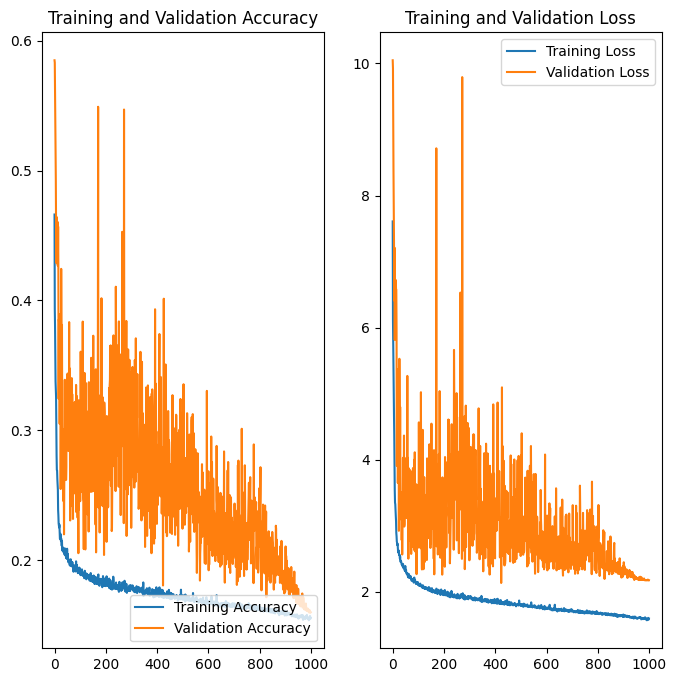

In [40]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

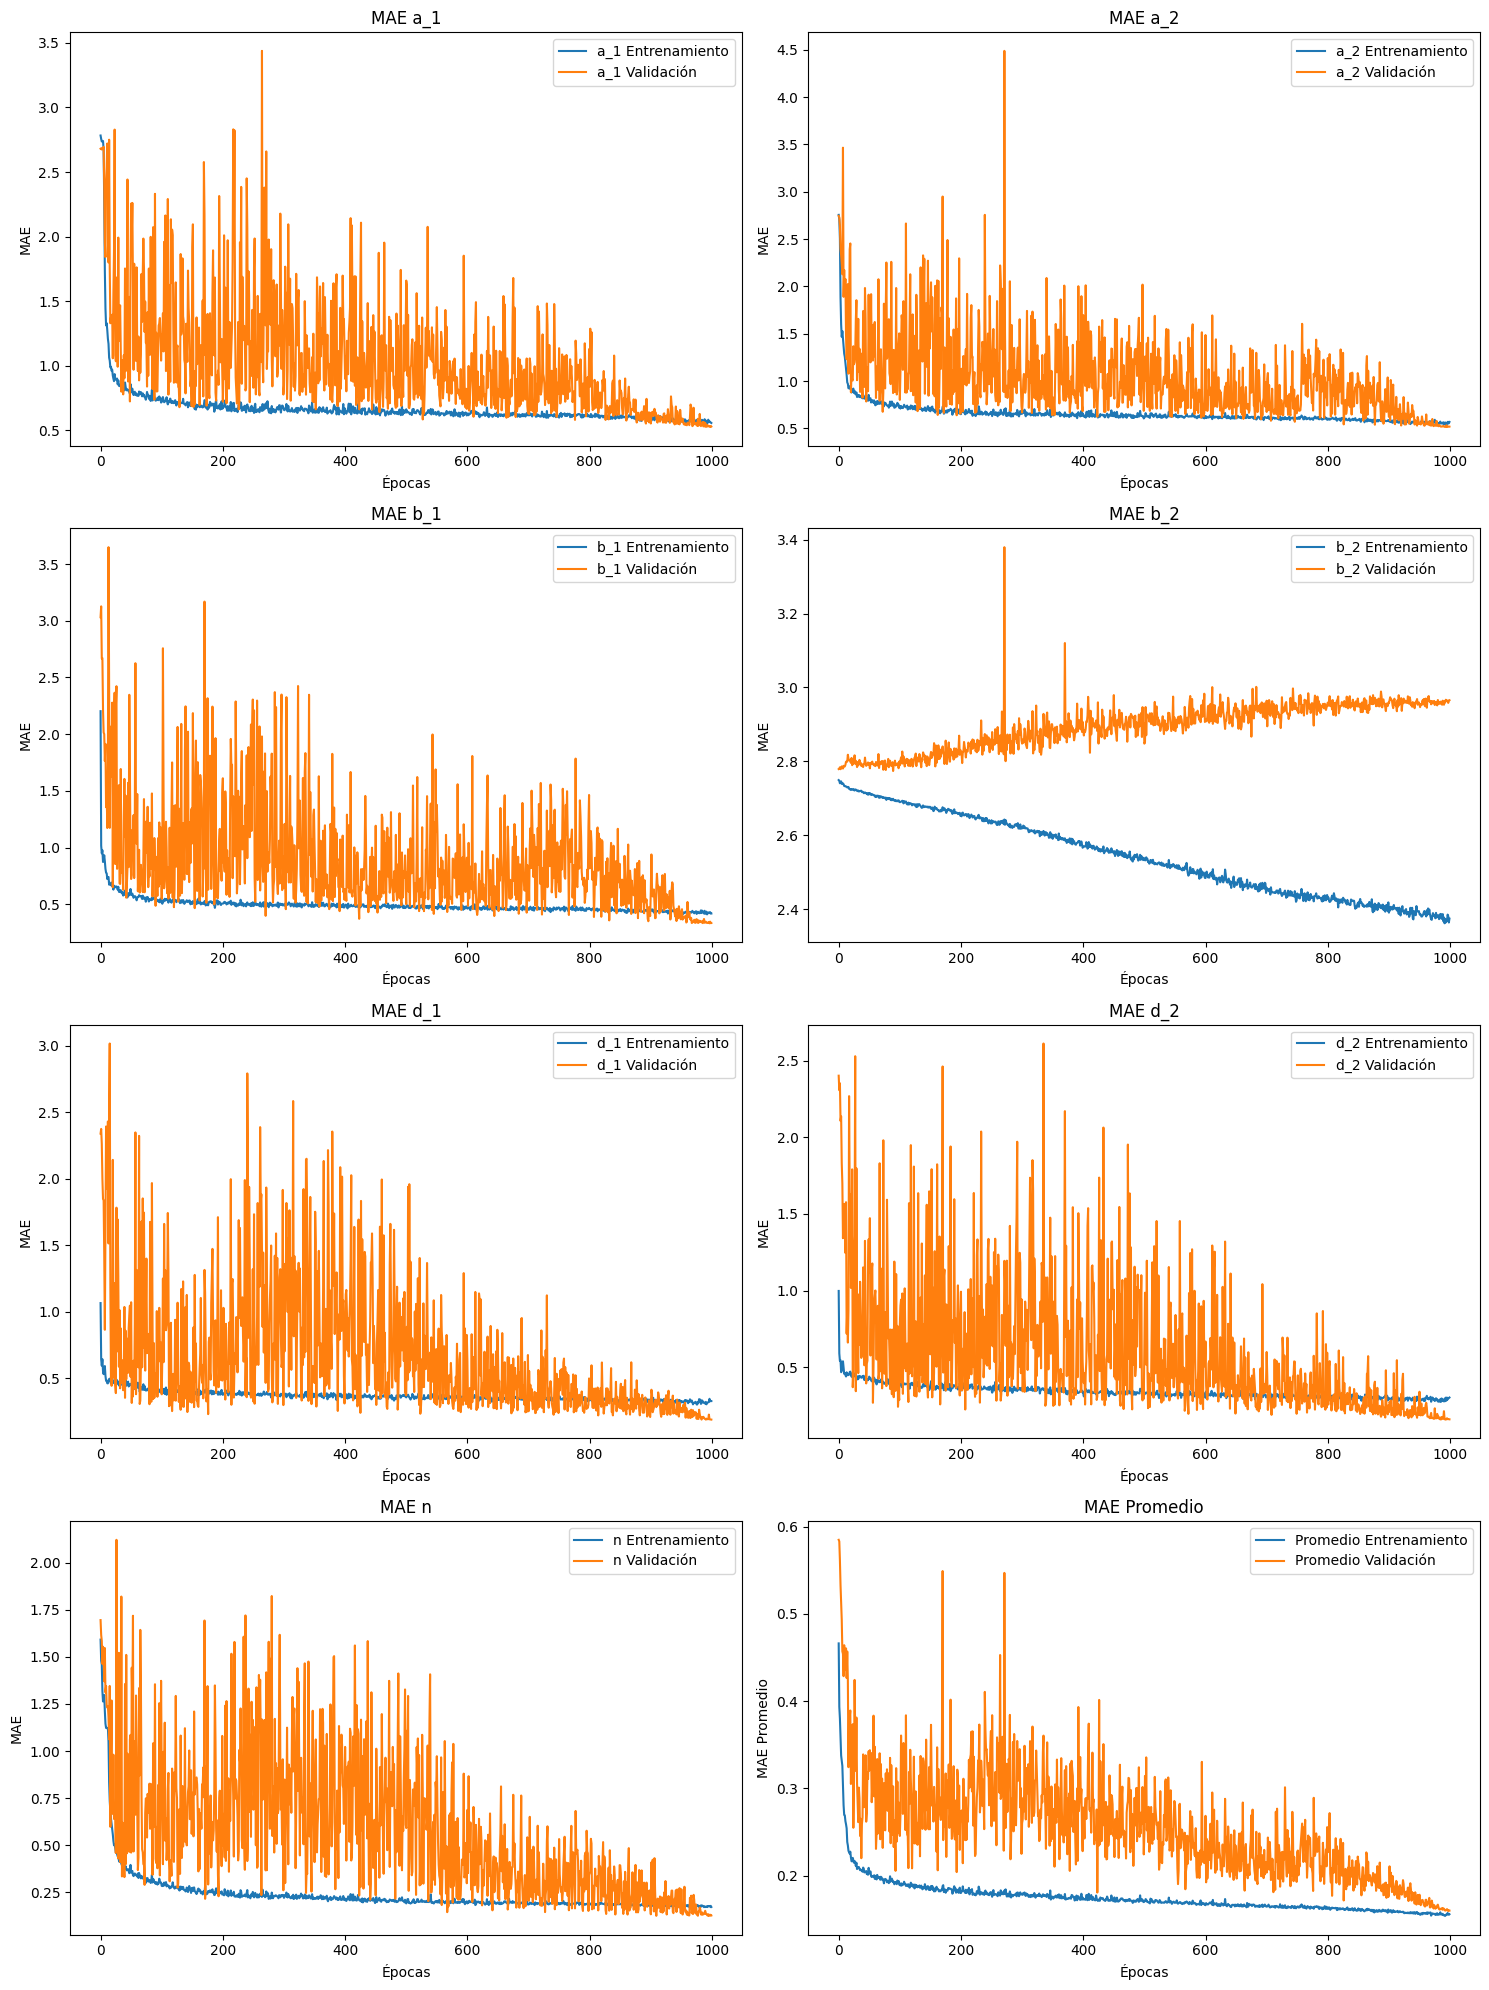

In [41]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [42]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

63/63 [==============================] - 0s 5ms/step - loss: 2.0743 - a_1: 0.5140 - a_2: 0.4914 - b_1: 0.3280 - b_2: 2.8608 - d_1: 0.1820 - d_2: 0.1642 - n: 0.1186 - mean_metric: 0.1551


In [43]:
predictions = model.predict(campvectest)

63/63 [==============================] - 0s 3ms/step


In [44]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

[ 7 10  7  2  3  4  3]
[7.0900083 9.891745  6.8709664 6.977769  2.9518483 4.01689   3.259466 ]
[36 33 36 ... 37 24 39]


0.8042248317173549

In [45]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.6664776901451904, Desviación estándar del error: 1.3952869328422246, Error absoluto máximo: 8.262413144111633


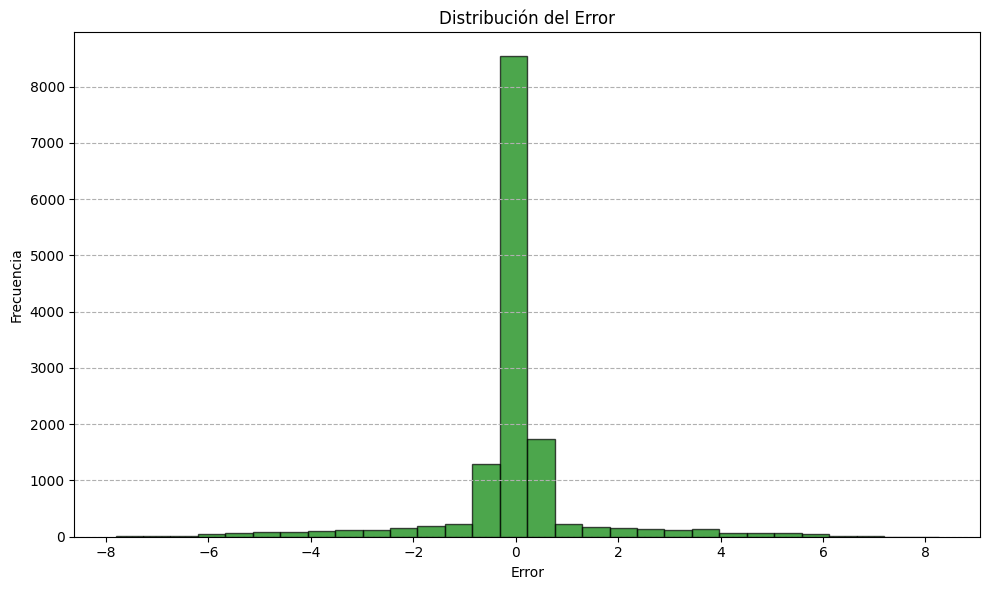

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [47]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.15881391378073437
Desviación estándar del error relativo: 0.13466244849406594
Error absoluto máximo relativo: 1.0622488734208875


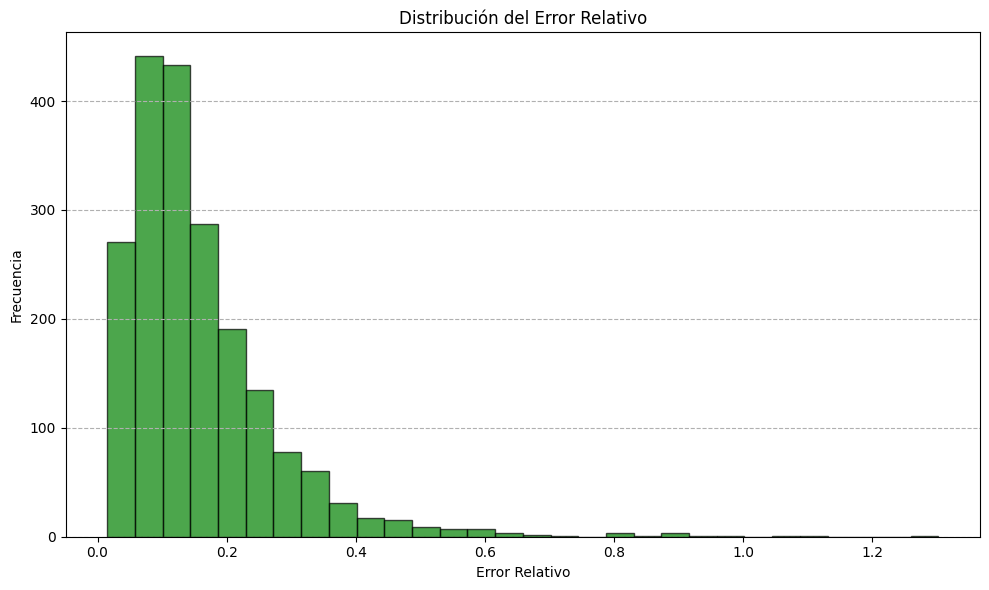

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()


# Guardamos los datos de Accuracy y Loss

In [49]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../Graficas/historyconvcampvec.csv', index=False)

# Guardamos el modelo

In [50]:
path_to_save = '../Modelos'

In [51]:
model.save(path_to_save + '/convolucionalcv.h5')

# Importamos el modelo

In [4]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [5]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [6]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../Modelos/convolucionalcv.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [58]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 50)
    y2 = np.linspace(y_range_neg, y_range_pos, 50)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[9, 6, 4, 8, 7, 4, 5]


In [59]:
campvecnone = campvec[None, :]
campvecnone = np.transpose(campvecnone, (0,2,3,1))

## Predecimos con los datos nuevos

In [60]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 74ms/step
[[10. 10.  7.  0.  9.  8.  1.]]


## Encontramos puntos de equilibro datos reales

In [61]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(0.5873087060752386, 2.4020307604629)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

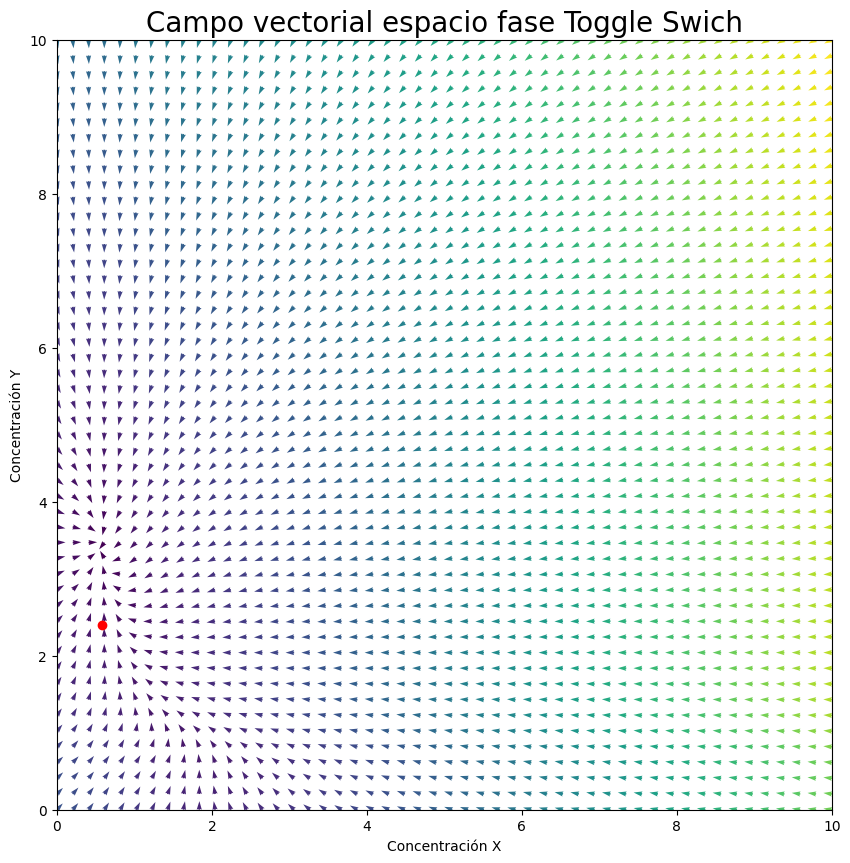

In [63]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 50)
y2 = np.linspace(0, 10, 50)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [64]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.2341820449275132, 1.434488875509495)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

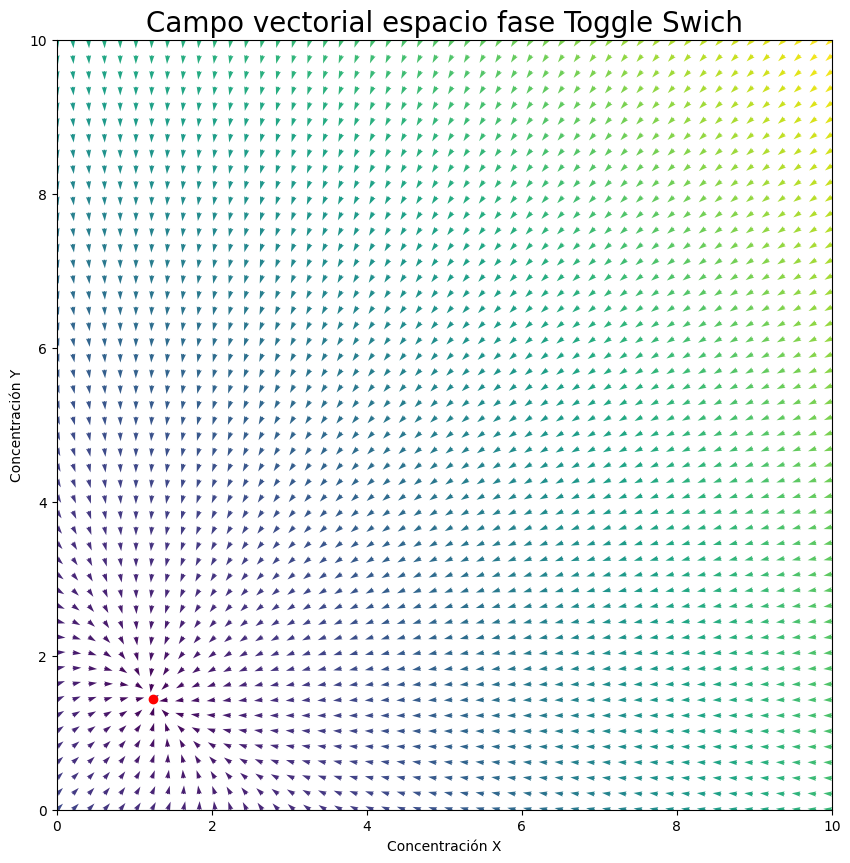

In [65]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 50)
y2pred = np.linspace(y_range_neg, y_range_pos, 50)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

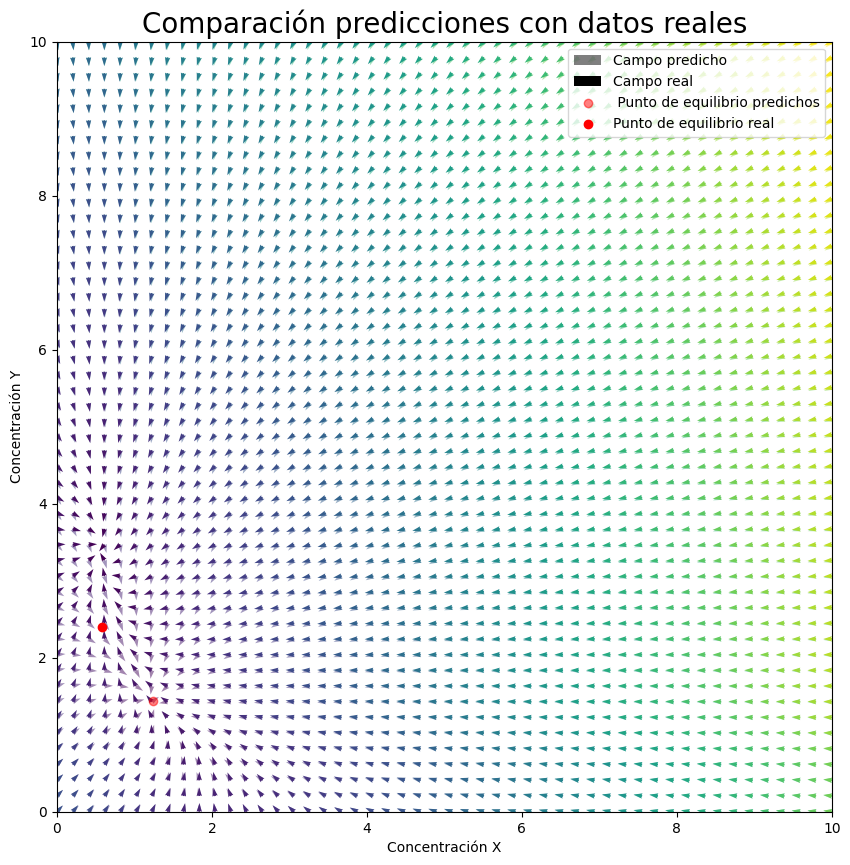

In [66]:
#%matplotlib qt
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5, label = "Campo predicho")

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1, label = "Campo real")

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5, label = " Punto de equilibrio predichos")
ax.scatter(x_values, y_values, color='red', alpha = 1, label = "Punto de equilibrio real")
ax.set_title('Comparación predicciones con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')
ax.legend(loc='upper right')  # Agregar leyenda a la gráfica
plt.show()

## Graficamos las diferencias

59.92331366856753


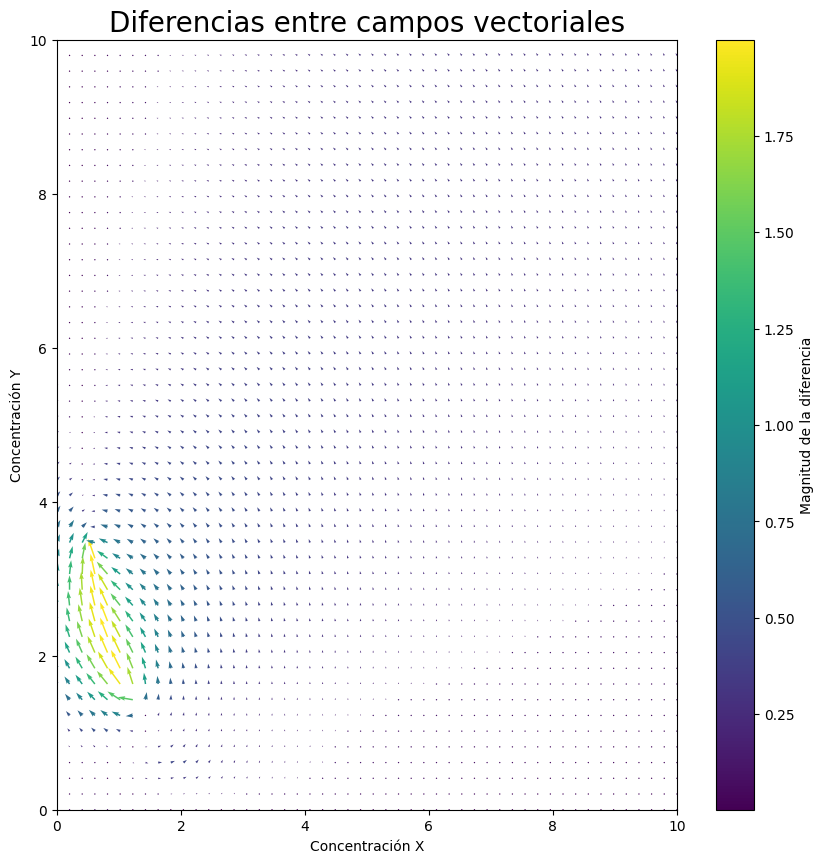

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [68]:
M_diff.mean()

0.2889227173589551

## Errores relativos

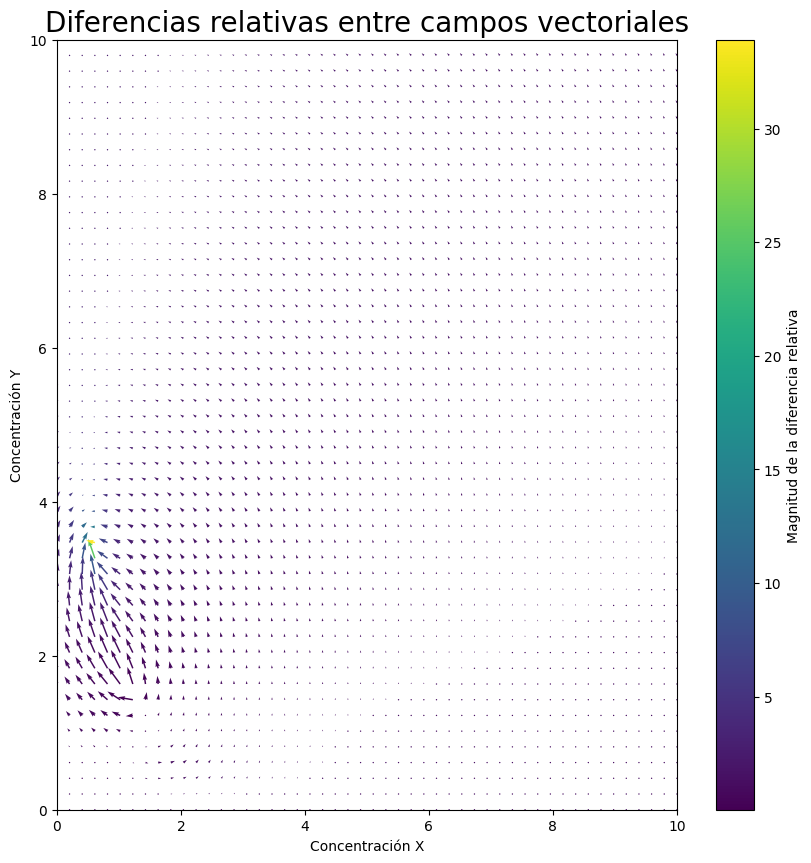

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [70]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 33.91280650327245
El valor de u1 en el error relativo máximo es: -0.2678446726644905
El valor de u1pred en el error relativo máximo es: 3.727238840741776
El valor de v1 en el error relativo máximo es: -0.3528175240627647
El valor de v1pred en el error relativo máximo es: -14.552570395246704


In [71]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

33.91281415908019

In [ ]:
# Listas para almacenar los resultados
import random
porcentajes_por_dim = {}

for dim_size in range(40, 101, 5):
    porcentajes_temp = []  # Lista temporal para almacenar los porcentajes de cada iteración

    # Repetimos el proceso 10 veces
    for repetir in range(1000):
        campvec = []
        coef = []
        # constantes
        a1 = random.randint(0, 10)
        a2 = random.randint(0, 10)
        b1 = random.randint(0, 10)
        b2 = random.randint(0, 10)
        d1 = random.randint(0, 10)
        d2 = random.randint(0, 10)
        n = random.randint(0, 5)

        coef1 = [a1, a2, b1, b2, d1, d2, n]
        coef.append(coef1)

        def f(t, y):

            # asignar a cada ODE a un elemento de vector
            X = y[0]
            Y = y[1]

            # definimos cada ODE
            dX_dt = a1/(1+Y**n)-d1*X+b1
            dY_dt = a2/(1+X**n)-d2*Y+b2

            return [dX_dt, dY_dt]

        x_range_neg = 0
        x_range_pos = 10
        y_range_neg = 0
        y_range_pos = 10

        y1 = np.linspace(x_range_neg, x_range_pos, dim_size)
        y2 = np.linspace(y_range_neg, y_range_pos, dim_size)

        Y1, Y2 = np.meshgrid(y1, y2)
    
        t1 = 0

        u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

        NI, NJ = Y1.shape

        u1, v1 = f(t1, [Y1, Y2])
        u, v = f(t1, [Y1, Y2])
        M = (np.hypot(u, v))
        u /= M
        v /= M

        campvecci = np.append([u1], [v1], axis=0)

        campvec = campvecci
        print('--------------------------------------------')
    #    print(coef1)
    
        campvec = np.array(campvec)

    
        campvecnone = campvec[None, :]
        campvecnone = np.transpose(campvecnone, (0,2,3,1))
    
        new_predictions = new_model.predict(campvecnone)
        new_predictions = np.round(new_predictions)
        new_predictions = np.clip(new_predictions, 0, None)
    #    print(new_predictions)
    
    
        a1pred = new_predictions[0,0]
        a2pred = new_predictions[0,1]
        b1pred = new_predictions[0,2]
        b2pred = new_predictions[0,3]
        d1pred = new_predictions[0,4]
        d2pred = new_predictions[0,5]
        npred = new_predictions[0,6]
    
        def f(t, y):

            # asignar a cada ODE a un elemento de vector
            X = y[0]
            Y = y[1]

            # definimos cada ODE
            dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
            dY_dt = a2pred/(1+X**npred)-d2pred*Y+b2pred

            return [dX_dt, dY_dt]

        x_range_neg = 0
        x_range_pos = 10
        y_range_neg = 0
        y_range_pos = 10

        y1pred = np.linspace(x_range_neg, x_range_pos, dim_size)
        y2pred = np.linspace(y_range_neg, y_range_pos, dim_size)
    
        Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
        t1 = 0

        upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)
    
        NI, NJ = Y1.shape

        u1pred, v1pred = f(t1, [Y1, Y2])
        upred, vpred = f(t1, [Y1, Y2])
        Mpred = (np.hypot(upred, vpred))
        upred /= Mpred
        vpred /= Mpred
    
     # Calculamos las diferencias
        u_diff = u - upred
        v_diff = v - vpred

        # Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
        epsilon = 1e-7

        # Calculamos la magnitud del vector original y de la diferencia
        M_orig = np.hypot(u, v) + epsilon
        M_diff = np.hypot(u_diff, v_diff)

        # Calculamos la diferencia relativa
        M_diff_rel = M_diff / M_orig
    
        # Aplicamos el filtro para la diferencia relativa mayor a 0.05
        mask = M_diff_rel > 0.1

        # Calculamos el porcentaje de puntos que cumplen con la condición
        porcentaje = np.mean(mask) * 100

        # Almacenamos el resultado en la lista
        porcentajes_temp.append(porcentaje)

        print(f"El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración {repetir+1} es {porcentaje:.2f}%")
    
    promedio = np.mean(porcentajes_temp)
    print(f"El porcentaje promedio de puntos cuyo error relativo es mayor a 0.05 con dimensión {dim_size} es {promedio:.2f}%")
    porcentajes_por_dim[dim_size] = promedio


--------------------------------------------
1/1 [==============================] - 0s 153ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1 es 99.19%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 2 es 90.94%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 3 es 88.62%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 4 es 75.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 5 es 11.94%
--------------------------------------------
1/1 [========================

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 45 es 88.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 46 es 98.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 47 es 99.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 48 es 98.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 49 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de p

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 89 es 86.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 90 es 68.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 91 es 90.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 92 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 93 es 99.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 133 es 13.19%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 134 es 97.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 135 es 28.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 136 es 98.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 137 es 97.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 177 es 68.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 178 es 29.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 179 es 99.94%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 180 es 70.94%
--------------------------------------------
1/1 [==============================] - 0s 18ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 181 es 83.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 221 es 12.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 222 es 95.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 223 es 99.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 224 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 225 es 70.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 265 es 99.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 266 es 48.81%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 267 es 45.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 268 es 99.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 269 es 68.56%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 309 es 50.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 310 es 99.69%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 311 es 99.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 312 es 98.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 313 es 69.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 353 es 98.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 354 es 81.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 355 es 32.56%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 356 es 87.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 357 es 72.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 397 es 55.94%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 398 es 92.69%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 399 es 96.62%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 400 es 49.44%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 401 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 441 es 91.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 442 es 53.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 443 es 57.38%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 444 es 87.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 445 es 82.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 485 es 97.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 486 es 67.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 487 es 98.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 488 es 83.38%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 489 es 98.12%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 529 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 530 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 531 es 48.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 532 es 53.62%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 533 es 76.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcenta

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 573 es 50.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 574 es 99.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 575 es 99.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 576 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 577 es 95.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 617 es 74.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 618 es 27.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 619 es 87.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 620 es 14.37%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 621 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 661 es 39.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 662 es 76.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 663 es 93.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 664 es 74.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 665 es 82.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 705 es 91.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 706 es 91.69%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 707 es 93.94%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 708 es 56.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 709 es 11.94%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 749 es 76.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 750 es 49.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 751 es 97.69%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 752 es 76.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 753 es 63.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 793 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 794 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 795 es 66.62%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 796 es 92.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 797 es 95.38%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 837 es 99.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 838 es 27.19%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 839 es 45.81%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 840 es 99.69%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 841 es 71.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 881 es 90.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 882 es 98.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 883 es 82.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 884 es 65.69%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 885 es 93.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 925 es 39.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 926 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 927 es 28.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 928 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 929 es 75.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 969 es 84.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 970 es 77.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 971 es 61.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 972 es 8.12%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 973 es 86.94%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 13 es 28.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 14 es 57.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 15 es 67.90%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 16 es 71.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 17 es 71.90%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 57 es 53.63%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 58 es 55.65%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 59 es 94.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 60 es 94.77%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 61 es 30.67%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 101 es 97.23%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 102 es 95.46%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 103 es 6.91%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 104 es 91.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 105 es 14.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 145 es 56.79%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 146 es 85.98%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 147 es 98.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 148 es 97.68%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 149 es 6.52%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 189 es 96.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 190 es 78.96%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 191 es 89.33%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 192 es 99.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 193 es 99.60%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 233 es 63.51%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 234 es 92.15%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 235 es 5.53%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 236 es 94.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 237 es 23.26%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje 

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 277 es 88.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 278 es 97.83%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 279 es 48.49%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 280 es 90.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 281 es 62.91%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 321 es 93.73%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 322 es 59.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 323 es 92.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 324 es 99.95%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 325 es 97.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 365 es 95.26%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 366 es 96.54%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 367 es 73.88%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 368 es 72.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 369 es 92.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 409 es 97.98%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 410 es 99.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 411 es 96.54%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 412 es 99.85%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 413 es 80.05%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 453 es 90.07%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 454 es 30.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 455 es 18.37%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 456 es 80.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 457 es 74.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 497 es 99.95%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 498 es 82.67%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 499 es 69.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 500 es 92.54%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 501 es 98.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 541 es 98.72%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 542 es 80.30%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 543 es 91.16%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 544 es 25.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 545 es 78.62%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 585 es 56.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 586 es 96.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 587 es 90.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 588 es 97.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 589 es 43.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 629 es 81.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 630 es 52.64%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 631 es 60.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 632 es 76.44%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 633 es 97.14%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 673 es 99.65%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 674 es 90.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 675 es 86.37%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 676 es 82.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 677 es 33.33%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 717 es 79.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 718 es 85.09%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 719 es 39.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 720 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 721 es 17.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 761 es 69.73%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 762 es 81.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 763 es 75.60%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 764 es 84.54%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 765 es 83.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 805 es 37.68%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 806 es 96.05%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 807 es 31.46%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 808 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 809 es 99.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 849 es 34.77%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 850 es 99.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 851 es 97.73%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 852 es 54.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 853 es 99.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 893 es 89.14%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 894 es 88.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 895 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 896 es 64.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 897 es 36.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 937 es 93.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 938 es 91.70%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 939 es 75.80%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 940 es 26.91%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 941 es 98.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 981 es 82.12%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 982 es 91.70%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 983 es 97.63%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 984 es 90.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 985 es 93.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 25 es 23.20%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 26 es 22.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 27 es 92.20%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 28 es 5.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 29 es 86.36%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de pu

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 69 es 83.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 70 es 99.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 71 es 58.24%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 72 es 77.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 73 es 99.60%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 113 es 19.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 114 es 16.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 115 es 97.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 116 es 33.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 117 es 94.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 157 es 95.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 158 es 25.60%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 159 es 85.44%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 160 es 33.96%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 161 es 69.84%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 201 es 38.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 202 es 91.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 203 es 27.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 204 es 71.84%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 205 es 35.92%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 245 es 96.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 246 es 98.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 247 es 53.08%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 248 es 10.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 249 es 20.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 289 es 45.96%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 290 es 97.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 291 es 12.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 292 es 97.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 293 es 88.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 333 es 18.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 334 es 84.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 335 es 99.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 336 es 26.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 337 es 15.40%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 377 es 22.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 378 es 35.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 379 es 75.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 380 es 95.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 381 es 99.36%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 421 es 77.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 422 es 94.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 423 es 60.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 424 es 5.52%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 425 es 88.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 465 es 98.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 466 es 43.76%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 467 es 98.92%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 468 es 43.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 469 es 74.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 509 es 71.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 510 es 88.24%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 511 es 29.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 512 es 93.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 513 es 96.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 553 es 70.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 554 es 26.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 555 es 35.40%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 556 es 76.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 557 es 76.56%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 597 es 80.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 598 es 80.40%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 599 es 12.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 600 es 93.80%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 601 es 88.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 641 es 98.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 642 es 94.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 643 es 28.68%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 644 es 96.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 645 es 97.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 685 es 93.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 686 es 98.24%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 687 es 91.68%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 688 es 99.40%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 689 es 50.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 729 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 730 es 99.60%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 731 es 89.40%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 732 es 90.28%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 733 es 96.72%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 773 es 99.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 774 es 89.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 775 es 28.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 776 es 43.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 777 es 76.76%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 817 es 89.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 818 es 10.16%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 819 es 52.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 820 es 98.56%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 821 es 81.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 861 es 77.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 862 es 52.60%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 863 es 4.44%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 864 es 36.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 865 es 55.28%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje 

C:\Users\rafae\AppData\Local\Temp\ipykernel_5656\2996514748.py:55: RuntimeWarning: invalid value encountered in true_divide
  u /= M
C:\Users\rafae\AppData\Local\Temp\ipykernel_5656\2996514748.py:56: RuntimeWarning: invalid value encountered in true_divide
  v /= M


1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 887 es 45.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 888 es 88.76%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 889 es 37.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 890 es 80.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 891 es 97.80%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 931 es 76.48%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 932 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 933 es 36.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 934 es 93.60%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 935 es 72.88%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 975 es 98.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 976 es 72.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 977 es 96.52%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 978 es 95.08%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 979 es 15.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 19 es 15.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 20 es 97.65%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 21 es 21.92%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 22 es 82.21%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 23 es 4.36%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de pu

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 63 es 97.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 64 es 55.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 65 es 64.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 66 es 28.13%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 67 es 56.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 107 es 54.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 108 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 109 es 85.45%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 110 es 91.54%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 111 es 99.90%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 151 es 54.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 152 es 19.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 153 es 9.82%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 154 es 90.98%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 155 es 64.10%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 195 es 7.70%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 196 es 74.61%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 197 es 23.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 198 es 99.87%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 199 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 239 es 8.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 240 es 86.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 241 es 9.82%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 242 es 96.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 243 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 283 es 58.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 284 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 285 es 46.18%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 286 es 93.49%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 287 es 99.74%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 327 es 38.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 328 es 85.69%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 329 es 69.95%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 330 es 82.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 331 es 73.65%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 371 es 61.55%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 372 es 49.65%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 373 es 92.53%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 374 es 95.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 375 es 25.39%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 415 es 38.35%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 416 es 97.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 417 es 38.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 418 es 19.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 419 es 99.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 459 es 36.40%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 460 es 96.63%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 461 es 33.29%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 462 es 5.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 463 es 16.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 503 es 56.53%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 504 es 74.45%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 505 es 82.51%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 506 es 99.70%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 507 es 85.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 547 es 86.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 548 es 99.67%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 549 es 95.87%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 550 es 21.85%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 551 es 98.71%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 591 es 40.66%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 592 es 80.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 593 es 52.10%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 594 es 81.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 595 es 49.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 635 es 64.46%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 636 es 87.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 637 es 97.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 638 es 77.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 639 es 25.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 679 es 18.51%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 680 es 98.05%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 681 es 99.77%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 682 es 29.42%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 683 es 99.01%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 723 es 54.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 724 es 30.81%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 725 es 10.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 726 es 91.17%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 727 es 78.31%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 767 es 99.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 768 es 76.20%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 769 es 64.23%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 770 es 68.73%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 771 es 90.45%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 811 es 57.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 812 es 22.98%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 813 es 74.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 814 es 61.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 815 es 25.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 855 es 10.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 856 es 62.55%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 857 es 73.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 858 es 67.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 859 es 34.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 899 es 85.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 900 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 901 es 99.70%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 902 es 12.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 903 es 95.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 943 es 25.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 944 es 46.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 945 es 59.70%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 946 es 99.34%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 947 es 69.02%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 987 es 42.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 988 es 98.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 989 es 97.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 990 es 40.66%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 991 es 99.87%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 31 es 56.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 32 es 36.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 33 es 98.03%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 34 es 40.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 35 es 47.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 75 es 80.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 76 es 12.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 77 es 68.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 78 es 28.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 79 es 86.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 119 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 120 es 54.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 121 es 99.69%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 122 es 13.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 123 es 89.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 163 es 93.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 164 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 165 es 10.08%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 166 es 51.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 167 es 42.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 207 es 98.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 208 es 29.47%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 209 es 93.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 210 es 93.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 211 es 43.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 251 es 20.03%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 252 es 87.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 253 es 90.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 254 es 98.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 255 es 6.97%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 295 es 70.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 296 es 48.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 297 es 82.83%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 298 es 11.61%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 299 es 88.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 339 es 82.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 340 es 41.58%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 341 es 33.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 342 es 82.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 343 es 7.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 383 es 76.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 384 es 98.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 385 es 43.47%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 386 es 32.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 387 es 55.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 427 es 95.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 428 es 2.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 429 es 16.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 430 es 85.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 431 es 25.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 471 es 98.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 472 es 92.89%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 473 es 15.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 474 es 10.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 475 es 35.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 515 es 29.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 516 es 3.58%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 517 es 68.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 518 es 92.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 519 es 78.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 559 es 36.83%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 560 es 94.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 561 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 562 es 97.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 563 es 77.53%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 603 es 98.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 604 es 85.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 605 es 16.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 606 es 29.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 607 es 19.08%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 647 es 69.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 648 es 35.58%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 649 es 97.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 650 es 99.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 651 es 79.58%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 691 es 62.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 692 es 49.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 693 es 78.14%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 694 es 35.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 695 es 93.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 735 es 98.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 736 es 26.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 737 es 99.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 738 es 31.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 739 es 43.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 779 es 50.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 780 es 96.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 781 es 50.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 782 es 76.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 783 es 57.39%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 823 es 30.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 824 es 10.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 825 es 89.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 826 es 65.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 827 es 56.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 867 es 56.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 868 es 67.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 869 es 22.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 870 es 48.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 871 es 52.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 911 es 76.61%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 912 es 98.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 913 es 29.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 914 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 915 es 88.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 955 es 90.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 956 es 25.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 957 es 44.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 958 es 13.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 959 es 59.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 999 es 99.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1000 es 86.67%
El porcentaje promedio de puntos cuyo error relativo es mayor a 0.05 con dimensión 60 es 58.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1 es 22.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 2 es 99.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 3 es 52.90%
-------------------

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 43 es 99.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 44 es 87.93%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 45 es 58.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 46 es 92.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 47 es 44.92%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

In [ ]:
import matplotlib.pyplot as plt
# Graficar cómo varía la métrica promedio en función del tamaño de la entrada
plt.figure(figsize=(10, 6))
plt.plot(list(porcentajes_por_dim.keys()), list(porcentajes_por_dim.values()), marker='o', color = 'green')
plt.xlabel('Tamaño de la dimensión')
plt.ylabel('Porcentaje promedio de error > 0.05 (%)')
plt.title('Variación del porcentaje promedio de error en función del tamaño de la entrada')
plt.grid(True)
plt.show()